In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action="ignore")
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic' # 예시: 맑은 고딕으로 설정 (Windows 환경 시)
plt.rcParams['axes.unicode_minus'] = False

In [3]:
data = pd.read_csv("C:/건강검진/health_checkup/JDM/선택컬럼_건강데이터.csv")

In [5]:
data = pd.read_csv("C:/건강검진/health_checkup/JDM/2022년~2023년/건강데이터_2022_2023_합본.csv") 

고혈압 전단계 혹은 고혈압인데 치료 안 한 사람

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 설정 ---
# 실제 데이터 파일 경로로 변경해주세요.
data_file_path = "C:/건강검진/health_checkup/JDM/2022년~2023년/건강조사_2012~2022_통합.csv"

# 분석에 사용할 변수 목록
columns_of_interest = [
    'ID','year','age','sex','HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1', # 수축기/이완기 혈압
    'HE_Upro', 'HE_glu', 'HE_chol', 'HE_HDL_st2',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt', # 임상 검사 결과
    'HE_obe', # 비만 여부 등
    'HE_HP', # 고혈압 상태 (3: 전단계, 4: 고혈압)
    'HE_DM_HbA1c', # 당뇨 관련
    'DI1_pt' # 고혈압 치료 여부 (0: 치료 안함)
]

# 유의미하다고 판단할 상관관계 절대값 임계값
significant_correlation_threshold = 0.5

# --- 데이터 로드 ---
try:
    df = pd.read_csv(data_file_path, usecols=columns_of_interest)
    print(f"데이터를 성공적으로 로드했습니다. 초기 크기: {df.shape}")

except FileNotFoundError:
    print(f"오류: '{data_file_path}' 파일을 찾을 수 없습니다.")
    print("예제 데이터프레임을 생성하여 분석을 시연합니다.")

    # --- 예제 데이터 생성 (실제 파일이 없을 경우를 대비) ---
    # 실제 데이터를 로드할 때는 아래 코드를 삭제하거나 주석 처리하세요.
    data = {}
    n_samples = 1000 # 예제 데이터 샘플 수
    for col in columns_of_interest:
        if col == 'ID':
            data[col] = range(n_samples)
        elif col in ['sex', 'year', 'HE_obe', 'HE_HP', 'DI1_pt']:
             if col == 'HE_HP':
                 data[col] = np.random.choice([1, 2, 3, 4], size=n_samples, p=[0.5, 0.1, 0.2, 0.2]) # 3, 4 포함
             elif col == 'DI1_pt':
                 data[col] = np.random.choice([0, 1], size=n_samples, p=[0.4, 0.6]) # 0 포함
             elif col == 'sex':
                 data[col] = np.random.randint(1, 3, size=n_samples) # 예: 1 남, 2 여
             else: # year, HE_obe
                 data[col] = np.random.randint(0, 2, size=n_samples)
        else:
            # 임의의 연속형 데이터 생성
            data[col] = np.random.rand(n_samples) * 100 + 50
            # 몇몇 변수 간에 임의로 상관관계가 있도록 조작 (예시)
            if col == 'HE_sbp1':
                 data[col] = np.random.normal(140, 15, size=n_samples)
            elif col == 'HE_dbp1':
                 data[col] = data['HE_sbp1'] * 0.6 + np.random.normal(20, 5, size=n_samples) # SBP와 상관관계
            elif col == 'HE_BMI':
                 data[col] = data['HE_wt'] / ((data['HE_ht']/100)**2) # BMI 계산 (wt, ht와 강한 상관관계)
            elif col == 'HE_chol':
                 data[col] = data['HE_LDL_drct'] + data['HE_HDL_st2'] + np.random.normal(0, 10, size=n_samples) # LDL, HDL과 상관관계
            elif col == 'age':
                 data[col] = np.random.normal(55, 10, size=n_samples)
                 # 나이와 혈압/콜레스테롤 등에 약한 상관관계 추가
                 if 'HE_sbp1' in data: data['HE_sbp1'] += data[col] * 0.5
                 if 'HE_chol' in data: data['HE_chol'] += data[col] * 0.3


    df = pd.DataFrame(data)
    df['HE_HP'] = df['HE_HP'].astype(int)
    df['DI1_pt'] = df['DI1_pt'].astype(int)

    # BMI 계산 다시 확인
    if 'HE_ht' in df.columns and 'HE_wt' in df.columns:
         df['HE_BMI'] = df['HE_wt'] / ((df['HE_ht']/100)**2)


    print(f"예제 데이터프레임 생성 완료. 크기: {df.shape}")
    print("예제 데이터의 HE_HP 및 DI1_pt 값 분포:")
    print(df[['HE_HP', 'DI1_pt']].value_counts().sort_index())
    # --- 예제 데이터 생성 끝 ---


# 데이터 로드 또는 예제 데이터 생성에 성공한 경우 분석 진행
if 'df' in locals() and df is not None:
    # --- 데이터 필터링 ---
    filtered_df = df[
        ((df['HE_HP'] == 3) | (df['HE_HP'] == 4)) &
        (df['DI1_pt'] == 0)
    ].copy()

    print(f"\n필터링 조건 (HE_HP in [3, 4] and DI1_pt == 0) 적용 후 크기: {filtered_df.shape}")

    if filtered_df.empty:
        print("\n필터링 조건에 해당하는 데이터가 없습니다. 상관관계 분석을 수행할 수 없습니다.")
    else:
        # --- 상관관계 분석 ---
        correlation_matrix = filtered_df.corr(numeric_only=True)

        # --- 상관관계 행렬 출력 (전체) ---
        # 전체 행렬 출력이 너무 길다면 이 부분을 주석 처리하거나 생략할 수 있습니다.
        print("\n--- 필터링된 데이터의 변수 간 전체 상관관계 행렬 (Pearson) ---")
        print(correlation_matrix.round(2))

        # --- 절대값 0.5 이상인 상관관계만 추출 및 출력 ---
        print(f"\n--- 절대값 {significant_correlation_threshold} 이상인 유의미한 상관관계 쌍 ---")
        significant_correlations = []

        # 상관관계 행렬의 컬럼 이름 목록
        cols = correlation_matrix.columns

        # 모든 변수 쌍에 대해 반복 (중복 및 자기 자신 제외)
        for i in range(len(cols)):
            for j in range(i + 1, len(cols)): # j를 i+1부터 시작하여 대각선 위쪽 절반만 확인
                var1 = cols[i]
                var2 = cols[j]
                corr_value = correlation_matrix.loc[var1, var2]

                # 상관계수 값이 NaN이 아니고, 절대값이 임계값 이상인지 확인
                if pd.notna(corr_value) and abs(corr_value) >= significant_correlation_threshold:
                     significant_correlations.append({
                         'Variable 1': var1,
                         'Variable 2': var2,
                         'Correlation': corr_value
                     })

        # 결과 출력
        if significant_correlations:
            # 절대값 상관관계가 큰 순서대로 정렬 (선택 사항)
            significant_correlations.sort(key=lambda x: abs(x['Correlation']), reverse=True)

            for pair in significant_correlations:
                print(f"  {pair['Variable 1']} - {pair['Variable 2']}: {pair['Correlation']:.4f}")
        else:
            print(f"  절대값 {significant_correlation_threshold} 이상의 상관관계를 가지는 변수 쌍이 필터링된 데이터에서 발견되지 않았습니다.")

        # --- 시각화 (히트맵) ---
        # 전체 히트맵 시각화는 그대로 두거나 필요

데이터를 성공적으로 로드했습니다. 초기 크기: (84099, 23)

필터링 조건 (HE_HP in [3, 4] and DI1_pt == 0) 적용 후 크기: (547, 23)

--- 필터링된 데이터의 변수 간 전체 상관관계 행렬 (Pearson) ---
             year   sex   age  DI1_pt  HE_sbp1  HE_dbp1  HE_HP  HE_ht  HE_wt  \
year         1.00 -0.07  0.08     NaN    -0.08    -0.08   0.39   0.13   0.05   
sex         -0.07  1.00  0.25     NaN     0.09    -0.12   0.00  -0.74  -0.47   
age          0.08  0.25  1.00     NaN     0.16    -0.48   0.09  -0.54  -0.58   
DI1_pt        NaN   NaN   NaN     NaN      NaN      NaN    NaN    NaN    NaN   
HE_sbp1     -0.08  0.09  0.16     NaN     1.00     0.37   0.00  -0.18  -0.12   
HE_dbp1     -0.08 -0.12 -0.48     NaN     0.37     1.00  -0.07   0.24   0.30   
HE_HP        0.39  0.00  0.09     NaN     0.00    -0.07   1.00  -0.01  -0.06   
HE_ht        0.13 -0.74 -0.54     NaN    -0.18     0.24  -0.01   1.00   0.70   
HE_wt        0.05 -0.47 -0.58     NaN    -0.12     0.30  -0.06   0.70   1.00   
HE_wc        0.12 -0.31 -0.32     NaN    -0.07     0.17 

In [62]:
# 해당 변수들이 모두 같은 값인지 확인
for col in ['DI1_pt', 'DI1_dg', 'DE1_3', 'DE1_dg']:
    print(f'{col} 고유값:', filtered[col].unique())
    print(f'{col} 결측값 수:', filtered[col].isnull().sum())


DI1_pt 고유값: [0.]
DI1_pt 결측값 수: 0
DI1_dg 고유값: [1.]
DI1_dg 결측값 수: 0
DE1_3 고유값: [8. 1. 2.]
DE1_3 결측값 수: 0
DE1_dg 고유값: [8. 1. 0.]
DE1_dg 결측값 수: 0


In [ ]:
data['DI1_pt'].value_counts()  #DI1_pt = 1: 혈압 치료 함, 0: 안 함, 8: 비해당, 9: 모름

DI1_pt
8.0    62413
1.0    14685
0.0     1222
9.0     1012
Name: count, dtype: int64

In [ ]:
data['DE1_3'].value_counts() #DE1_3 = 1: 당뇨관리함, 2: 안 함, 8: 비해당, 9: 모름

DE1_3
8.0    71948
1.0     5924
9.0     1033
2.0      427
Name: count, dtype: int64

In [41]:
filtered_data = data[
    (data['HE_HP'].isin([3, 4])) &  # 고혈압 전단계 또는 고혈압
    (data['DI1_pt'] == 0)          # 혈압 치료 안 함
]

print(len(filtered_data))
# 또는
print(filtered_data.shape[0])

547
547


In [42]:
filtered_data2 = data[
    (data['HE_DM_HbA1c'].isin([2, 3])) &  # 당뇨병 전단계 또는 당뇨병병
    (data['DE1_3'] == 2)          # 혈당 치료 안 함
]

print(len(filtered_data2))
# 또는
print(filtered_data2.shape[0])

123
123


In [49]:
data['HE_DM_HbA1c'].value_counts()

HE_DM_HbA1c
1.0    9655
2.0    8801
3.0    3424
Name: count, dtype: int64

In [50]:
data['HE_HP'].value_counts()

HE_HP
1.0    27051
3.0    19385
2.0    14239
4.0     1824
Name: count, dtype: int64

In [57]:
data['DE1_3'].value_counts()

DE1_3
8.0    71948
1.0     5924
9.0     1033
2.0      427
Name: count, dtype: int64

In [13]:
data = pd.read_csv("C:/건강검진/health_checkup/JDM/2022년~2023년/건강데이터_2022_2023_합본.csv")

EDA

In [4]:
data.head()

,ID,year,region,town_t,sex,age,incm,ho_incm,edu,occp,cfam,genertn,D_1_1,DI1_dg,DI1_ag,DI1_pr,DI1_pt,DI1_2,DI2_dg,DI2_ag,DI2_pr,DI2_pt,DI2_2,DE1_dg,DE1_ag,DE1_pr,DE1_pt,DE1_3,DE1_31,DE1_32,DE1_33,DE1_34,DE1_4,DN1_dg,DN1_ag,BH1,BO1,BO1_1,BO2_1,BD1,BD1_11,BD2_1,BP16_1,BP16_2,BP1,BP5,BS1_1,BS3_1,BS3_2,BS12_37,BS12_47,BS12_47_1,BS12_1,BS12_2,BE3_31,BE3_32,BE3_33,BE5_1,BE9,HE_fh,HE_HPfh1,HE_HPfh2,HE_HLfh1,HE_HLfh2,HE_DMfh1,HE_DMfh2,HE_sbp1,HE_dbp1,HE_sbp2,HE_dbp2,HE_HP,HE_ht,HE_wt,HE_wc,HE_BMI,HE_obe,HE_glu,HE_HbA1c,HE_DM_HbA1c,HE_chol,HE_HDL_st2,HE_TG,HE_LDL_drct,HE_HCHOL,HE_HTG,HE_ast,HE_alt,HE_BUN,HE_crea,HE_Upro,HE_Ucrea,HE_Ualb,L_BR_FQ,L_LN_FQ,L_DN_FQ,L_OUT_FQ,LS_VEG1,LS_FRUIT
0,YA01220302,2022.0,1.0,1.0,2.0,56.0,3.0,4.0,3.0,7.0,4.0,4.0,3.0,1.0,48.0,1.0,1.0,1.0,0.0,888.0,8.0,8.0,8.0,0.0,888.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,0.0,888.0,1.0,4.0,1.0,1.0,2.0,1.0,8.0,8.0,10.0,2.0,8.0,3.0,8.0,888.0,2.0,8.0,888.0,2.0,8.0,5.0,1.0,30.0,1.0,88.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,135.0,90.0,138.0,89.0,4.0,151.2,60.6,84.3,26.507517,4.0,94.0,5.6,1.0,199.0,56.0,181.0,122.0,0.0,0.0,22.0,16.0,13.0,0.61,0.0,84.6,9.7,3.0,1.0,1.0,5.0,2.0,2.0
1,YA01220303,2022.0,1.0,1.0,1.0,30.0,3.0,4.0,4.0,3.0,4.0,4.0,2.0,0.0,888.0,8.0,8.0,8.0,0.0,888.0,8.0,8.0,8.0,0.0,888.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,0.0,888.0,1.0,4.0,3.0,1.0,2.0,3.0,2.0,7.0,7.0,3.0,8.0,3.0,8.0,888.0,2.0,8.0,888.0,2.0,8.0,8.0,3.0,0.0,6.0,88.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,145.0,77.0,128.0,78.0,3.0,174.1,82.3,86.2,27.152029,4.0,84.0,5.3,1.0,122.0,48.0,63.0,63.0,0.0,0.0,28.0,18.0,14.0,0.86,0.0,54.3,NaN,1.0,1.0,1.0,4.0,2.0,3.0
2,YA01220304,2022.0,1.0,1.0,2.0,25.0,3.0,4.0,4.0,7.0,4.0,4.0,2.0,0.0,888.0,8.0,8.0,8.0,0.0,888.0,8.0,8.0,8.0,0.0,888.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,0.0,888.0,2.0,4.0,2.0,1.0,2.0,4.0,1.0,6.0,8.0,2.0,8.0,3.0,8.0,888.0,2.0,8.0,888.0,2.0,8.0,8.0,0.0,20.0,6.0,88.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,103.0,64.0,104.0,63.0,1.0,166.4,59.0,69.4,21.308131,2.0,87.0,5.0,1.0,202.0,75.0,53.0,124.0,0.0,NaN,17.0,15.0,8.0,0.60,0.0,192.4,9.4,4.0,1.0,2.0,3.0,2.0,2.0
3,YA01236501,2022.0,1.0,1.0,1.0,66.0,3.0,3.0,4.0,7.0,2.0,2.0,2.0,0.0,888.0,8.0,8.0,8.0,1.0,56.0,1.0,1.0,1.0,0.0,888.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,0.0,888.0,1.0,3.0,1.0,2.0,2.0,3.0,2.0,9.0,9.0,4.0,8.0,2.0,3.0,888.0,2.0,8.0,888.0,2.0,8.0,8.0,1.0,30.0,1.0,88.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,116.0,80.0,120.0,78.0,2.0,168.7,67.1,83.5,23.577207,3.0,87.0,5.2,1.0,136.0,47.0,123.0,74.0,1.0,0.0,20.0,15.0,18.0,0.90,0.0,99.1,NaN,1.0,1.0,1.0,4.0,1.0,2.0
4,YA01236502,2022.0,1.0,1.0,2.0,62.0,3.0,3.0,3.0,6.0,2.0,2.0,2.0,0.0,888.0,8.0,8.0,8.0,1.0,53.0,1.0,1.0,1.0,0.0,888.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,0.0,888.0,1.0,3.0,1.0,1.0,2.0,2.0,1.0,7.0,9.0,3.0,8.0,3.0,8.0,888.0,2.0,8.0,888.0,2.0,8.0,8.0,1.0,0.0,4.0,88.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,145.0,89.0,131.0,87.0,3.0,157.1,53.9,77.5,21.839183,2.0,91.0,5.6,1.0,149.0,53.0,110.0,82.0,1.0,0.0,26.0,23.0,10.0,0.67,0.0,46.5,3.3,1.0,1.0,1.0,6.0,1.0,2.0


In [5]:
data.shape

(13194, 98)

- **BP1** : 평소 스트레스 인지 정도  
- **BD1_11** : 1년간 음주빈도  
- **BS3_2** : 하루평균 일반담배(궐련) 흡연량  
- **BE5_1** : 1주일간 운동 회수  

In [14]:
import pandas as pd

# 남기고 싶은 컬럼 리스트
columns_to_keep = [
    'ID','year','age','sex','HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1',
    'HE_Upro', 'HE_glu', 'HE_chol', 'HE_HDL_st2', 'HE_HbA1c',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt',
    # 'L_OUT_FQ', 
    # 'BP1','BD1_11', 'BS3_2', 'BE5_1', 
    'HE_obe', 'HE_HP', 'HE_DM_HbA1c',
    'DE1_dg', 'DI1_dg',
    
    #당뇨 관리, 혈압 치료
    'DE1_3', 'DI1_pt'
]

# 원래 데이터프레임이 df일 때
data = data[columns_to_keep]


고혈압인데 치료 안 한 사람

In [27]:
data['HE_DM_HbA1c'].value_counts()

HE_DM_HbA1c
3.0    11
Name: count, dtype: int64

In [10]:
set(data['DE1_3'])

{1.0, 2.0}

In [11]:
set(data['DI1_pt'])

{0.0, 1.0}

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13194 entries, 0 to 13193
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           13194 non-null  object 
 1   year         13194 non-null  float64
 2   age          13194 non-null  float64
 3   sex          13194 non-null  float64
 4   HE_ht        12964 non-null  float64
 5   HE_wt        13104 non-null  float64
 6   HE_wc        12285 non-null  float64
 7   HE_BMI       12959 non-null  float64
 8   HE_sbp1      12490 non-null  float64
 9   HE_dbp1      12490 non-null  float64
 10  HE_Upro      11828 non-null  float64
 11  HE_glu       11744 non-null  float64
 12  HE_chol      11744 non-null  float64
 13  HE_HDL_st2   11744 non-null  float64
 14  HE_TG        11744 non-null  float64
 15  HE_LDL_drct  11744 non-null  float64
 16  HE_crea      11744 non-null  float64
 17  HE_ast       11743 non-null  float64
 18  HE_alt       11719 non-null  float64
 19  HE_o

In [7]:
data.head()

,ID,year,age,sex,HE_ht,HE_wt,HE_wc,HE_BMI,HE_sbp1,HE_dbp1,HE_Upro,HE_glu,HE_chol,HE_HDL_st2,HE_TG,HE_LDL_drct,HE_crea,HE_ast,HE_alt,HE_obe,HE_HP,HE_DM_HbA1c,DE1_dg,DI1_dg,DE1_3,DI1_pt
0,YA84208301,2023.0,75.0,1.0,159.8,58.9,90.2,23.065440,144.0,86.0,0.0,125.0,166.0,38.0,162.0,101.0,0.78,59.0,29.0,3.0,4.0,2.0,0.0,1.0,8.0,1.0
1,YA84208302,2023.0,70.0,2.0,151.2,41.8,65.2,18.284063,125.0,76.0,1.0,105.0,218.0,67.0,74.0,139.0,0.63,18.0,17.0,1.0,3.0,2.0,0.0,0.0,8.0,8.0
2,YA84212402,2023.0,42.0,2.0,156.7,53.5,71.8,21.787921,102.0,57.0,0.0,102.0,196.0,87.0,43.0,105.0,0.81,19.0,11.0,2.0,1.0,2.0,0.0,0.0,8.0,8.0
3,YA84212404,2023.0,9.0,2.0,142.0,35.8,59.6,17.754414,108.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,8.0,8.0,8.0
4,YA84242702,2023.0,43.0,1.0,185.0,79.8,86.9,23.316289,131.0,93.0,0.0,101.0,176.0,40.0,145.0,116.0,1.19,28.0,40.0,3.0,4.0,2.0,0.0,0.0,8.0,8.0


컬럼 **98개 중 31개**만 추출

In [22]:
data.shape

(13194, 32)

데이터 프레임 한글로 출력

In [4]:
column_mapping = {
    'ID': 'ID',
    'year': 'year(조사연도)',
    'age': '연령',
    'sex': '성별',
    'HE_ht': '신장(cm)',
    'HE_wt': '체중(kg)',
    'HE_wc': '허리둘레(cm)',
    'HE_BMI': '체질량지수(BMI)',
    'HE_sbp1': '수축기 혈압',
    'HE_dbp1': '이완기 혈압',
    'HE_Upro': '소변 단백',
    'HE_glu': '공복혈당',
    'HE_chol': '총 콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤',
    'HE_TG': '중성지방',
    'HE_LDL_drct': 'LDL 콜레스테롤',
    'HE_crea': '크레아티닌',
    'HE_ast': 'AST (간기능)',
    'HE_alt': 'ALT (간기능)',
    'L_OUT_FQ': '최근 1년 외식 빈도',
    'BP1': '1년간 음주 빈도',
    'BD1_11': '하루 평균 담배 흡연량',
    'BS3_2': '1주일간 운동 횟수',
    'BE5_1': '스트레스 인지 정도',
    'HE_obe': '비만 여부',
    'HE_HP': '고혈압 여부',
    'DI1_dg': '고혈압 의사진단 여부',
    'HE_DM_HbA1c': '당뇨 여부 (HbA1c)',
    'DE1_dg': '당뇨병 의사진단 여부'
}

# 1. 영어 컬럼 순서 (원하는 순서)
original_columns = [
    'ID','year','age','sex','HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1','HE_Upro', 'HE_glu', 'HE_chol', 'HE_HDL_st2',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt',
     'L_OUT_FQ',
    'BP1','BD1_11', 'BS3_2', 'BE5_1', 
    'HE_obe', 'HE_HP', 'DI1_dg', 'HE_DM_HbA1c','DE1_dg'
]

# 2. 한글 매핑된 컬럼 리스트 만들기
kor_columns = [column_mapping[col] for col in original_columns]

# 3. 컬럼명 한글로 바꾸기
data = data.rename(columns=column_mapping)

# 4. 원하는 순서로 재정렬
data = data[kor_columns]

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13194 entries, 0 to 13193
Data columns (total 98 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           13194 non-null  object 
 1   year         13194 non-null  float64
 2   region       13194 non-null  float64
 3   town_t       13194 non-null  float64
 4   sex          13194 non-null  float64
 5   age          13194 non-null  float64
 6   incm         13157 non-null  float64
 7   ho_incm      13157 non-null  float64
 8   edu          12812 non-null  float64
 9   occp         10624 non-null  float64
 10  cfam         13194 non-null  float64
 11  genertn      13194 non-null  float64
 12  D_1_1        13185 non-null  float64
 13  DI1_dg       13185 non-null  float64
 14  DI1_ag       13185 non-null  float64
 15  DI1_pr       13185 non-null  float64
 16  DI1_pt       13185 non-null  float64
 17  DI1_2        13185 non-null  float64
 18  DI2_dg       13185 non-null  float64
 19  DI2_

In [34]:
data.describe()

,조사연도,연령,성별,신장(cm),체중(kg),허리둘레(cm),체질량지수(BMI),수축기 혈압,이완기 혈압,소변 단백,공복혈당,총 콜레스테롤,HDL 콜레스테롤,중성지방,LDL 콜레스테롤,크레아티닌,AST (간기능),ALT (간기능),최근 1년 외식 빈도,1년간 음주 빈도,하루 평균 담배 흡연량,1주일간 운동 횟수,스트레스 인지 정도,비만 여부,고혈압 여부,고혈압 의사진단 여부,당뇨 여부 (HbA1c),당뇨병 의사진단 여부
count,13194.000000,13194.000000,13194.000000,12964.000000,13104.000000,12285.000000,12959.000000,12490.000000,12490.000000,11828.000000,11744.000000,11744.000000,11744.000000,11744.000000,11744.000000,11744.000000,11743.000000,11719.000000,12629.000000,13185.000000,13185.000000,13185.000000,13185.000000,10977.000000,11009.000000,13185.000000,10511.000000,13185.000000
mean,2022.525163,47.122177,1.553964,159.769091,60.824657,81.966854,23.296455,120.531305,73.915132,0.192002,100.483566,184.564118,57.135473,123.888709,111.774183,0.788002,22.671804,21.562505,4.157970,3.468032,4.326735,776.664088,3.016610,2.972943,2.398401,1.432461,1.625059,1.293364
std,0.499385,22.177893,0.497098,15.949337,16.858421,12.313630,4.202148,17.085942,10.542230,0.505567,22.492904,40.124506,15.271038,93.952699,36.247556,0.238124,15.129282,21.365243,1.709683,1.783588,2.550736,294.616132,2.864578,1.071470,1.340767,2.776135,0.733808,2.819043
min,2022.000000,1.000000,1.000000,73.300000,8.500000,43.400000,11.894753,72.000000,31.000000,0.000000,47.000000,70.000000,6.000000,18.000000,10.000000,0.330000,8.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,2022.000000,30.000000,1.000000,154.700000,52.200000,73.700000,20.594094,108.000000,66.000000,0.000000,89.000000,156.000000,46.000000,73.000000,86.000000,0.650000,17.000000,12.000000,3.000000,3.000000,2.000000,888.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000
50%,2023.000000,51.000000,2.000000,161.800000,60.900000,82.500000,23.195867,118.000000,73.000000,0.000000,95.000000,183.000000,55.000000,101.000000,109.000000,0.750000,20.000000,17.000000,4.000000,3.000000,4.000000,888.000000,1.000000,3.000000,2.000000,0.000000,1.000000,0.000000
75%,2023.000000,65.000000,2.000000,169.200000,70.700000,90.200000,25.764555,130.000000,80.000000,0.000000,104.000000,210.000000,66.000000,146.000000,136.000000,0.900000,25.000000,24.000000,6.000000,4.000000,6.000000,888.000000,5.000000,4.000000,4.000000,1.000000,2.000000,1.000000
max,2023.000000,80.000000,2.000000,193.000000,141.800000,132.700000,47.956734,243.000000,152.000000,5.000000,460.000000,489.000000,142.000000,3367.000000,394.000000,10.190000,722.000000,861.000000,7.000000,9.000000,9.000000,999.000000,9.000000,6.000000,4.000000,9.000000,3.000000,9.000000


데이터 **통계** 확인

In [4]:
# 3️⃣ EDA 요약 (결측치, 통계값, 이상치)


# 이상치 비율 계산 함수
def detect_outlier_ratio(series):
    if series.dtype.kind in 'biufc':
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        outlier_ratio = ((series < lower) | (series > upper)).mean() * 100
        return outlier_ratio
    else:
        return np.nan
    
eda = pd.DataFrame(index=data.columns)
eda['고유값 개수'] = data.nunique()
eda['결측치 비율 (%)'] = data.isnull().mean() * 100
eda['이상치 비율 (%)'] = data.apply(detect_outlier_ratio)
eda['최소값'] = data.min(numeric_only=True)
eda['최대값'] = data.max(numeric_only=True)
eda['평균'] = data.mean(numeric_only=True)
eda['표준편차'] = data.std(numeric_only=True)

eda

,고유값 개수,결측치 비율 (%),이상치 비율 (%),최소값,최대값,평균,표준편차
ID,6929,0.000000,NaN,NaN,NaN,NaN,NaN
year,1,0.000000,0.000000,2023.0,2023.0,2023.000000,0.000000
region,17,0.000000,0.000000,1.0,17.0,7.746572,5.017996
town_t,2,0.000000,19.598788,1.0,2.0,1.195988,0.396988
sex,2,0.000000,0.000000,1.0,2.0,1.554337,0.497075
...,...,...,...,...,...,...,...
L_LN_FQ,4,1.905037,10.362246,1.0,4.0,1.174047,0.569623
L_DN_FQ,4,1.905037,8.861308,1.0,4.0,1.120494,0.423750
L_OUT_FQ,7,1.905037,0.000000,1.0,7.0,4.105046,1.689257
LS_VEG1,9,1.905037,2.121518,1.0,9.0,1.737973,0.798425


**이상치 확인**
- 체중, 신장

In [49]:
set(sorted(data["HE_ht"]))

{178.3,
 178.8,
 130.9,
 nan,
 nan,
 nan,
 134.6,
 nan,
 179.3,
 179.8,
 nan,
 nan,
 nan,
 131.4,
 nan,
 nan,
 nan,
 nan,
 180.3,
 nan,
 180.8,
 nan,
 nan,
 nan,
 73.3,
 74.9,
 75.5,
 76.5,
 77.3,
 78.2,
 78.0,
 79.8,
 76.6,
 181.8,
 83.6,
 84.0,
 84.4,
 85.0,
 86.5,
 86.7,
 89.9,
 89.4,
 90.9,
 92.2,
 92.6,
 91.0,
 92.1,
 94.0,
 94.1,
 94.3,
 95.3,
 96.6,
 97.2,
 102.2,
 103.1,
 104.1,
 102.4,
 106.5,
 107.4,
 108.9,
 102.6,
 110.3,
 102.9,
 112.2,
 113.9,
 110.8,
 115.6,
 115.9,
 116.6,
 117.2,
 111.1,
 111.6,
 112.3,
 122.6,
 116.7,
 116.8,
 119.2,
 121.1,
 121.6,
 123.9,
 123.3,
 125.1,
 124.3,
 124.8,
 124.6,
 126.4,
 126.0,
 127.4,
 128.1,
 129.6,
 132.2,
 133.3,
 137.2,
 138.1,
 142.0,
 143.0,
 144.2,
 145.4,
 146.0,
 147.0,
 148.0,
 150.9,
 151.9,
 152.9,
 150.7,
 149.0,
 155.9,
 156.6,
 157.6,
 158.8,
 159.9,
 159.8,
 161.9,
 155.6,
 163.5,
 163.6,
 161.8,
 160.8,
 158.6,
 159.6,
 162.0,
 163.0,
 162.6,
 163.1,
 164.0,
 165.0,
 166.0,
 167.0,
 168.0,
 169.0,
 170.0,
 171.0,
 1

In [50]:
set(sorted(data["HE_wt"]))

{8.7,
 9.1,
 10.6,
 11.1,
 10.9,
 13.4,
 13.7,
 13.8,
 9.7,
 11.4,
 11.7,
 12.0,
 12.2,
 12.4,
 13.3,
 14.2,
 15.3,
 16.2,
 26.6,
 26.7,
 27.2,
 20.0,
 21.0,
 22.0,
 23.0,
 24.2,
 25.0,
 26.3,
 27.0,
 28.6,
 29.7,
 30.0,
 31.4,
 32.2,
 33.3,
 34.0,
 35.4,
 36.2,
 37.4,
 38.3,
 39.0,
 49.9,
 41.3,
 42.1,
 43.0,
 53.6,
 45.0,
 55.7,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 61.5,
 12.5,
 54.0,
 55.0,
 58.0,
 59.0,
 60.0,
 61.0,
 60.8,
 61.8,
 14.5,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 16.5,
 73.0,
 74.0,
 75.0,
 76.0,
 17.5,
 78.0,
 79.1,
 80.1,
 81.0,
 82.0,
 83.1,
 84.1,
 85.3,
 86.0,
 87.2,
 88.0,
 89.1,
 90.2,
 91.4,
 92.1,
 93.0,
 94.6,
 95.5,
 96.6,
 21.5,
 98.1,
 99.1,
 100.4,
 101.5,
 22.5,
 nan,
 111.2,
 114.1,
 114.0,
 107.6,
 109.9,
 110.4,
 119.0,
 111.0,
 24.5,
 24.0,
 114.3,
 115.4,
 117.4,
 25.5,
 118.2,
 121.6,
 129.3,
 122.2,
 26.0,
 124.0,
 127.1,
 129.2,
 nan,
 136.8,
 135.3,
 137.0,
 132.7,
 26.5,
 28.0,
 27.5,
 141.8,
 29.5,
 29.0,
 nan,
 nan,
 3

In [56]:
data

,ID,year,age,sex,HE_ht,HE_wt,HE_wc,HE_BMI,HE_sbp1,HE_dbp1,HE_Upro,HE_glu,HE_chol,HE_HDL_st2,HE_TG,HE_LDL_drct,HE_crea,HE_ast,HE_alt,L_OUT_FQ,BP1,BD1_11,BS3_2,BE5_1,HE_obe,HE_HP,HE_DM_HbA1c,DE1_dg,DI1_dg
0,YA01220302,2022.0,56.0,2.0,151.2,60.6,84.3,26.507517,135.0,90.0,0.0,94.0,199.0,56.0,181.0,122.0,0.61,22.0,16.0,5.0,2.0,1.0,888.0,1.0,4.0,4.0,1.0,0.0,1.0
1,YA01220303,2022.0,30.0,1.0,174.1,82.3,86.2,27.152029,145.0,77.0,0.0,84.0,122.0,48.0,63.0,63.0,0.86,28.0,18.0,4.0,3.0,3.0,888.0,6.0,4.0,3.0,1.0,0.0,0.0
2,YA01220304,2022.0,25.0,2.0,166.4,59.0,69.4,21.308131,103.0,64.0,0.0,87.0,202.0,75.0,53.0,124.0,0.60,17.0,15.0,3.0,2.0,4.0,888.0,6.0,2.0,1.0,1.0,0.0,0.0
3,YA01236501,2022.0,66.0,1.0,168.7,67.1,83.5,23.577207,116.0,80.0,0.0,87.0,136.0,47.0,123.0,74.0,0.90,20.0,15.0,4.0,4.0,3.0,888.0,1.0,3.0,2.0,1.0,0.0,0.0
4,YA01236502,2022.0,62.0,2.0,157.1,53.9,77.5,21.839183,145.0,89.0,0.0,91.0,149.0,53.0,110.0,82.0,0.67,26.0,23.0,6.0,3.0,2.0,888.0,4.0,2.0,3.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13189,YR62368101,2023.0,80.0,1.0,162.4,63.3,97.0,24.001128,117.0,68.0,0.0,101.0,193.0,38.0,188.0,124.0,1.44,18.0,12.0,5.0,3.0,3.0,888.0,1.0,3.0,4.0,3.0,1.0,1.0
13190,YR62368102,2023.0,78.0,2.0,157.3,71.7,97.0,28.977553,136.0,82.0,0.0,104.0,223.0,71.0,110.0,150.0,0.68,17.0,13.0,5.0,3.0,2.0,888.0,5.0,4.0,4.0,2.0,0.0,1.0
13191,YR62370201,2023.0,61.0,2.0,145.1,40.2,66.3,19.093750,127.0,81.0,0.0,90.0,178.0,46.0,91.0,123.0,0.60,18.0,11.0,6.0,3.0,3.0,888.0,1.0,2.0,3.0,2.0,0.0,0.0
13192,YR62394401,2023.0,57.0,1.0,172.8,74.4,87.6,24.916409,142.0,87.0,0.0,111.0,261.0,36.0,167.0,201.0,1.03,22.0,19.0,2.0,3.0,3.0,888.0,6.0,3.0,3.0,2.0,0.0,0.0


이상치 확인
- **비율 5% 이상 컬럼들**

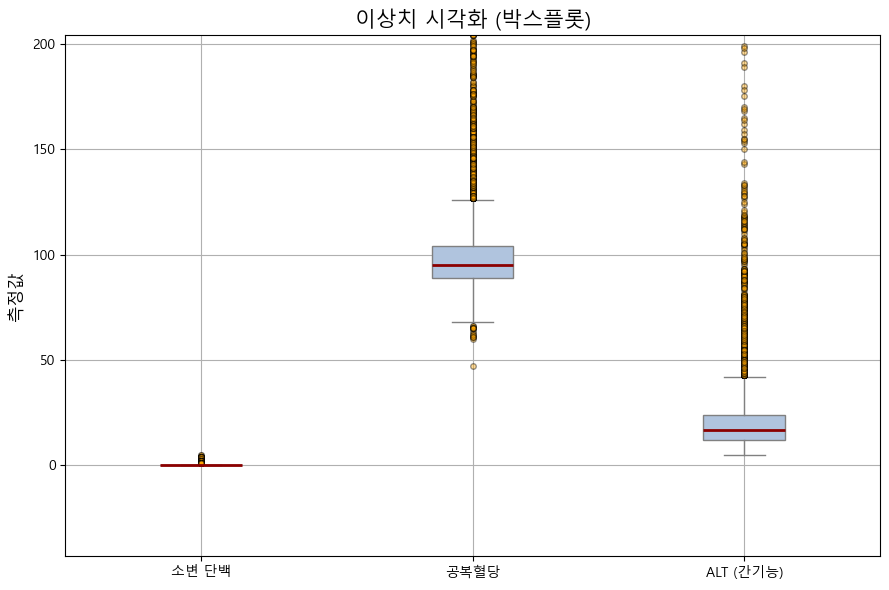

In [ ]:
import matplotlib.pyplot as plt

# 한글 폰트 설정 (Windows 사용자 기준, 필요시 주석 해제)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 시각화용 데이터 준비
columns_to_plot = ['HE_Upro', 'HE_glu', 'HE_alt']
column_labels = {
    'HE_Upro': 'HE_Upro(소변 단백)',
    'HE_glu': 'HE_glu(공복혈당)',
    'HE_alt': 'HE_alt(ALT (간기능))'
}
data_boxplot = data[columns_to_plot].copy()
data_boxplot.columns = [column_labels[col] for col in columns_to_plot]

# 박스플롯
plt.figure(figsize=(9, 6))
box = data_boxplot.boxplot(
    grid=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightsteelblue', color='gray'),
    medianprops=dict(color='darkred', linewidth=2),
    flierprops=dict(marker='o', markerfacecolor='orange', markersize=4, alpha=0.4),
    whiskerprops=dict(color='gray'),
    capprops=dict(color='gray')
)

# 제목 및 라벨
plt.title('이상치 시각화 (박스플롯)', fontsize=15)
plt.ylabel('측정값', fontsize=12)

# Y축 상한 설정 (너무 높은 이상치가 시야 가리는 경우)
plt.ylim(top=data_boxplot.quantile(0.95).max() * 1.5)

plt.tight_layout()
plt.show()


**타겟 변수** 분포 확인

In [76]:
data['당뇨 여부 (HbA1c)'].value_counts()

KeyError: '당뇨 여부 (HbA1c)'

In [13]:
data['HE_DM_HbA1c'].value_counts()

HE_DM_HbA1c
3.0    429
Name: count, dtype: int64

In [39]:
data['비만 여부'].value_counts()

비만 여부
2.0    4106
4.0    3228
3.0    2468
5.0     589
1.0     471
6.0     115
Name: count, dtype: int64

In [40]:
data['고혈압 여부'].value_counts()

고혈압 여부
1.0    4772
4.0    3803
3.0    1552
2.0     882
Name: count, dtype: int64

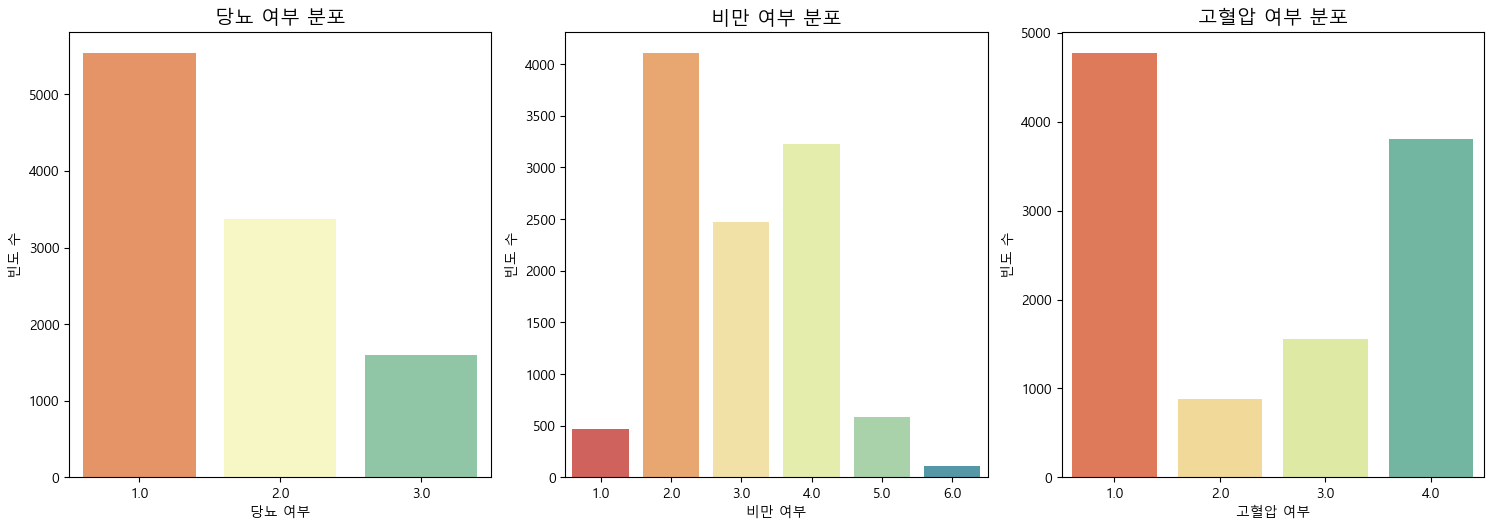

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 시각화할 변수 리스트
targets = ['HE_DM_HbA1c', 'HE_obe', 'HE_HP']
column_labels = {
    'HE_DM_HbA1c': 'HE_DM_HbA1c(당뇨 여부)',
    'HE_obe': 'HE_obe(비만 여부)',
    'HE_HP': 'HE_HP(고혈압 여부)'
}

# 서브플롯 설정 (2행 4열: 8개의 칸 중 3개 사용)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()  # 2차원 → 1차원 평탄화

# 각 변수에 대해 countplot 그리기
for i, var in enumerate(targets):
    sns.countplot(x=var, data=data, palette="Spectral", ax=axes[i])
    axes[i].set_title(f"{column_labels[var]} 분포", fontsize=14)
    axes[i].set_xlabel(column_labels[var])
    axes[i].set_ylabel('빈도 수')

# 사용하지 않는 subplot 숨기기
for j in range(len(targets), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [1]:
data = pd.read_csv("C:/건강검진/health_checkup/JDM/2022년~2023년/건강데이터_2022_2023_합본.csv")

NameError: name 'pd' is not defined

In [9]:
data = pd.read_csv("C:/건강검진/health_checkup/JDM/2022년~2023년/건강데이터_2022_2023_합본.csv")

In [ ]:
#data = pd.read_csv("C:/semi_project/health_checkup/JDM/선택컬럼_건강데이터.csv") # 당뇨 치료

이상치 처리

In [ ]:
# def iqr_clip(series, lower_quantile=0.25, upper_quantile=0.75, clip_range=1.5):
#     q1 = series.quantile(lower_quantile)
#     q3 = series.quantile(upper_quantile)
#     iqr = q3 - q1
#     lower_bound = q1 - clip_range * iqr
#     upper_bound = q3 + clip_range * iqr
#     return series.clip(lower=lower_bound, upper=upper_bound)

# # 적용
# data['HE_glu'] = iqr_clip(data['HE_glu'])
# data['HE_alt'] = iqr_clip(data['HE_alt'])

In [10]:
# 공복혈당: 50 이상 & 350 이하
data = data[(data['HE_glu'] >= 50) & (data['HE_glu'] <= 350)]

# ALT (간수치): 400 미만
data = data[data['HE_alt'] < 400]

결측치 처리

In [11]:
import pandas as pd

# 남기고 싶은 컬럼 리스트
columns_to_keep = [
    'ID','year','age','sex','HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1',
    'HE_Upro', 'HE_glu', 'HE_chol', 'HE_HDL_st2', 'HE_HbA1c',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt',
    # 'L_OUT_FQ', 
    # 'BP1','BD1_11', 'BS3_2', 'BE5_1', 
    'HE_obe', 'HE_HP', 'HE_DM_HbA1c',
    'DE1_dg', 'DI1_dg'
]

# 원래 데이터프레임이 df일 때
data = data[columns_to_keep]


In [ ]:
# data = data[data['DE1_3'].isin([1, 2])]

In [ ]:
# data = data[data['DI1_pt'].isin([0, 1])]

In [ ]:
# set(data['DE1_3'])

{1.0, 2.0}

In [ ]:
# import pandas as pd
# #당뇨 테스트
# # 남기고 싶은 컬럼 리스트
# columns_to_keep = [
#     'ID','year','age','sex','HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
#     'HE_sbp1', 'HE_dbp1',
#     'HE_Upro', 'HE_glu', 'HE_chol', 'HE_HDL_st2',
#     'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt',
#     # 'L_OUT_FQ', 
#     # 'BP1','BD1_11', 'BS3_2', 'BE5_1', 
#     'HE_obe', 'HE_HP', 'HE_DM_HbA1c',
#     'DE1_dg', 'DI1_dg', 'DE1_3', 'DI1_pt'
# ]

# # 원래 데이터프레임이 df일 때
# data = data[columns_to_keep]


1.결측치처리 샘플링

In [ ]:
# HE_DM_HbA1c
if 'HE_DM_HbA1c' in data.columns:
    data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DE1_dg' in data.columns:
        print(f"DE1_dg missing ratio: {data['DE1_dg'].isnull().mean()}")
        data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].fillna(data['DE1_dg'].map({0: 1, 1: 3}))
    # 남은 결측치는 클래스 비율 기반 랜덤 샘플링
    if data['HE_DM_HbA1c'].isnull().any():
        class_probs = data['HE_DM_HbA1c'].value_counts(normalize=True)
        data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].apply(
            lambda x: np.random.choice(class_probs.index, p=class_probs.values) if pd.isna(x) else x
        )
    print(f"HE_DM_HbA1c NaN count after: {data['HE_DM_HbA1c'].isnull().sum()}")

# HE_obe
if 'HE_obe' in data.columns:
    data['HE_obe'] = data['HE_obe'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'HE_BMI' in data.columns:
        # BMI가 KNN 대체된 경우 표시
        data['HE_BMI_imputed'] = data['HE_BMI'].isnull().astype(int)
        data['HE_obe'] = data.apply(
            lambda row: row['HE_obe'] if pd.notna(row['HE_obe']) else (
                1 if row['HE_BMI'] < 18.5 else
                2 if row['HE_BMI'] < 25 else
                3 if row['HE_BMI'] < 30 else
                4 if row['HE_BMI'] < 35 else
                5 if row['HE_BMI'] < 40 else
                6
            ),
            axis=1
        )
    # 남은 결측치는 클래스 비율 기반 랜덤 샘플링
    if data['HE_obe'].isnull().any():
        class_probs = data['HE_obe'].value_counts(normalize=True)
        data['HE_obe'] = data['HE_obe'].apply(
            lambda x: np.random.choice(class_probs.index, p=class_probs.values) if pd.isna(x) else x
        )
    print(f"HE_obe NaN count after: {data['HE_obe'].isnull().sum()}")

# HE_HP
if 'HE_HP' in data.columns:
    data['HE_HP'] = data['HE_HP'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DI1_dg' in data.columns:
        print(f"DI1_dg missing ratio: {data['DI1_dg'].isnull().mean()}")
        data['HE_HP'] = data['HE_HP'].fillna(data['DI1_dg'].map({0: 1, 1: 4}))
    # 남은 결측치는 클래스 비율 기반 랜덤 샘플링
    if data['HE_HP'].isnull().any():
        class_probs = data['HE_HP'].value_counts(normalize=True)
        data['HE_HP'] = data['HE_HP'].apply(
            lambda x: np.random.choice(class_probs.index, p=class_probs.values) if pd.isna(x) else x
        )
    print(f"HE_HP NaN count after: {data['HE_HP'].isnull().sum()}")


#결측치 비율 낮은 변수 처리
# low_missing_columns = [
#     'DI1_dg', 
#     'DE1_dg', 
# ]
continuous_columns = ['HE_wt', 'HE_ht', 'HE_BMI']  # 연속형 변수

#for col in low_missing_columns + continuous_columns:
for col in continuous_columns:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[col] = data[col].replace([9, 99, 999, 88, 888, 9.0, 99.0, 999.0, 88.0, 888.0], np.nan)
        if not data[col].isnull().all():
            if col in continuous_columns:
                median_value = data[col].median()
                data[col] = data[col].fillna(median_value)
                print(f"Median for {col}: {median_value}")
            else:
                mode_series = data[col].mode(dropna=True)
                if not mode_series.empty:
                    mode_value = mode_series[0]
                    data[col] = data[col].fillna(mode_value)
                    print(f"Mode for {col}: {mode_value}")
                else:
                    print(f"No valid mode for {col}, leaving as is.")
        else:
            print(f"Column {col} is all NaN, skipping.")

# data = data[data['DE1_3'].isin([1, 2])]

#생체 지표 결측치 처리
knn_columns = [
    'HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_chol',
    'HE_HDL_st2', 'HE_TG', 'HE_LDL_drct',  'HE_crea', 'HE_Upro',
    'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI'
]
knn_data = data[knn_columns].copy()
knn_data = knn_data.replace([888, 999, 888.0, 999.0], np.nan)

# 스케일링
scaler = StandardScaler()
knn_data_scaled = scaler.fit_transform(knn_data)
knn_data_scaled = pd.DataFrame(knn_data_scaled, columns=knn_columns, index=knn_data.index)

# KNN Imputation
imputer_knn = KNNImputer(n_neighbors=5, weights="distance")
knn_imputed = imputer_knn.fit_transform(knn_data_scaled)

# 역스케일링
knn_imputed = scaler.inverse_transform(knn_imputed)
knn_imputed_data = pd.DataFrame(knn_imputed, columns=knn_columns, index=knn_data.index)
data[knn_columns] = knn_imputed_data

# knn_scaler_filename = 'HE_DM_HbA1c_knn_scaler.pkl'
# knn_imputer_filename = 'HE_DM_HbA1c_knn_imputer.pkl'
# joblib.dump(knn_data_scaled, knn_scaler_filename)
# joblib.dump(imputer_knn, knn_imputer_filename)
# knn_scaler_filename = 'HE_obe_knn_scaler.pkl'
# knn_imputer_filename = 'HE_obe_knn_imputer.pkl'
# joblib.dump(knn_data_scaled, knn_scaler_filename)
# joblib.dump(imputer_knn, knn_imputer_filename)
# knn_scaler_filename = 'HE_HP_knn_scaler.pkl'
# knn_imputer_filename = 'HE_HP_knn_imputer.pkl'
# joblib.dump(knn_data_scaled, knn_scaler_filename)
# joblib.dump(imputer_knn, knn_imputer_filename)

print("결측치 처리 후 데이터 상태:")
print(data.isnull().sum())
print("\n타겟 변수 클래스 비율:")
for target in ['HE_DM_HbA1c', 'HE_obe', 'HE_HP']:
    if target in data.columns:
        print(f"\n{target}:\n{data[target].value_counts(normalize=True)}")
print("\n기본 통계량:")
print(data.describe())

DE1_dg missing ratio: 8.541168431841476e-05
HE_DM_HbA1c NaN count after: 0
HE_obe NaN count after: 0
DI1_dg missing ratio: 8.541168431841476e-05
HE_HP NaN count after: 0
Median for HE_wt: 62.2
Median for HE_ht: 162.9
Median for HE_BMI: 23.57063727687619
결측치 처리 후 데이터 상태:
ID                 0
year               0
age                0
sex                0
HE_ht              0
HE_wt              0
HE_wc              0
HE_BMI             0
HE_sbp1            0
HE_dbp1            0
HE_Upro            0
HE_glu             0
HE_chol            0
HE_HDL_st2         0
HE_HbA1c          34
HE_TG              0
HE_LDL_drct        0
HE_crea            0
HE_ast             0
HE_alt             0
HE_obe             0
HE_HP              0
HE_DM_HbA1c        0
DE1_dg             1
DI1_dg             1
HE_BMI_imputed     0
dtype: int64

타겟 변수 클래스 비율:

HE_DM_HbA1c:
HE_DM_HbA1c
1.0    0.536300
2.0    0.311923
3.0    0.151777
Name: proportion, dtype: float64

HE_obe:
HE_obe
2.0    0.382815
4.0    0.268364


2.결측치처리 드랍

In [12]:
# HE_DM_HbA1c
if 'HE_DM_HbA1c' in data.columns:
    data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DE1_dg' in data.columns:
        print(f"DE1_dg missing ratio: {data['DE1_dg'].isnull().mean()}")
        data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].fillna(data['DE1_dg'].map({0: 1, 1: 3}))
    # 남은 결측치는 드랍랍
    if data['HE_DM_HbA1c'].isnull().any():
        data = data[data['HE_DM_HbA1c'].notnull()]
    print(f"HE_DM_HbA1c NaN count after: {data['HE_DM_HbA1c'].isnull().sum()}")

# HE_obe
if 'HE_obe' in data.columns:
    data['HE_obe'] = data['HE_obe'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'HE_BMI' in data.columns:
        # BMI가 KNN 대체된 경우 표시
        data['HE_BMI_imputed'] = data['HE_BMI'].isnull().astype(int)
        data['HE_obe'] = data.apply(
            lambda row: row['HE_obe'] if pd.notna(row['HE_obe']) else (
                1 if row['HE_BMI'] < 18.5 else
                2 if row['HE_BMI'] < 25 else
                3 if row['HE_BMI'] < 30 else
                4 if row['HE_BMI'] < 35 else
                5 if row['HE_BMI'] < 40 else
                6
            ),
            axis=1
        )
    # 남은 결측치는 드랍랍
    if data['HE_obe'].isnull().any():
        data = data[data['HE_obe'].notnull()]
    print(f"HE_obe NaN count after: {data['HE_obe'].isnull().sum()}")

# HE_HP
if 'HE_HP' in data.columns:
    data['HE_HP'] = data['HE_HP'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DI1_dg' in data.columns:
        print(f"DI1_dg missing ratio: {data['DI1_dg'].isnull().mean()}")
        data['HE_HP'] = data['HE_HP'].fillna(data['DI1_dg'].map({0: 1, 1: 4}))
    # 남은 결측치는 드랍랍
    if data['HE_HP'].isnull().any():
        data = data[data['HE_HP'].notnull()]
    print(f"HE_HP NaN count after: {data['HE_HP'].isnull().sum()}")


#결측치 비율 낮은 변수 처리
# low_missing_columns = [
#     'DI1_dg', 
#     'DE1_dg', 
# ]
continuous_columns = ['HE_wt', 'HE_ht', 'HE_BMI']  # 연속형 변수

#for col in low_missing_columns + continuous_columns:
for col in continuous_columns:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[col] = data[col].replace([9, 99, 999, 88, 888, 9.0, 99.0, 999.0, 88.0, 888.0], np.nan)
        if not data[col].isnull().all():
            if col in continuous_columns:
                median_value = data[col].median()
                data[col] = data[col].fillna(median_value)
                print(f"Median for {col}: {median_value}")
            else:
                mode_series = data[col].mode(dropna=True)
                if not mode_series.empty:
                    mode_value = mode_series[0]
                    data[col] = data[col].fillna(mode_value)
                    print(f"Mode for {col}: {mode_value}")
                else:
                    print(f"No valid mode for {col}, leaving as is.")
        else:
            print(f"Column {col} is all NaN, skipping.")

# data = data[data['DE1_3'].isin([1, 2])]

#생체 지표 결측치 처리
knn_columns = [
    'HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_chol',
    'HE_HDL_st2', 'HE_TG', 'HE_LDL_drct',  'HE_crea', 'HE_Upro', 'HE_HbA1c',
    'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI'
]
knn_data = data[knn_columns].copy()
knn_data = knn_data.replace([888, 999, 888.0, 999.0], np.nan)

# 스케일링
scaler = StandardScaler()
knn_data_scaled = scaler.fit_transform(knn_data)
knn_data_scaled = pd.DataFrame(knn_data_scaled, columns=knn_columns, index=knn_data.index)

# KNN Imputation
imputer_knn = KNNImputer(n_neighbors=5, weights="distance")
knn_imputed = imputer_knn.fit_transform(knn_data_scaled)

# 역스케일링
knn_imputed = scaler.inverse_transform(knn_imputed)
knn_imputed_data = pd.DataFrame(knn_imputed, columns=knn_columns, index=knn_data.index)
data[knn_columns] = knn_imputed_data

# knn_scaler_filename = 'HE_DM_HbA1c_knn_scaler.pkl'
# knn_imputer_filename = 'HE_DM_HbA1c_knn_imputer.pkl'
# joblib.dump(knn_data_scaled, knn_scaler_filename)
# joblib.dump(imputer_knn, knn_imputer_filename)
# knn_scaler_filename = 'HE_obe_knn_scaler.pkl'
# knn_imputer_filename = 'HE_obe_knn_imputer.pkl'
# joblib.dump(knn_data_scaled, knn_scaler_filename)
# joblib.dump(imputer_knn, knn_imputer_filename)
# knn_scaler_filename = 'HE_HP_knn_scaler.pkl'
# knn_imputer_filename = 'HE_HP_knn_imputer.pkl'
# joblib.dump(knn_data_scaled, knn_scaler_filename)
# joblib.dump(imputer_knn, knn_imputer_filename)

print("결측치 처리 후 데이터 상태:")
print(data.isnull().sum())
print("\n타겟 변수 클래스 비율:")
for target in ['HE_DM_HbA1c', 'HE_obe', 'HE_HP']:
    if target in data.columns:
        print(f"\n{target}:\n{data[target].value_counts(normalize=True)}")
print("\n기본 통계량:")
print(data.describe())

data.to_csv("건강데이터_2022_2023_합본(가공된).csv", index=False, encoding='utf-8-sig')

DE1_dg missing ratio: 8.541168431841476e-05
HE_DM_HbA1c NaN count after: 0
HE_obe NaN count after: 0
DI1_dg missing ratio: 0.0
HE_HP NaN count after: 0
Median for HE_wt: 62.8
Median for HE_ht: 163.0
Median for HE_BMI: 23.74976543441547
결측치 처리 후 데이터 상태:
ID                0
year              0
age               0
sex               0
HE_ht             0
HE_wt             0
HE_wc             0
HE_BMI            0
HE_sbp1           0
HE_dbp1           0
HE_Upro           0
HE_glu            0
HE_chol           0
HE_HDL_st2        0
HE_HbA1c          0
HE_TG             0
HE_LDL_drct       0
HE_crea           0
HE_ast            0
HE_alt            0
HE_obe            0
HE_HP             0
HE_DM_HbA1c       0
DE1_dg            0
DI1_dg            0
HE_BMI_imputed    0
dtype: int64

타겟 변수 클래스 비율:

HE_DM_HbA1c:
HE_DM_HbA1c
1.0    0.538042
2.0    0.310803
3.0    0.151154
Name: proportion, dtype: float64

HE_obe:
HE_obe
2.0    0.368052
4.0    0.288089
3.0    0.221422
5.0    0.053093
1.0    0.041

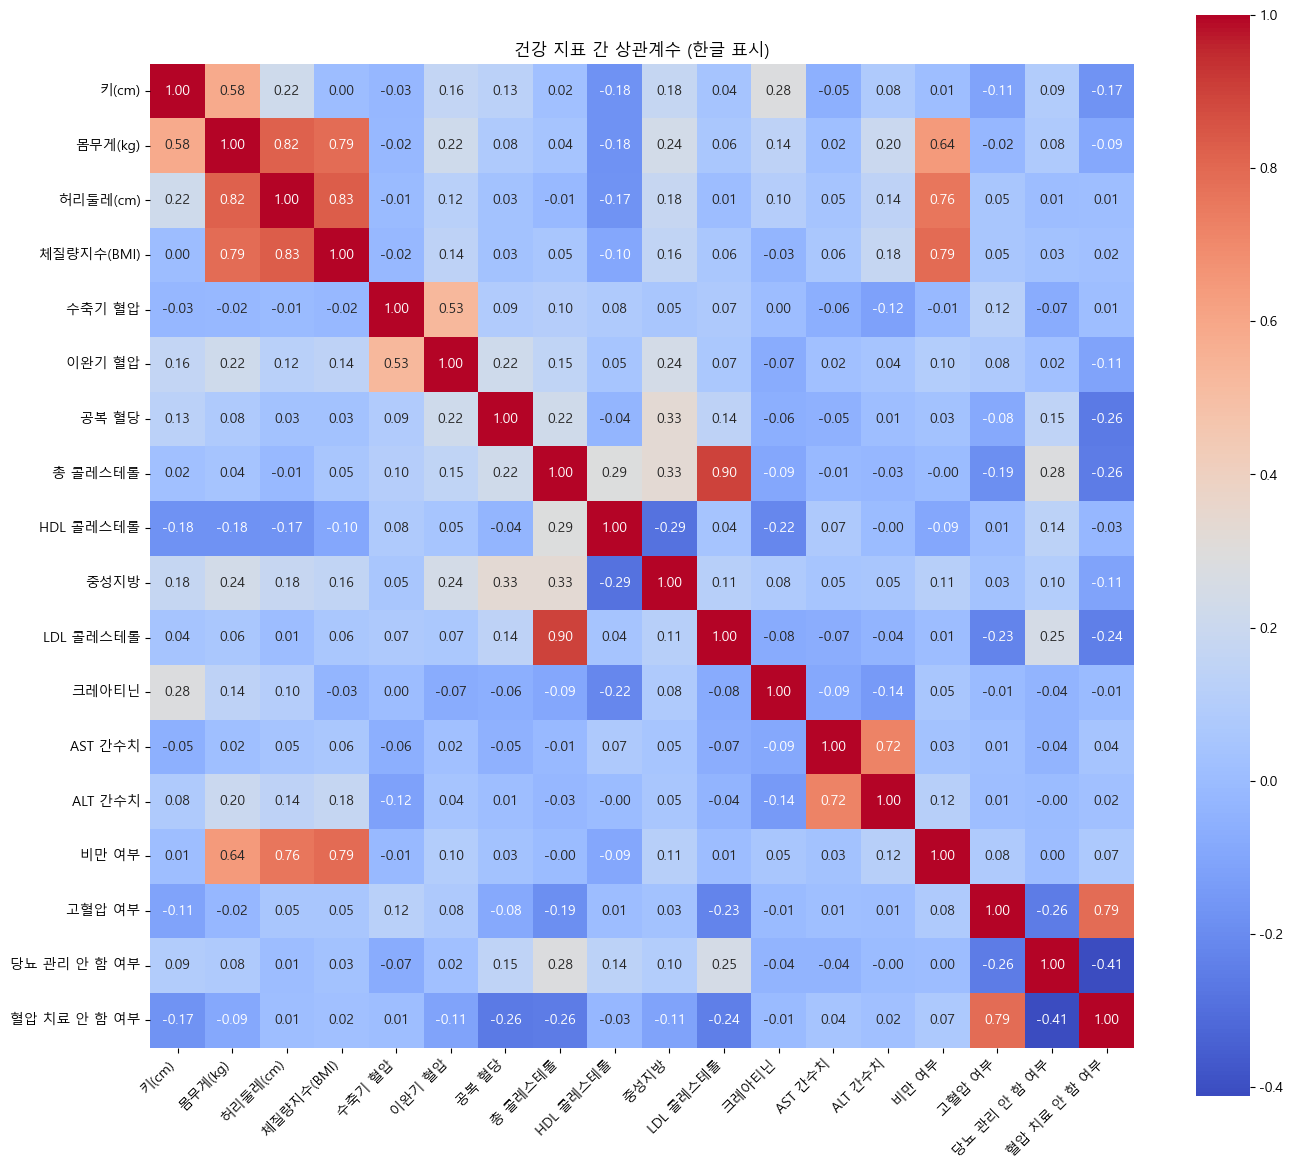

In [ ]:
column_name_map = {
    'HE_ht': '키(cm)',
    'HE_wt': '몸무게(kg)',
    'HE_wc': '허리둘레(cm)',
    'HE_BMI': '체질량지수(BMI)',
    'HE_sbp1': '수축기 혈압',
    'HE_dbp1': '이완기 혈압',
    'HE_glu': '공복 혈당',
    'HE_chol': '총 콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤',
    'HE_TG': '중성지방',
    'HE_LDL_drct': 'LDL 콜레스테롤',
    'HE_crea': '크레아티닌',
    'HE_ast': 'AST 간수치',
    'HE_alt': 'ALT 간수치',
    'HE_obe': '비만 여부',
    'HE_HP': '고혈압 여부',
    'DE1_3': '당뇨 관리 안 함 여부',
    'DI1_pt' : '혈압 치료 안 함 여부'
}


correlation_columns = [
    'HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI',
    'HE_sbp1', 'HE_dbp1', 'HE_glu', 'HE_chol', 'HE_HDL_st2',
    'HE_TG', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt', 'DE1_3', 'DI1_pt'
]

import seaborn as sns
import matplotlib.pyplot as plt

# 보고 싶은 변수만 추출
selected_columns = list(column_name_map.keys())
correlation_matrix = data[selected_columns].corr()

# 컬럼명을 한글로 변환
correlation_matrix.columns = [column_name_map[col] for col in correlation_matrix.columns]
correlation_matrix.index = [column_name_map[col] for col in correlation_matrix.index]

# 히트맵 시각화
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("건강 지표 간 상관계수 (한글 표시)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**타겟변수와 독립변수의 상관관계 확인**

📊 타겟 변수 상관 분석 - 당뇨병 (HbA1c)


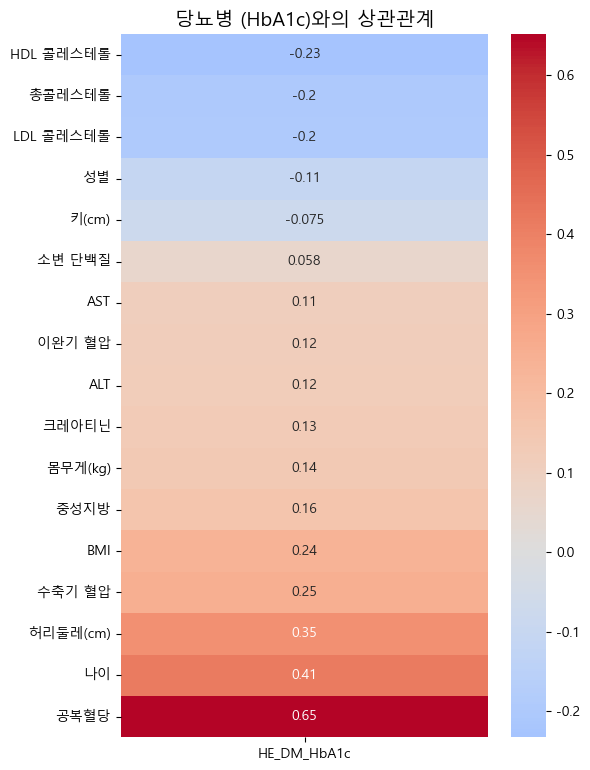

📊 타겟 변수 상관 분석 - 비만도


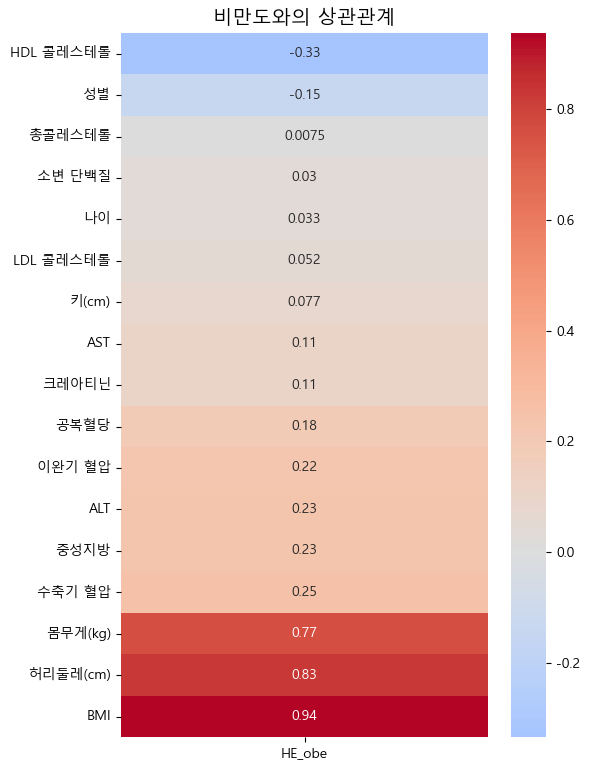

📊 타겟 변수 상관 분석 - 고혈압


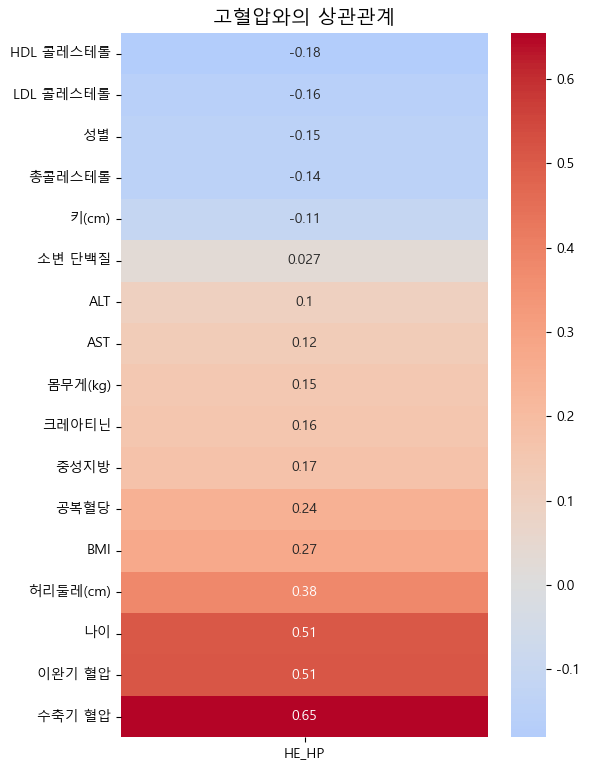

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 변수 이름 -> 한글 매핑 사전
feature_name_ko = {
    'HE_ht': '키(cm)', 'HE_wt': '몸무게(kg)', 'HE_wc': '허리둘레(cm)', 'HE_BMI': 'BMI',
    'HE_sbp1': '수축기 혈압', 'HE_dbp1': '이완기 혈압',
    'HE_Upro': '소변 단백질', 'HE_glu': '공복혈당', 'HE_chol': '총콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤', 'HE_TG': '중성지방', 'HE_LDL_drct': 'LDL 콜레스테롤',
    'HE_crea': '크레아티닌', 'HE_ast': 'AST', 'HE_alt': 'ALT',
    'sex': '성별', 'age': '나이',
    'BS3_2': '1주일간 운동 횟수',
    'BE5_1': '스트레스 인지 정도',
    'L_OUT_FQ': '외식 빈도'
}

# 타겟 이름 -> 한글 매핑
target_name_ko = {
    'HE_DM_HbA1c': '당뇨병 (HbA1c)',
    'HE_obe': '비만도',
    'HE_HP': '고혈압'
}

# 제외할 컬럼
exclude_cols = ['year', 'ID', 'DE1_dg', 'DI1_dg'] + list(target_name_ko.keys())

# input features 자동 지정
input_features = [col for col in data.columns if col not in exclude_cols]

for target in target_name_ko.keys():
    print(f"📊 타겟 변수 상관 분석 - {target_name_ko[target]}")
    
    # 수치형 변수만 포함한 데이터프레임
    subset = data[input_features + [target]].copy()
    subset = subset.select_dtypes(include='number')

    # 상관계수 계산
    corr_with_target = subset.corr()[[target]].drop(index=target)
    corr_with_target = corr_with_target.sort_values(by=target, ascending=True)

    # 한글 라벨로 인덱스 변환
    corr_with_target.index = [feature_name_ko.get(col, col) for col in corr_with_target.index]

    # 시각화
    plt.figure(figsize=(6, len(corr_with_target) * 0.4 + 1))
    sns.heatmap(corr_with_target, annot=True, cmap='coolwarm', center=0)
    plt.title(f"{target_name_ko[target]}와의 상관관계", fontsize=14)
    plt.tight_layout()
    plt.show()


📊 타겟 변수 상관 분석 - 당뇨병 (HbA1c)


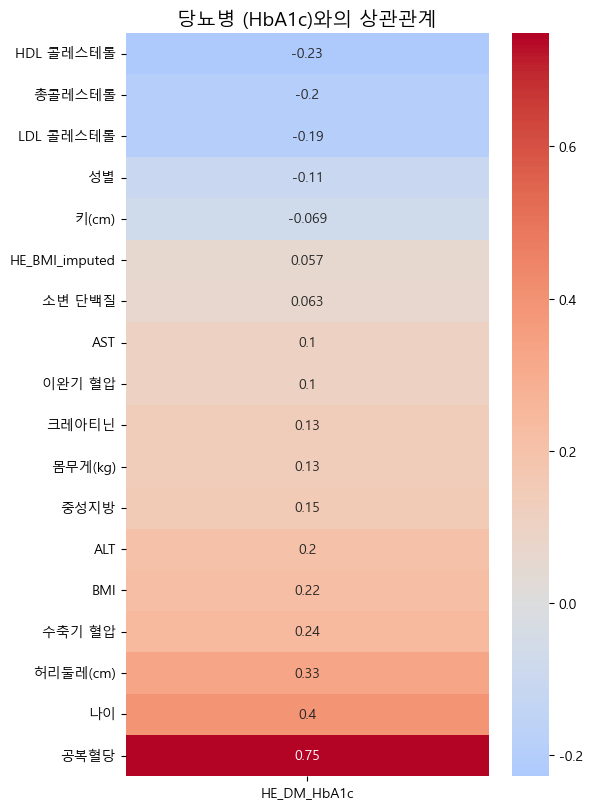

📊 타겟 변수 상관 분석 - 비만도


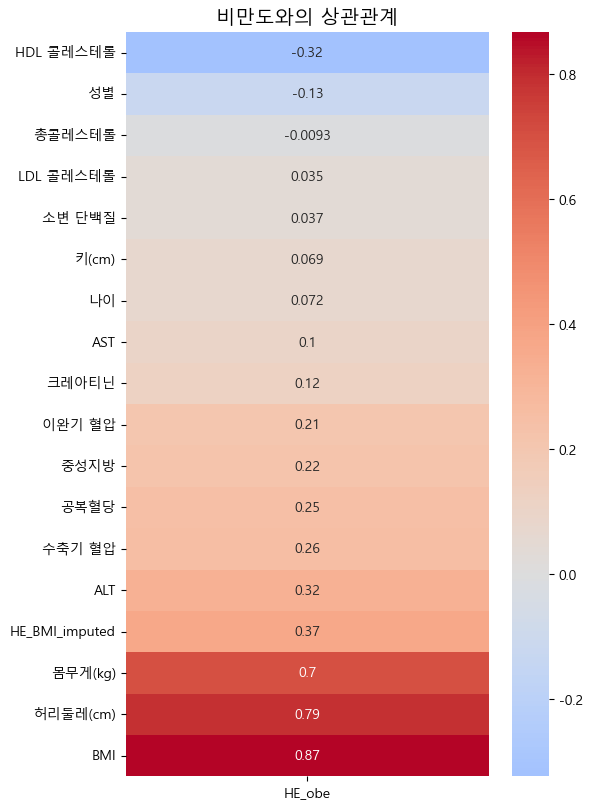

📊 타겟 변수 상관 분석 - 고혈압


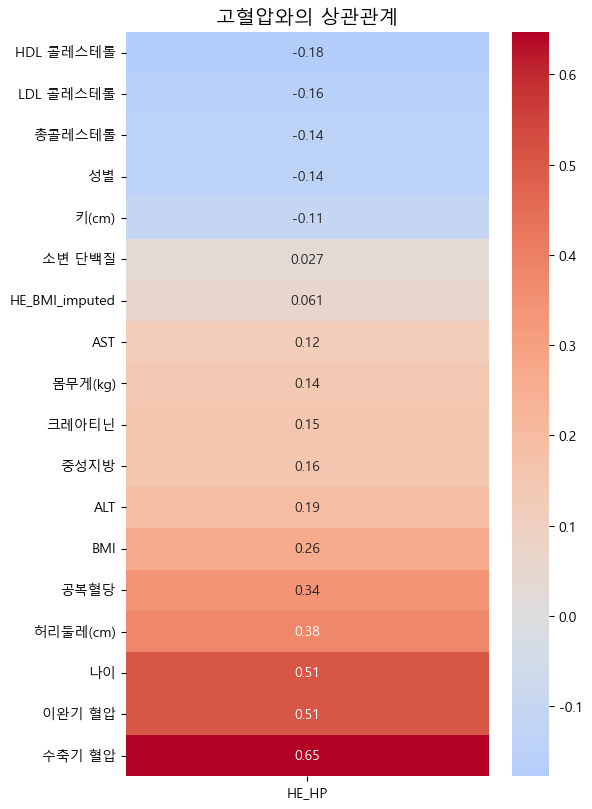

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 변수 이름 -> 한글 매핑 사전
feature_name_ko = {
    'HE_ht': 'HE_ht(키(cm))', 'HE_wt': 'HE_wt(몸무게(kg))', 'HE_wc': 'HE_wc(허리둘레(cm))', 'HE_BMI': 'BMI',
    'HE_sbp1': 'HE_sbp1(수축기 혈압)', 'HE_dbp1': '이완기 혈압',
    'HE_Upro': '소변 단백질', 'HE_glu': '공복혈당', 'HE_chol': '총콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤', 'HE_TG': '중성지방', 'HE_LDL_drct': 'LDL 콜레스테롤',
    'HE_crea': '크레아티닌', 'HE_ast': 'AST', 'HE_alt': 'ALT',
    'sex': '성별', 'age': '나이',
    'BS3_2': '1주일간 운동 횟수',
    'BE5_1': '스트레스 인지 정도',
    'L_OUT_FQ': '외식 빈도',
    'DE1_3': '당뇨 관리 안 함 여부',
    'DI1_pt' : '혈압 치료 안 함 여부'
}

# 타겟 이름 -> 한글 매핑
target_name_ko = {
    'HE_DM_HbA1c': '당뇨병 (HbA1c)',
    'HE_obe': '비만도',
    'HE_HP': '고혈압'
}

# 제외할 컬럼
exclude_cols = ['year', 'ID', 'DE1_dg', 'DI1_dg'] + list(target_name_ko.keys())

# input features 자동 지정
input_features = [col for col in data.columns if col not in exclude_cols]

for target in target_name_ko.keys():
    print(f"📊 타겟 변수 상관 분석 - {target_name_ko[target]}")
    
    # 수치형 변수만 포함한 데이터프레임
    subset = data[input_features + [target]].copy()
    subset = subset.select_dtypes(include='number')

    # 상관계수 계산
    corr_with_target = subset.corr()[[target]].drop(index=target)
    corr_with_target = corr_with_target.sort_values(by=target, ascending=True)

    # 한글 라벨로 인덱스 변환
    corr_with_target.index = [feature_name_ko.get(col, col) for col in corr_with_target.index]

    # 시각화
    plt.figure(figsize=(6, len(corr_with_target) * 0.4 + 1))
    sns.heatmap(corr_with_target, annot=True, cmap='coolwarm', center=0)
    plt.title(f"{target_name_ko[target]}와의 상관관계", fontsize=14)
    plt.tight_layout()
    plt.show()


In [50]:
# 타입 확인
print(data['HE_DM_HbA1c'].dtype)

# 결측치 확인
print(data['HE_DM_HbA1c'].isna().sum())

float64
0


In [51]:
print(data['HE_DM_HbA1c'].value_counts())

HE_DM_HbA1c
3.0    471
Name: count, dtype: int64


In [18]:
import pandas as pd

# 예: 80세 이상은 80으로 표기되어 있으므로 그대로 사용 가능
bins = [0, 19, 29, 39, 49, 59, 69, 79, 120]  # 80세 이상 포함
labels = ['10대 이하', '20대', '30대', '40대', '50대', '60대', '70대', '80세 이상']

data['AGE_GROUP'] = pd.cut(data['age'], bins=bins, labels=labels, right=True)

In [19]:
group_stats = data.groupby('AGE_GROUP')['HE_DM_HbA1c'].mean().reset_index()

**나이 그룹별 질병 유병률 확인**

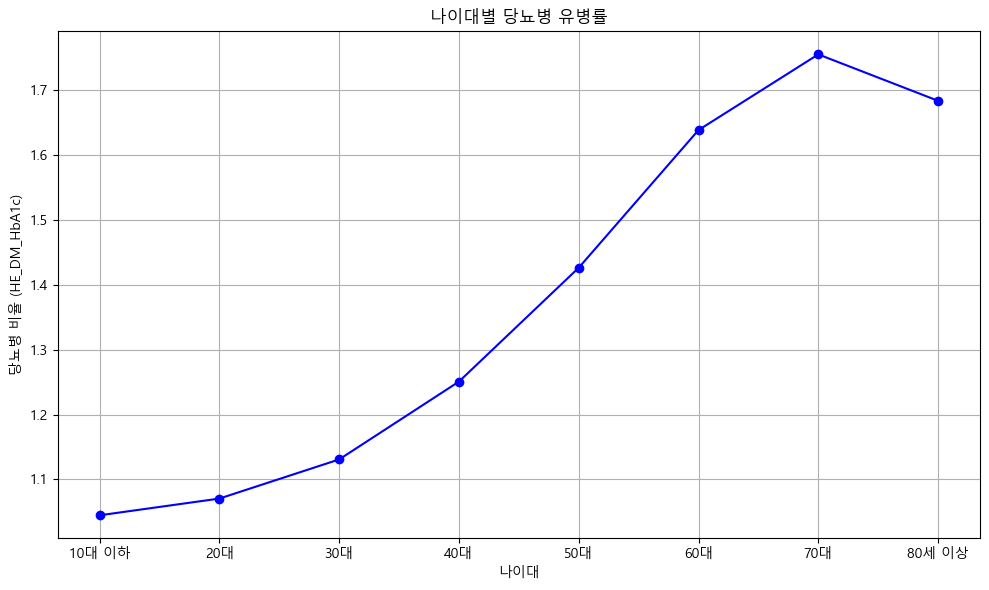

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 나이 그룹 생성 (AGE_GROUP 컬럼 추가)
bins = [0, 19, 29, 39, 49, 59, 69, 79, 120]  # 80세 이상 포함
labels = ['10대 이하', '20대', '30대', '40대', '50대', '60대', '70대', '80세 이상']

data['AGE_GROUP'] = pd.cut(data['age'], bins=bins, labels=labels, right=True)

# 2. 나이그룹별 당뇨병 평균값(= 유병률) 계산
group_stats = data.groupby('AGE_GROUP')['HE_DM_HbA1c'].mean().reset_index()

# 3. 시각화
plt.figure(figsize=(10, 6))
plt.plot(group_stats['AGE_GROUP'], group_stats['HE_DM_HbA1c'], marker='o', color='blue')
plt.xlabel('나이대')
plt.ylabel('당뇨병 비율 (HE_DM_HbA1c)')
plt.title('나이대별 당뇨병 유병률')
plt.grid(True)
plt.tight_layout()
plt.show()

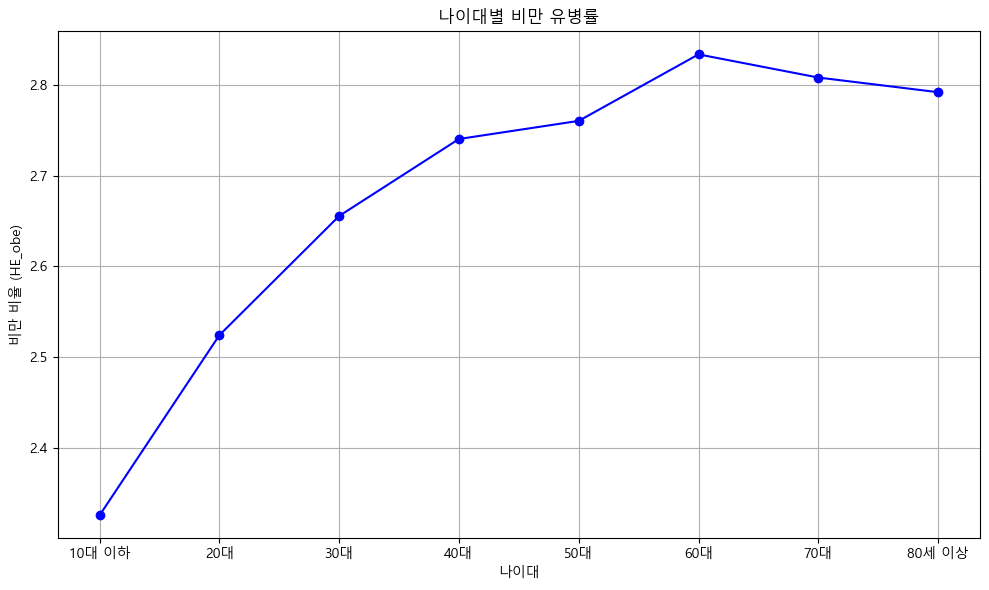

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 나이 그룹 생성 (AGE_GROUP 컬럼 추가)
bins = [0, 19, 29, 39, 49, 59, 69, 79, 120]  # 80세 이상 포함
labels = ['10대 이하', '20대', '30대', '40대', '50대', '60대', '70대', '80세 이상']

data['AGE_GROUP'] = pd.cut(data['age'], bins=bins, labels=labels, right=True)

# 2. 나이그룹별 당뇨병 평균값(= 유병률) 계산
group_stats = data.groupby('AGE_GROUP')['HE_obe'].mean().reset_index()

# 3. 시각화
plt.figure(figsize=(10, 6))
plt.plot(group_stats['AGE_GROUP'], group_stats['HE_obe'], marker='o', color='blue')
plt.xlabel('나이대')
plt.ylabel('비만 비율 (HE_obe)')
plt.title('나이대별 비만 유병률')
plt.grid(True)
plt.tight_layout()
plt.show()

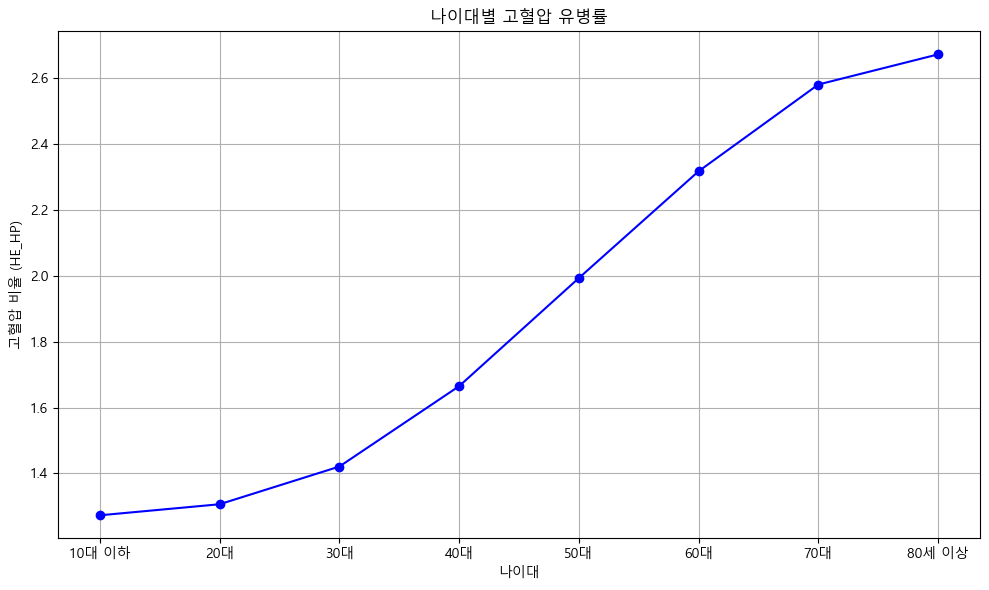

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 나이 그룹 생성 (AGE_GROUP 컬럼 추가)
bins = [0, 19, 29, 39, 49, 59, 69, 79, 120]  # 80세 이상 포함
labels = ['10대 이하', '20대', '30대', '40대', '50대', '60대', '70대', '80세 이상']

data['AGE_GROUP'] = pd.cut(data['age'], bins=bins, labels=labels, right=True)

# 2. 나이그룹별 당뇨병 평균값(= 유병률) 계산
group_stats = data.groupby('AGE_GROUP')['HE_HP'].mean().reset_index()

# 3. 시각화
plt.figure(figsize=(10, 6))
plt.plot(group_stats['AGE_GROUP'], group_stats['HE_HP'], marker='o', color='blue')
plt.xlabel('나이대')
plt.ylabel('고혈압 비율 (HE_HP)')
plt.title('나이대별 고혈압 유병률')
plt.grid(True)
plt.tight_layout()
plt.show()

In [63]:
# 근력운동 그룹화
def map_strength_exercise(val):
    if val == 1:
        return '운동 안 함'
    elif val in [2, 3]:
        return '주 1~2회'
    elif val in [4, 5]:
        return '주 3~4회'
    elif val == 6:
        return '주 5회 이상'
    else:
        return '모름'

data['BE5_1_GROUP'] = data['BE5_1'].apply(map_strength_exercise)

In [64]:
data

,HE_ht,HE_wt,HE_wc,HE_BMI,HE_sbp1,HE_dbp1,HE_Upro,HE_glu,HE_chol,HE_HDL_st2,HE_TG,HE_LDL_drct,HE_crea,HE_ast,HE_alt,sex,age,year,ID,L_BR_FQ,L_LN_FQ,L_DN_FQ,L_OUT_FQ,BE5_1,LS_VEG1,LS_FRUIT,HE_obe,HE_HP,HE_DM_HbA1c,DE1_dg,DI1_dg,HE_BMI_imputed,BE5_1_GROUP,AGE_GROUP
0,151.2,60.6,84.3,26.507517,135.0,90.0,0.0,94.0,199.0,56.0,181.0,122.0,0.61,22.0,16.0,2.0,56.0,2022.0,YA01220302,3.0,1.0,1.0,5.0,1.0,2.0,2.0,4.0,4.0,1.0,0.0,1.0,0,운동 안 함,50대
1,174.1,82.3,86.2,27.152029,145.0,77.0,0.0,84.0,122.0,48.0,63.0,63.0,0.86,28.0,18.0,1.0,30.0,2022.0,YA01220303,1.0,1.0,1.0,4.0,6.0,2.0,3.0,4.0,3.0,1.0,0.0,0.0,0,주 5회 이상,30대
2,166.4,59.0,69.4,21.308131,103.0,64.0,0.0,87.0,202.0,75.0,53.0,124.0,0.60,17.0,15.0,2.0,25.0,2022.0,YA01220304,4.0,1.0,2.0,3.0,6.0,2.0,2.0,2.0,1.0,1.0,0.0,0.0,0,주 5회 이상,20대
3,168.7,67.1,83.5,23.577207,116.0,80.0,0.0,87.0,136.0,47.0,123.0,74.0,0.90,20.0,15.0,1.0,66.0,2022.0,YA01236501,1.0,1.0,1.0,4.0,1.0,1.0,2.0,3.0,2.0,1.0,0.0,0.0,0,운동 안 함,60대
4,157.1,53.9,77.5,21.839183,145.0,89.0,0.0,91.0,149.0,53.0,110.0,82.0,0.67,26.0,23.0,2.0,62.0,2022.0,YA01236502,1.0,1.0,1.0,6.0,4.0,1.0,2.0,2.0,3.0,1.0,0.0,0.0,0,주 3~4회,60대
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13189,162.4,63.3,97.0,24.001128,117.0,68.0,0.0,101.0,193.0,38.0,188.0,124.0,1.44,18.0,12.0,1.0,80.0,2023.0,YR62368101,1.0,1.0,1.0,5.0,1.0,1.0,5.0,3.0,4.0,3.0,1.0,1.0,0,운동 안 함,80세 이상
13190,157.3,71.7,97.0,28.977553,136.0,82.0,0.0,104.0,223.0,71.0,110.0,150.0,0.68,17.0,13.0,2.0,78.0,2023.0,YR62368102,1.0,1.0,1.0,5.0,5.0,1.0,3.0,4.0,4.0,2.0,0.0,1.0,0,주 3~4회,70대
13191,145.1,40.2,66.3,19.093750,127.0,81.0,0.0,90.0,178.0,46.0,91.0,123.0,0.60,18.0,11.0,2.0,61.0,2023.0,YR62370201,1.0,2.0,1.0,6.0,1.0,2.0,2.0,2.0,3.0,2.0,0.0,0.0,0,운동 안 함,60대
13192,172.8,74.4,87.6,24.916409,142.0,87.0,0.0,111.0,261.0,36.0,167.0,201.0,1.03,22.0,19.0,1.0,57.0,2023.0,YR62394401,1.0,1.0,1.0,2.0,6.0,1.0,3.0,3.0,3.0,2.0,0.0,0.0,0,주 5회 이상,50대


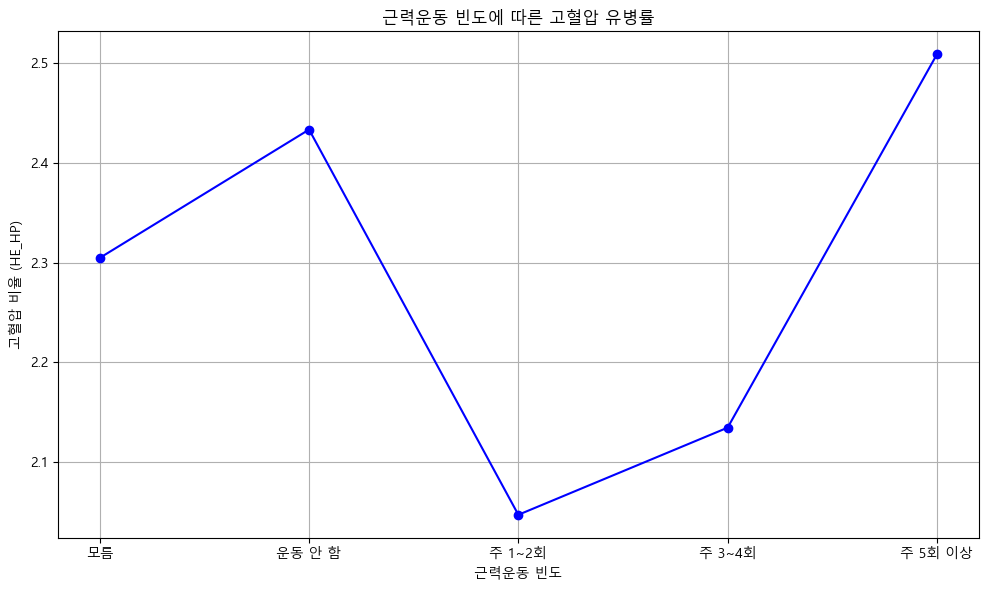

In [65]:
# BE5_1 그룹화 (방법 1 예시 사용)
def map_strength_exercise(val):
    if val == 1:
        return '운동 안 함'
    elif val in [2, 3]:
        return '주 1~2회'
    elif val in [4, 5]:
        return '주 3~4회'
    elif val == 6:
        return '주 5회 이상'
    else:
        return '모름'

data['BE5_1_GROUP'] = data['BE5_1'].apply(map_strength_exercise)

# 운동 그룹별 고혈압 비율 평균 계산 (예: HE_HP 변수)
group_stats = data.groupby('BE5_1_GROUP')['HE_HP'].mean().reset_index()

# 선 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(group_stats['BE5_1_GROUP'], group_stats['HE_HP'], marker='o', color='blue')
plt.xlabel('근력운동 빈도')
plt.ylabel('고혈압 비율 (HE_HP)')
plt.title('근력운동 빈도에 따른 고혈압 유병률')
plt.grid(True)
plt.tight_layout()
plt.show()


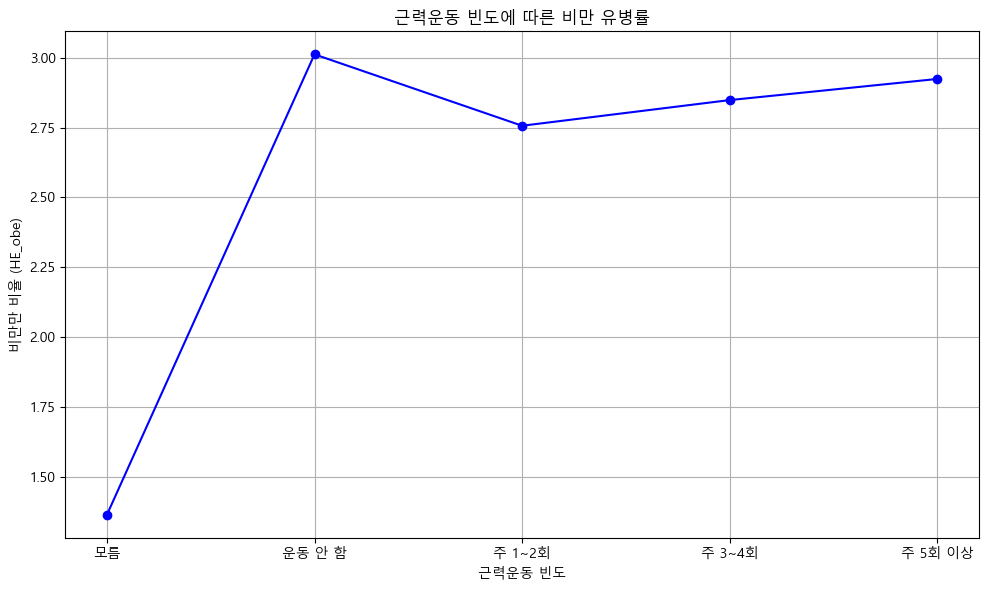

In [66]:
# BE5_1 그룹화 (방법 1 예시 사용)
def map_strength_exercise(val):
    if val == 1:
        return '운동 안 함'
    elif val in [2, 3]:
        return '주 1~2회'
    elif val in [4, 5]:
        return '주 3~4회'
    elif val == 6:
        return '주 5회 이상'
    else:
        return '모름'

data['BE5_1_GROUP'] = data['BE5_1'].apply(map_strength_exercise)

# 운동 그룹별 고혈압 비율 평균 계산 (예: HE_HP 변수)
group_stats = data.groupby('BE5_1_GROUP')['HE_obe'].mean().reset_index()

# 선 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(group_stats['BE5_1_GROUP'], group_stats['HE_obe'], marker='o', color='blue')
plt.xlabel('근력운동 빈도')
plt.ylabel('비만만 비율 (HE_obe)')
plt.title('근력운동 빈도에 따른 비만 유병률')
plt.grid(True)
plt.tight_layout()
plt.show()


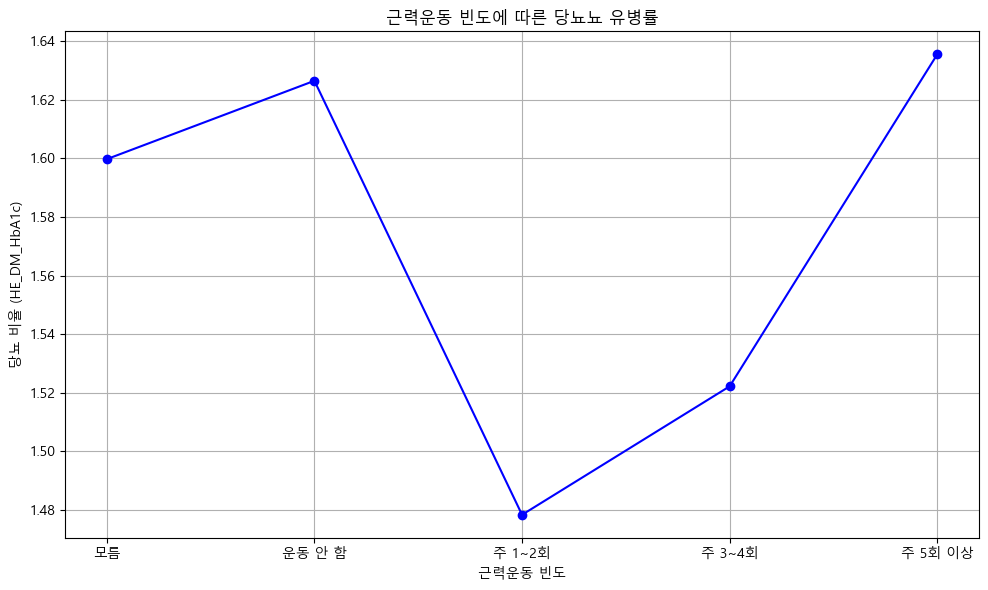

In [67]:
# BE5_1 그룹화 (방법 1 예시 사용)
def map_strength_exercise(val):
    if val == 1:
        return '운동 안 함'
    elif val in [2, 3]:
        return '주 1~2회'
    elif val in [4, 5]:
        return '주 3~4회'
    elif val == 6:
        return '주 5회 이상'
    else:
        return '모름'

data['BE5_1_GROUP'] = data['BE5_1'].apply(map_strength_exercise)

# 운동 그룹별 고혈압 비율 평균 계산 (예: HE_HP 변수)
group_stats = data.groupby('BE5_1_GROUP')['HE_DM_HbA1c'].mean().reset_index()

# 선 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(group_stats['BE5_1_GROUP'], group_stats['HE_DM_HbA1c'], marker='o', color='blue')
plt.xlabel('근력운동 빈도')
plt.ylabel('당뇨 비율 (HE_DM_HbA1c)')
plt.title('근력운동 빈도에 따른 당뇨뇨 유병률')
plt.grid(True)
plt.tight_layout()
plt.show()


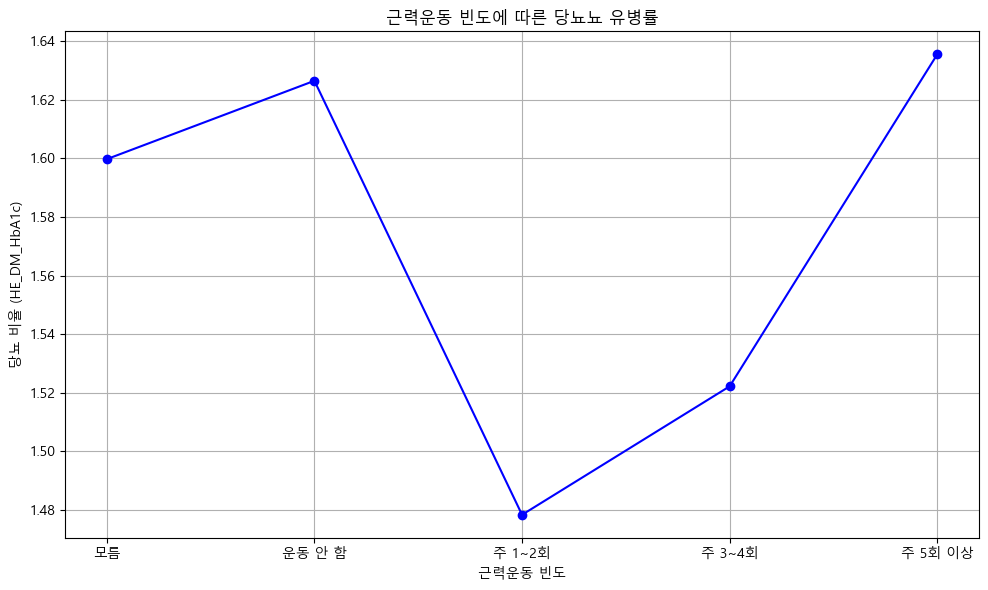

In [68]:
# BE5_1 그룹화 (방법 1 예시 사용)
def map_strength_exercise(val):
    if val == 1:
        return '운동 안 함'
    elif val in [2, 3]:
        return '주 1~2회'
    elif val in [4, 5]:
        return '주 3~4회'
    elif val == 6:
        return '주 5회 이상'
    else:
        return '모름'

data['BE5_1_GROUP'] = data['BE5_1'].apply(map_strength_exercise)

# 운동 그룹별 고혈압 비율 평균 계산 (예: HE_HP 변수)
group_stats = data.groupby('BE5_1_GROUP')['HE_DM_HbA1c'].mean().reset_index()

# 선 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(group_stats['BE5_1_GROUP'], group_stats['HE_DM_HbA1c'], marker='o', color='blue')
plt.xlabel('근력운동 빈도')
plt.ylabel('당뇨 비율 (HE_DM_HbA1c)')
plt.title('근력운동 빈도에 따른 당뇨뇨 유병률')
plt.grid(True)
plt.tight_layout()
plt.show()


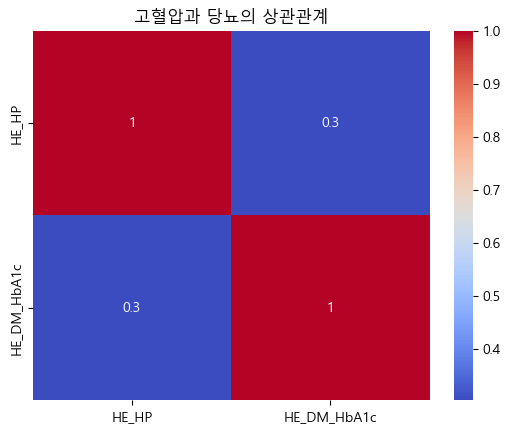

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# 고혈압 여부와 당뇨 여부가 각각 0/1로 있는 경우
sns.heatmap(data[['HE_HP', 'HE_DM_HbA1c']].corr(), annot=True, cmap='coolwarm')
plt.title('고혈압과 당뇨의 상관관계')
plt.show()


In [27]:
# 고혈압 여부에 따른 당뇨율 확인
pd.crosstab(data['HE_HP'], data['HE_DM_HbA1c'], normalize='index') * 100


HE_DM_HbA1c,1.0,2.0,3.0
HE_HP,,,
1.0,69.119918,22.782639,8.097444
2.0,54.258373,31.866029,13.875598
3.0,52.550741,35.271530,12.177729
4.0,36.713364,36.624416,26.662219


**당뇨병 예측 모델 선정**

In [72]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
    --------------------------------------- 0.0/1.5 MB 435.7 kB/s eta 0:00:04
   --- ------------------------------------ 0.1/1.5 MB 1.2 MB/s eta 0:00:02
   ------------ --------------------------- 0.5/1.5 MB 3.0 MB/s eta 0:00:01
   ------------------------ --------------- 0.9/1.5 MB 4.3 MB/s eta 0:00:01
   ---------------------------------------  1.4/1.5 MB 5.7 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 4.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\장동민\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



▶ Mean F1 score (CV) of D_tree: 94.14%
▶ Test F1 score of D_tree: 94.23%
▶ Test Accuracy of D_tree: 94.23%

▶ Mean F1 score (CV) of RF: 94.50%
▶ Test F1 score of RF: 94.77%
▶ Test Accuracy of RF: 94.74%

▶ Mean F1 score (CV) of HistGB: 94.52%
▶ Test F1 score of HistGB: 94.78%
▶ Test Accuracy of HistGB: 94.78%

▶ Mean F1 score (CV) of XGB: 94.49%
▶ Test F1 score of XGB: 94.74%
▶ Test Accuracy of XGB: 94.74%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1656
[LightGBM] [Info] Number of data points in the train set: 6931, number of used features: 11
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` t

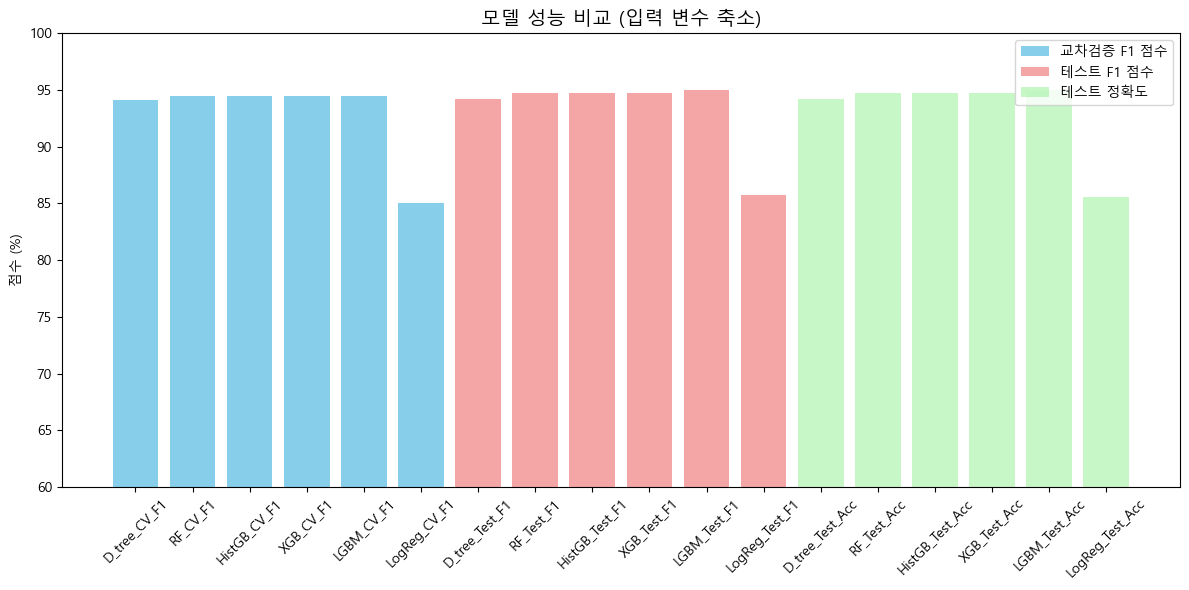

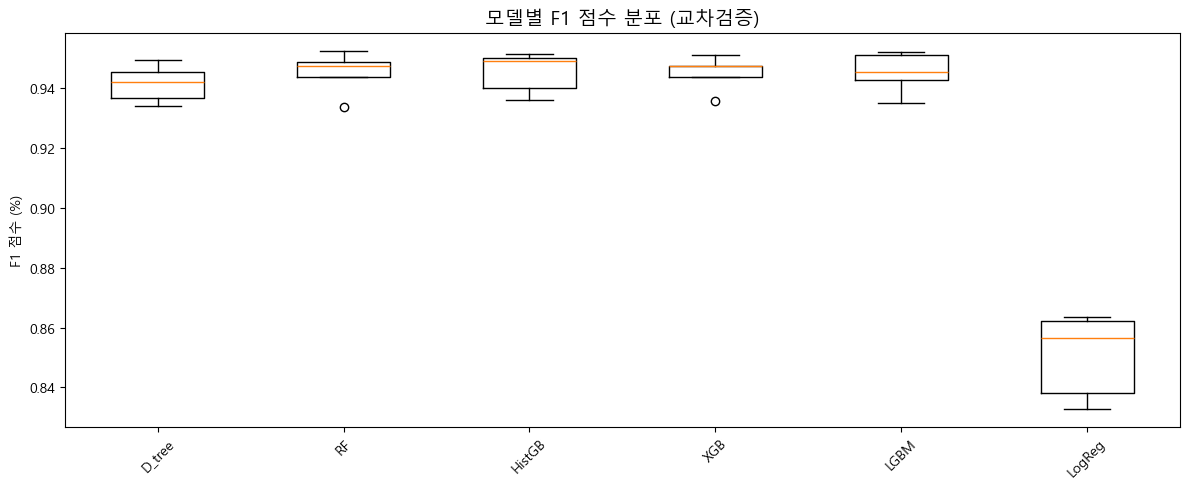

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# 입력 피처 및 타겟 설정
HE_DM_HbA1c_input_features = ['HE_HbA1c','HE_glu', 'HE_wc',  'HE_sbp1', 'HE_BMI', 'HE_TG', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2', 'sex', 'age']
X = data[HE_DM_HbA1c_input_features]
y = data['HE_DM_HbA1c'].astype(int) - 1

# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SMOTE로 오버샘플링
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 분류기 정의
classifiers = [
    ('D_tree', DecisionTreeClassifier(max_depth=3, min_samples_split=10, random_state=0, class_weight='balanced')),
    ('RF', RandomForestClassifier(n_estimators=50, max_depth=5, random_state=0, class_weight='balanced')),
    ('HistGB', HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=0)),
    ('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)),
    ('LGBM', LGBMClassifier(random_state=0, class_weight='balanced')),
    ('LogReg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=0))
]

classifier_names = [name for name, _ in classifiers]
classifiers = [clf for _, clf in classifiers]

# 결과 저장용 리스트
modelaccuracies = []
modelmeans = []
modelnames = []
modeltest_f1 = []
modeltest_acc = []

# 모델 훈련 및 평가
for classifier_name, classifier in zip(classifier_names, classifiers):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = cross_val_score(classifier, X_train, y_train, cv=skf, scoring='f1_weighted')
    print(f"\n▶ Mean F1 score (CV) of {classifier_name}: {accuracies.mean()*100:.2f}%")
    modelaccuracies.append(accuracies)
    modelnames.append(classifier_name)
    modelmeans.append(accuracies.mean()*100)

    classifier.fit(X_train_smote, y_train_smote)
    y_pred = classifier.predict(X_test)
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    test_acc = accuracy_score(y_test, y_pred)
    modeltest_f1.append(test_f1*100)
    modeltest_acc.append(test_acc*100)
    print(f"▶ Test F1 score of {classifier_name}: {test_f1*100:.2f}%")
    print(f"▶ Test Accuracy of {classifier_name}: {test_acc*100:.2f}%")

# 성능 바 차트 (CV, Test F1, Test Accuracy)
plt.figure(figsize=(12, 6))
plt.ylim([60, 100])
plt.bar([name + "_CV_F1" for name in modelnames], modelmeans, color='skyblue', label='교차검증 F1 점수')
plt.bar([name + "_Test_F1" for name in modelnames], modeltest_f1, color='lightcoral', label='테스트 F1 점수', alpha=0.7)
plt.bar([name + "_Test_Acc" for name in modelnames], modeltest_acc, color='lightgreen', label='테스트 정확도', alpha=0.5)

plt.xticks(rotation=45)
plt.ylabel('점수 (%)')
plt.title('모델 성능 비교 (입력 변수 축소)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

# Boxplot (CV F1 분포)
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.boxplot(modelaccuracies)
ax.set_xticklabels(modelnames, rotation=45)
ax.set_ylabel('F1 점수 (%)')
ax.set_title('모델별 F1 점수 분포 (교차검증)', fontsize=14)
plt.tight_layout()
plt.show()


        
| Model   | CV F1(교차 검증) (%) | Test F1 (%) | Test Accuracy (%)  |
| ------- |      ---------      | ----------- | ----------------- |
| D_tree  |        75.17        |   75.60     |     76.77         |
| RF      |        76.26        |   74.83     |     75.41         |
| HistGB  |        77.58        |   74.31     |     74.50         |
| XGB     |        77.78        |   74.44     |     74.69         |
| LGBM    |        76.42        |   74.71     |     75.14         |
| LogReg  |        69.58        |   67.66     |     67.41         |


- CV F1 vs Test F1: 과대적합 정도 파악. CV F1이 높고 Test F1이 낮으면 과대적합 의심.
- Test F1 vs Test Accuracy: 클래스 불균형 문제의 영향 정도 파악. Accuracy가 F1보다 현저히 높으면 불균형 영향 크고, 모델이 소수 클래스를 잘 못 맞추고 있을 가능성 높음.
- 각 모델의 CV F1: 여러 모델 중 어떤 모델이 데이터에 대해 전반적인 일반화 잠재력이 높은지 비교.
- 각 모델의 Test F1: 불균형 상황을 고려했을 때, 최종적으로 어떤 모델이 실제 보지 못한 데이터에 대해 가장 좋은 종합적인 예측 성능을 보이는지 비교.
- 각 모델의 Test Accuracy: 모델별 전반적인 예측 성공률 비교 (F1과 함께 보며 불균형 영향 고려).

✅ 전반적인 결론
XGB와 HistGB가 CV(교차검증) 성능에서는 가장 높음, 
하지만 테스트 F1에서는 소폭 하락하여, 실제 일반화 성능에서는 D_tree와 큰 차이는 없음.

D_tree는 가장 단순하지만, 테스트 성능이 가장 좋음 (F1, Accuracy 모두).

LogReg은 성능이 가장 낮음, 복잡한 비선형 분포를 충분히 설명하지 못함을 시사.

📌 모델별 간단 평가
- **D_tree (결정트리)**

🎯 테스트에서 가장 높은 F1 (75.60%) 및 정확도 (76.77%)

모델이 단순하지만 SMOTE 및 적절한 파라미터 설정 덕에 잘 작동함.

일반화 잘됨, 오히려 복잡한 모델보다 안정적일 수 있음.

- **RF (랜덤포레스트)**

일반화 성능은 좋았으나 테스트에서 약간 낮아짐.

앙상블 특성상 복잡하지만 오버피팅은 크게 없음.

- **HistGB / XGB / LGBM**

모두 Gradient Boosting 계열. CV에서는 가장 좋지만 테스트에서는 소폭 하락.

데이터의 작은 변동에 민감할 수 있음.

과적합 가능성 약간 있음 (CV 성능 대비 테스트 성능 하락).

- **LogReg (로지스틱 회귀)**

가장 단순한 모델. 비선형 관계를 충분히 설명하지 못함.

데이터 복잡도 대비 부족한 표현력 → 성능 저조.

**HistGB로 모델 선정 + 오버샘플링**

              precision    recall  f1-score   support

          정상       0.99      0.98      0.99      1165
      경계형 당뇨       0.91      0.94      0.93       673
          당뇨       0.85      0.84      0.84       328

    accuracy                           0.95      2166
   macro avg       0.92      0.92      0.92      2166
weighted avg       0.95      0.95      0.95      2166



<Figure size 600x600 with 0 Axes>

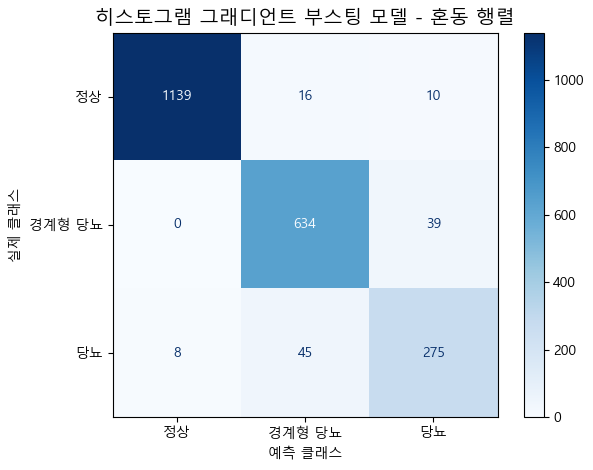

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt

HE_DM_HbA1c_input_features = ['HE_HbA1c','HE_glu', 'HE_wc',  'HE_sbp1', 'HE_BMI', 'HE_TG', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2', 'sex', 'age']

# X와 y 정의
X = data[HE_DM_HbA1c_input_features]
y = data['HE_DM_HbA1c'].astype(int) - 1

# 훈련/테스트 분할 먼저 수행
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 훈련 데이터에만 fit_transform
X_test_scaled = scaler.transform(X_test)  # 테스트 데이터에는 transform만 적용

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
# SMOTE를 스케일링된 훈련 데이터에 적용
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)


from sklearn.metrics import classification_report

# HistGradientBoostingClassifier로 테스트 데이터 예측
best_model = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=42)
best_model.fit(X_train_smote, y_train_smote)
y_pred = best_model.predict(X_test_scaled)

# 클래스 이름 한글로 정의
target_names_kor = ['정상', '경계형 당뇨', '당뇨']

# 평가 지표 출력 (한글 클래스명)
print(classification_report(y_test, y_pred, target_names=target_names_kor))

# 평가 지표 및 혼동행렬
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(class_report).transpose()

# 혼동 행렬 시각화
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=target_names_kor)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("히스토그램 그래디언트 부스팅 모델 - 혼동 행렬", fontsize=14)
plt.xlabel("예측 클래스")
plt.ylabel("실제 클래스")
plt.tight_layout()
plt.show()

# classification_report DataFrame 변환 (선택)
class_report = classification_report(y_test, y_pred, target_names=target_names_kor, output_dict=True)
report_df = pd.DataFrame(class_report).transpose()

**클래스2(당뇨) 성능 개선시키기 - 클래스 가중치** (smote만 적용시키는게 좋아보임)

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt


HE_DM_HbA1c_input_features = ['HE_HbA1c','HE_glu', 'HE_wc',  'HE_sbp1', 'HE_BMI', 'HE_TG', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2']
#  'sex', 'age'
# X와 y 정의
X = data[HE_DM_HbA1c_input_features]
y = data['HE_DM_HbA1c'].astype(int) - 1

# 훈련/테스트 분할 먼저 수행
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 훈련 데이터에만 fit_transform
X_test_scaled = scaler.transform(X_test)  # 테스트 데이터에는 transform만 적용


from sklearn.metrics import classification_report

from sklearn.utils.class_weight import compute_class_weight

# 클래스 가중치 계산 ('balanced'는 빈도수에 반비례하여 자동 계산)
# compute_class_weight 함수에 원본 훈련 데이터의 y 값을 전달해야 합니다.
# 만약 SMOTE 적용 후의 데이터로 가중치를 계산하고 싶다면 y_train_smote를 전달합니다.
classes = np.unique(y_train) # 원본 훈련 데이터의 클래스 레이블
weights = compute_class_weight('balanced', classes=classes, y=y_train)

# 계산된 가중치를 딕셔너리 형태로 변환 {클래스_라벨: 가중치}
class_weights_dict = dict(zip(classes, weights))

print(f"계산된 클래스 가중치: {class_weights_dict}")


# HistGradientBoostingClassifier 모델 학습 (class_weight 적용)
# best_model = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=42) # 기존 모델
# class_weight 매개변수 추가
best_model_weighted = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_iter=100,
    random_state=42,
    class_weight=class_weights_dict # 또는 'balanced' 문자열 사용 가능
)

# 스케일링된 훈련 데이터로 학습 (SMOTE 미적용 시 X_train_scaled 사용)
# 만약 SMOTE 결과를 사용한다면 X_train_smote_scaled (SMOTE 후 스케일링된 데이터) 사용
best_model_weighted.fit(X_train_scaled, y_train)

# 스케일링된 테스트 데이터로 예측
y_pred_weighted = best_model_weighted.predict(X_test_scaled)

# 성능 평가
print("\nClass Weight 적용 후 Classification Report:")
# y_test는 원본 테스트 데이터의 라벨입니다. 예측 결과와 비교합니다.
print(classification_report(y_test, y_pred_weighted))

# 추가적으로 F1 스코어를 각 클래스별로 확인하여 개선되었는지 비교합니다.
f1_weighted = f1_score(y_test, y_pred_weighted, average=None)
print(f"\nClass Weight 적용 후 클래스별 F1-score: {f1_weighted}")

계산된 클래스 가중치: {np.int64(0): np.float64(0.6194766194766195), np.int64(1): np.float64(1.072409951726699), np.int64(2): np.float64(2.2062643239113826)}

Class Weight 적용 후 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1165
           1       0.90      0.96      0.93       673
           2       0.89      0.81      0.85       328

    accuracy                           0.95      2166
   macro avg       0.93      0.92      0.92      2166
weighted avg       0.95      0.95      0.95      2166


Class Weight 적용 후 클래스별 F1-score: [0.98572047 0.93247126 0.84896661]


Shap로 Feature importance 확인

상관 행렬 샘플:
          HE_HbA1c    HE_glu     HE_wc   HE_sbp1    HE_BMI     HE_TG  \
HE_HbA1c  1.000000 -0.332815 -0.135087 -0.083136 -0.111655 -0.065838   
HE_glu   -0.332815  1.000000  0.030726  0.021360  0.025841 -0.014820   
HE_wc    -0.135087  0.030726  1.000000  0.158569  0.241744  0.052481   
HE_sbp1  -0.083136  0.021360  0.158569  1.000000  0.005863 -0.006186   
HE_BMI   -0.111655  0.025841  0.241744  0.005863  1.000000  0.044936   

           HE_chol  HE_LDL_drct  HE_HDL_st2  
HE_HbA1c -0.051959    -0.010342   -0.049969  
HE_glu   -0.093500    -0.056186   -0.048268  
HE_wc    -0.057340     0.011892    0.062018  
HE_sbp1  -0.062931     0.002790   -0.064254  
HE_BMI    0.003116    -0.078091    0.035746  

 상관 행렬 샘플:
                    HE_HbA1c(당화혈색소)  HE_glu(공복혈당)  HE_wc(허리둘레(cm))  \
HE_HbA1c(당화혈색소)                1.00         -0.33            -0.14   
HE_glu(공복혈당)                  -0.33          1.00             0.03   
HE_wc(허리둘레(cm))               -0.14          0.03          

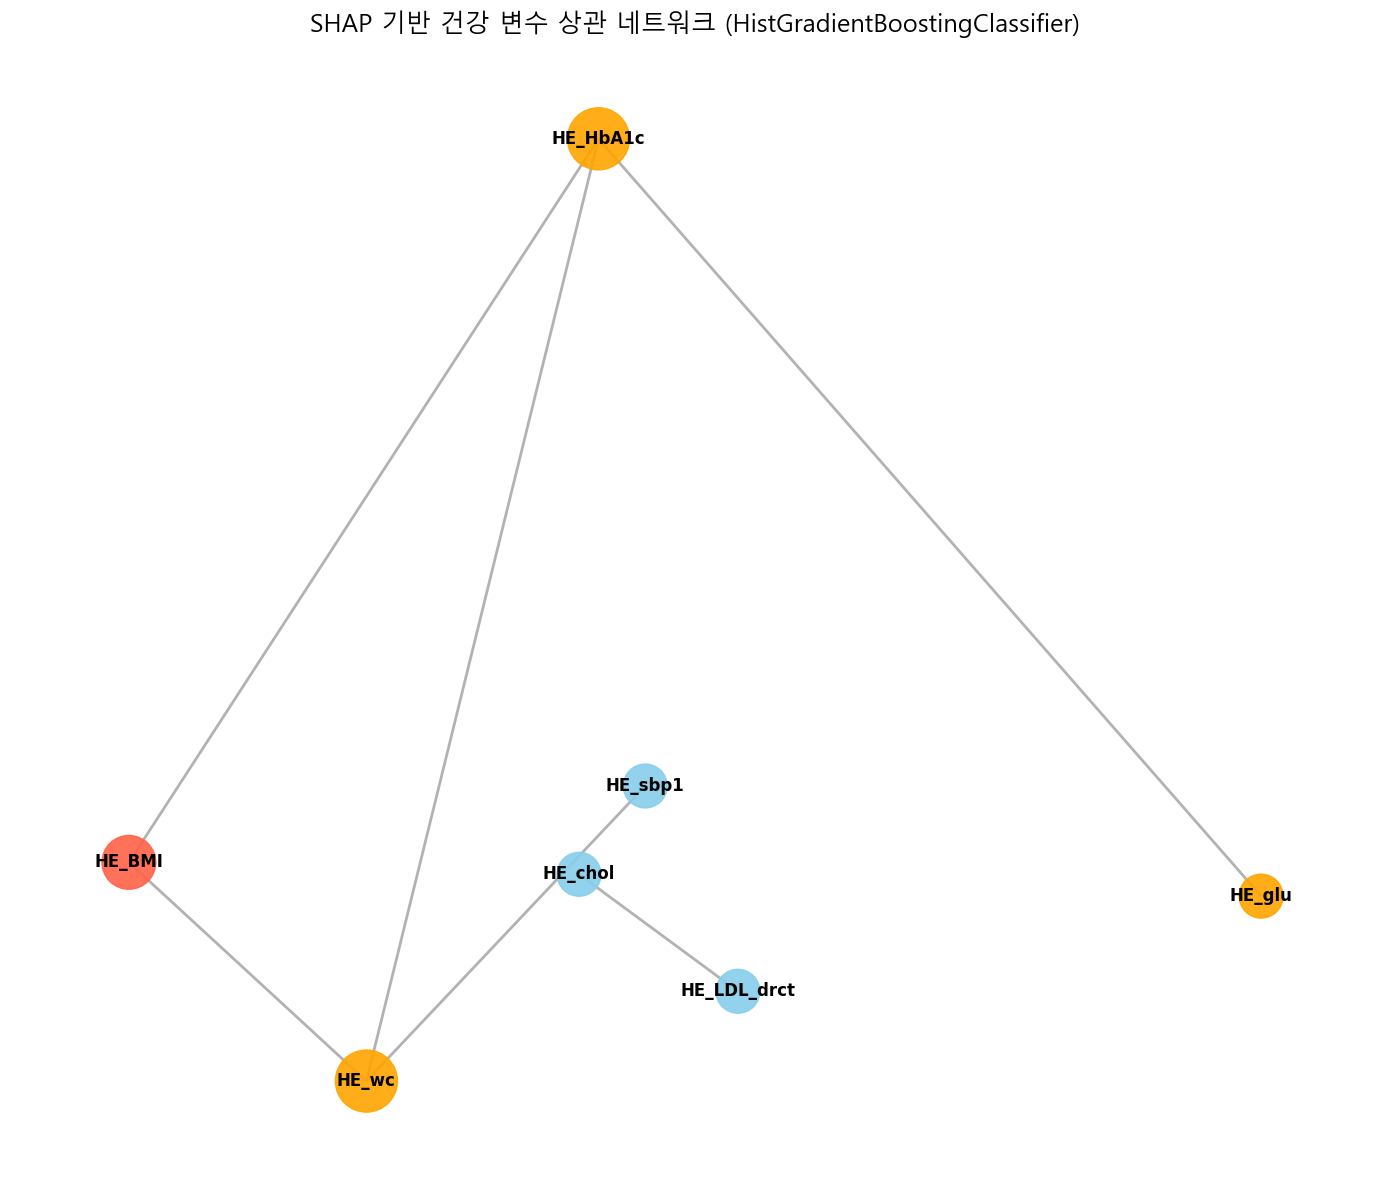


--- 분석 결과 요약 ---

### 모델 성능 (당뇨병 예측) ###
              precision    recall  f1-score   support

          정상       0.99      0.98      0.99      1165
      당뇨병전단계       0.91      0.96      0.93       673
         당뇨병       0.88      0.83      0.86       328

    accuracy                           0.95      2166
   macro avg       0.93      0.92      0.93      2166
weighted avg       0.95      0.95      0.95      2166


### SHAP 값 상관 네트워크 핵심 요약 ###
● 모델의 예측 기여도 측면에서, HE_HbA1c(당화혈색소), HE_wc(허리둘레(cm)), HE_BMI(체질량지수(BMI)) 은(는) 다른 많은 건강 지표들과 복합적으로 연관되어 예측에 핵심적인 기여를 하는 피처들입니다 (네트워크 중심성 기준).

### 특정 개인(첫 번째 테스트 샘플)의 당뇨병 예측 요약 ###
● 이 개인의 당뇨병 예측 결과는 다른 어떤 특성보다 **HE_HbA1c(당화혈색소)** 값에 의해 가장 강력하게 결정되었으며,
  그다음으로 **HE_glu(공복혈당)**, **HE_wc(허리둘레(cm))** 가 이 개인의 당뇨병 예측에 중요한 영향을 미쳤습니다.

이러한 결과는 추후 사용자 맞춤형 건강 가이드라인 제공 시 각 개인에게 중요한 기준이 될 것입니다.


In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt
import networkx as nx


# 한글 변수명 매핑
feature_kor_map = {
'HE_HbA1c' : 'HE_HbA1c(당화혈색소)',
'HE_glu': 'HE_glu(공복혈당)',
'HE_sbp1': 'HE_sbp1(수축기 혈압)',
'HE_BMI': 'HE_BMI(체질량지수(BMI))',
'HE_TG': 'HE_TG(중성지방)',
'HE_chol': 'HE_chol(총 콜레스테롤)',
'HE_LDL_drct': 'HE_LDL_drct(LDL 콜레스테롤)',
'HE_HDL_st2': 'HE_HDL_st2(HDL 콜레스테롤)',
'sex': 'sex(성별)',
'age': 'age(나이)',
'HE_wc': 'HE_wc(허리둘레(cm))'
}

HE_DM_HbA1c_input_features = ['HE_HbA1c','HE_glu', 'HE_wc',  'HE_sbp1', 'HE_BMI', 'HE_TG', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2']
#'age', 'sex'
# X와 y 정의
X = data[HE_DM_HbA1c_input_features]
y = data['HE_DM_HbA1c'].astype(int) - 1

smote = SMOTE(random_state=42)
# SMOTE를 스케일링된 훈련 데이터에 적용
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)


from sklearn.metrics import classification_report

# HistGradientBoostingClassifier로 테스트 데이터 예측
best_model = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=42)
# 스케일링되고 SMOTE 적용된 훈련 데이터로 모델 학습
best_model.fit(X_train_smote, y_train_smote)
# 스케일링된 테스트 데이터로 예측
y_pred = best_model.predict(X_test_scaled)


# SHAP 값 계산
explainer = shap.TreeExplainer(best_model)
# SHAP 값을 스케일링된 테스트 데이터에 대해 계산
shap_values = explainer.shap_values(X_test_scaled)

# SHAP 값 처리 (클래스별 평균 절대값으로 2차원 변환)
if isinstance(shap_values, list):
    # 리스트 형태일 경우 (대부분의 다중 클래스 TreeExplainer) 클래스별 절대값의 평균
    # 각 클래스별 SHAP 값의 크기를 샘플별로 평균 (n_samples, n_features)
    shap_values_class = np.mean([np.abs(val) for val in shap_values], axis=0)
elif len(shap_values.shape) == 3:  # (n_samples, n_features, n_classes) 형태일 경우
    # 클래스 차원 평균 절대값 (n_samples, n_features)
    shap_values_class = np.mean(np.abs(shap_values), axis=2)
else: # (n_samples, n_features) 형태일 경우 (이진 분류 또는 이미 클래스별 평균된 경우)
    shap_values_class = np.abs(shap_values)


# SHAP DataFrame 생성 (컬럼명은 원본 특성 이름 사용)
# 스케일링된 데이터로 SHAP을 계산했지만, DataFrame 컬럼명은 원본 특성 이름 사용
shap_df = pd.DataFrame(shap_values_class, columns=HE_DM_HbA1c_input_features)


# 상관 행렬 계산 및 디버깅
print("상관 행렬 샘플:")
print(shap_df.corr().head())  # 상관 행렬 일부 출력
cor_matrix = shap_df.corr()
# 컬럼명을 한글로 바꾸어 출력
cor_matrix_kor = cor_matrix.rename(index=feature_kor_map, columns=feature_kor_map)
print("\n 상관 행렬 샘플:")
print(cor_matrix_kor.round(2).head())

# 네트워크 생성
G = nx.Graph()
threshold = 0.1  # 상관계수 임계값
edge_count = 0
for i in range(len(cor_matrix.columns)):
    for j in range(i + 1, len(cor_matrix.columns)):
        corr_val = cor_matrix.iloc[i, j]
        if abs(corr_val) >= threshold:
            G.add_edge(cor_matrix.columns[i], cor_matrix.columns[j], weight=corr_val)
            edge_count += 1
print(f"네트워크에 추가된 엣지 수: {edge_count}")

# 중심성 계산 (Degree Centrality)
centrality = nx.degree_centrality(G)
if not centrality:
    print("네트워크에 노드가 없음. threshold를 낮추거나 데이터를 확인하세요.")
else:
    # 상위 3개 노드 기준으로 색 구분
    top_nodes = sorted(centrality, key=centrality.get, reverse=True)[:3]

    # 특정 샘플(첫 번째 테스트 샘플)의 상위 3개 중요 피처
    user_idx = 0  # 첫 번째 테스트 샘플
    top3_user_feats = shap_df.iloc[user_idx].abs().sort_values(ascending=False).head(3).index.tolist()

    # 노드 색상 설정
    node_colors = []
    for node in G.nodes:
        if node in top3_user_feats:
            node_colors.append('orange')  # 특정 샘플의 상위 피처
        elif node in top_nodes:
            node_colors.append('tomato')  # 중심성이 높은 피처
        else:
            node_colors.append('skyblue')  # 나머지 피처

    # 네트워크 시각화
    plt.figure(figsize=(14, 12))
    pos = nx.spring_layout(G, k=0.5, seed=42)
    node_sizes = [500 + 3000 * centrality[n] for n in G.nodes]

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=2, alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', font_color='black')

    plt.title("SHAP 기반 건강 변수 상관 네트워크 (HistGradientBoostingClassifier)", fontsize=18)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # 중심성 Top 3 변수 (한글 이름)
    top_centrality_nodes_kor = [feature_kor_map.get(node, node) for node in top_nodes]
    # SHAP Top 3 변수 (한글 이름)
    top3_user_feats_kor = [feature_kor_map.get(feat, feat) for feat in top3_user_feats]


   # 결과 출력
    print("\n--- 분석 결과 요약 ---")
    print("\n### 모델 성능 (당뇨병 예측) ###")
    print(classification_report(y_test, y_pred, target_names=['정상', '당뇨병전단계', '당뇨병']))

    print("\n### SHAP 값 상관 네트워크 핵심 요약 ###")
    print(f"● 모델의 예측 기여도 측면에서, {', '.join(top_centrality_nodes_kor)} 은(는) 다른 많은 건강 지표들과 복합적으로 연관되어 예측에 핵심적인 기여를 하는 피처들입니다 (네트워크 중심성 기준).")

    print(f"\n### 특정 개인(첫 번째 테스트 샘플)의 당뇨병 예측 요약 ###")
    print(f"● 이 개인의 당뇨병 예측 결과는 다른 어떤 특성보다 **{top3_user_feats_kor[0]}** 값에 의해 가장 강력하게 결정되었으며,")
    print(f"  그다음으로 **{top3_user_feats_kor[1]}**, **{top3_user_feats_kor[2]}** 가 이 개인의 당뇨병 예측에 중요한 영향을 미쳤습니다.")
    
    print("\n이러한 결과는 추후 사용자 맞춤형 건강 가이드라인 제공 시 각 개인에게 중요한 기준이 될 것입니다.")


**고혈압 예측 모델 선정**


▶ Mean F1 score (CV) of D_tree: 62.49%
▶ Test F1 score of D_tree: 63.64%
▶ Test Accuracy of D_tree: 61.87%

▶ Mean F1 score (CV) of RF: 69.50%
▶ Test F1 score of RF: 69.95%
▶ Test Accuracy of RF: 67.82%

▶ Mean F1 score (CV) of HistGB: 72.55%
▶ Test F1 score of HistGB: 73.33%
▶ Test Accuracy of HistGB: 72.81%

▶ Mean F1 score (CV) of XGB: 72.53%
▶ Test F1 score of XGB: 73.06%
▶ Test Accuracy of XGB: 72.76%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1910
[LightGBM] [Info] Number of data points in the train set: 6931, number of used features: 12
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was

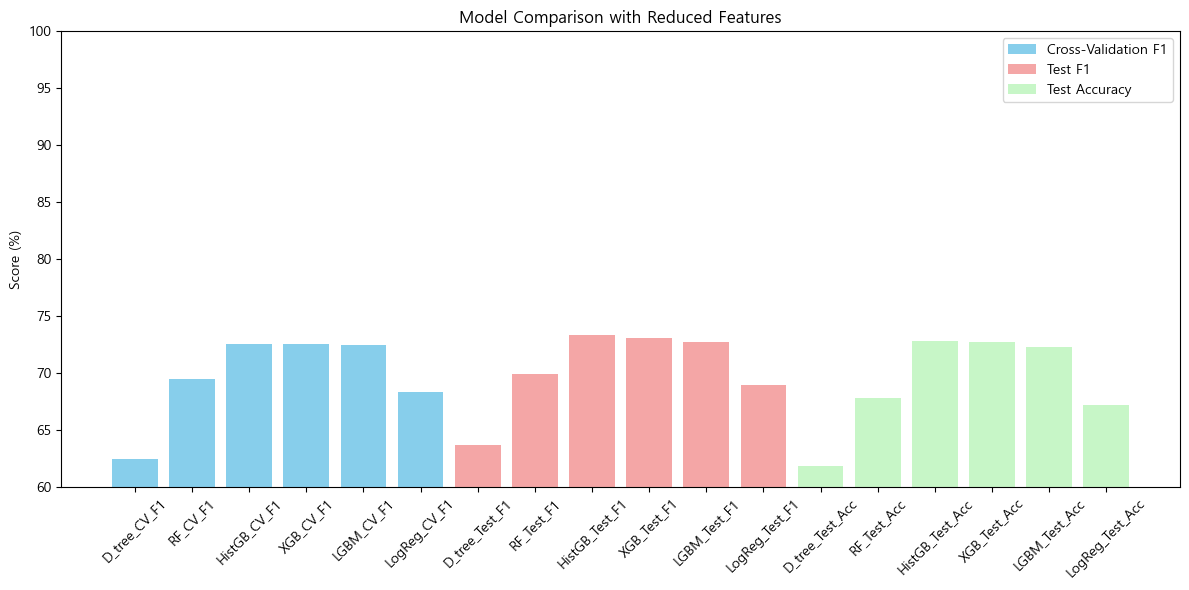

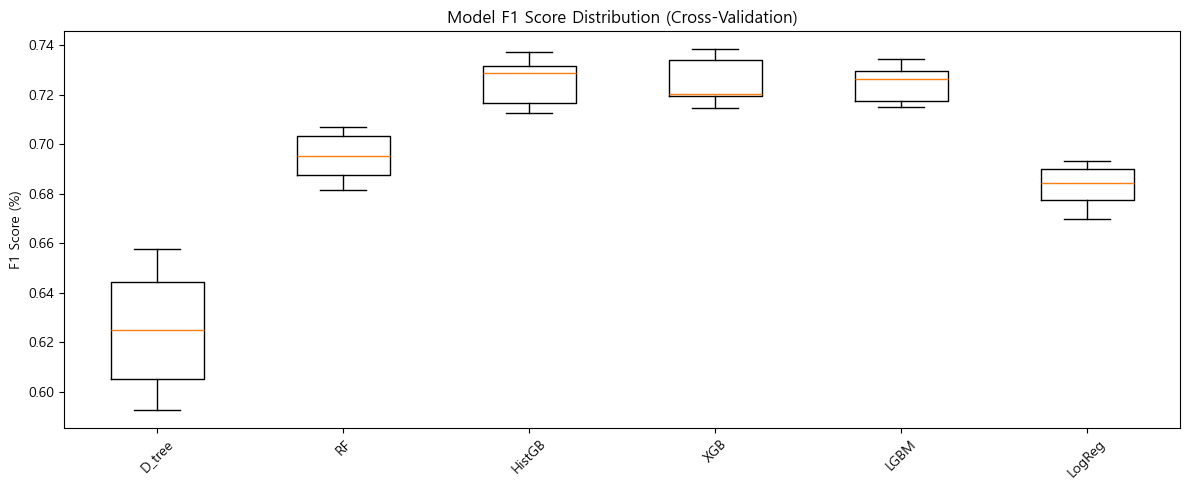

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# 입력 피처 및 타겟 설정
HE_HP_input_features= ['age','HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_BMI', 'HE_TG', 'HE_crea', 'HE_ast', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2']

# X와 y 정의
X = data[HE_HP_input_features]
y = data['HE_HP'].astype(int) - 1

# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SMOTE로 오버샘플링
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 분류기 정의
classifiers = [
    ('D_tree', DecisionTreeClassifier(max_depth=3, min_samples_split=10, random_state=0, class_weight='balanced')),
    ('RF', RandomForestClassifier(n_estimators=50, max_depth=5, random_state=0, class_weight='balanced')),
    ('HistGB', HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=0)),
    ('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)),
    ('LGBM', LGBMClassifier(random_state=0, class_weight='balanced')),
    ('LogReg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=0))
]

classifier_names = [name for name, _ in classifiers]
classifiers = [clf for _, clf in classifiers]

# 결과 저장용 리스트
modelaccuracies = []
modelmeans = []
modelnames = []
modeltest_f1 = []
modeltest_acc = []

# 모델 훈련 및 평가
for classifier_name, classifier in zip(classifier_names, classifiers):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = cross_val_score(classifier, X_train, y_train, cv=skf, scoring='f1_weighted')
    print(f"\n▶ Mean F1 score (CV) of {classifier_name}: {accuracies.mean()*100:.2f}%")
    modelaccuracies.append(accuracies)
    modelnames.append(classifier_name)
    modelmeans.append(accuracies.mean()*100)

    classifier.fit(X_train_smote, y_train_smote)
    y_pred = classifier.predict(X_test)
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    test_acc = accuracy_score(y_test, y_pred)
    modeltest_f1.append(test_f1*100)
    modeltest_acc.append(test_acc*100)
    print(f"▶ Test F1 score of {classifier_name}: {test_f1*100:.2f}%")
    print(f"▶ Test Accuracy of {classifier_name}: {test_acc*100:.2f}%")

# 성능 시각화
plt.figure(figsize=(12, 6))
plt.ylim([60, 100])
plt.bar([name + "_CV_F1" for name in modelnames], modelmeans, color='skyblue', label='Cross-Validation F1')
plt.bar([name + "_Test_F1" for name in modelnames], modeltest_f1, color='lightcoral', label='Test F1', alpha=0.7)
plt.bar([name + "_Test_Acc" for name in modelnames], modeltest_acc, color='lightgreen', label='Test Accuracy', alpha=0.5)
plt.xticks(rotation=45)
plt.ylabel('Score (%)')
plt.title('Model Comparison with Reduced Features')
plt.legend()
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.boxplot(modelaccuracies)
ax.set_xticklabels(modelnames, rotation=45)
ax.set_ylabel('F1 Score (%)')
ax.set_title('Model F1 Score Distribution (Cross-Validation)')
plt.tight_layout()
plt.show()


| Model   | CV F1 (%) | Test F1 (%) | Test Accuracy (%) |
| ------- | --------- | ----------- | ----------------- |
| D_tree  | 57.44     | 57.87       | 54.95             |
| RF      | 63.44     | 64.31       | 63.09             |
| HistGB  | 67.80     | 67.06       | 66.58             |
| XGB     | 67.28     | 66.79       | 66.58             |
| LGBM    | 66.79     | 66.55       | 66.16             |
| LogReg  | 58.83     | 58.28       | 56.54             |


HistGB 모델로 선정 (+오버샘플링)

                       precision    recall  f1-score   support

     Class 0 (Normal)       0.87      0.83      0.85       959
     Class 1 (Pre_hp)       0.36      0.46      0.40       172
Class 2 (Pre_high_hp)       0.54      0.62      0.58       304
    Class 2 (High_hp)       0.74      0.69      0.71       731

             accuracy                           0.72      2166
            macro avg       0.63      0.65      0.64      2166
         weighted avg       0.74      0.72      0.73      2166



<Figure size 600x600 with 0 Axes>

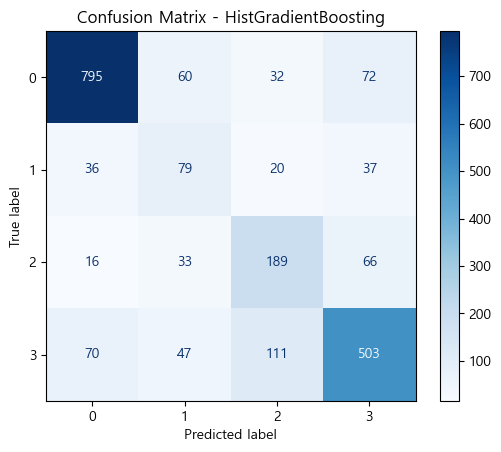

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt

# 입력 피처 및 타겟 설정
HE_HP_input_features= ['age','HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_BMI', 'HE_TG', 'HE_crea', 'HE_ast', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2']

# X와 y 정의
X = data[HE_HP_input_features]
y = data['HE_HP'].astype(int) - 1

# 훈련/테스트 분할 먼저 수행
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 훈련 데이터에만 fit_transform
X_test_scaled = scaler.transform(X_test)  # 테스트 데이터에는 transform만 적용

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
# SMOTE를 스케일링된 훈련 데이터에 적용
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)


from sklearn.metrics import classification_report

# HistGradientBoostingClassifier로 테스트 데이터 예측
best_model = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=42)
best_model.fit(X_train_smote, y_train_smote)
y_pred = best_model.predict(X_test_scaled)

# 클래스별 F1 스코어 출력
print(classification_report(y_test, y_pred, target_names=['Class 0 (Normal)', 'Class 1 (Pre_hp)', 'Class 2 (Pre_high_hp)', 'Class 2 (High_hp)']))

# 평가 지표 및 혼동행렬
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(class_report).transpose()

# 시각화
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - HistGradientBoosting")
plt.show()

**클래스 불균형 해결하기**

1. 오버샘플링+언더샘플링

--- SMOTETomek 적용 전 훈련 세트 클래스 분포: [3838  687 1216 2923] ---
--- SMOTETomek 적용 후 훈련 세트 클래스 분포: [3735 3831 3819 3735] ---

--- SMOTETomek 적용 후 HistGradientBoostingClassifier 성능 ---
              precision    recall  f1-score   support

          정상       0.87      0.84      0.86       959
        주의혈압       0.35      0.44      0.39       172
      고혈압전단계       0.55      0.60      0.57       304
         고혈압       0.74      0.69      0.72       731

    accuracy                           0.73      2166
   macro avg       0.63      0.64      0.63      2166
weighted avg       0.74      0.73      0.73      2166



<Figure size 700x600 with 0 Axes>

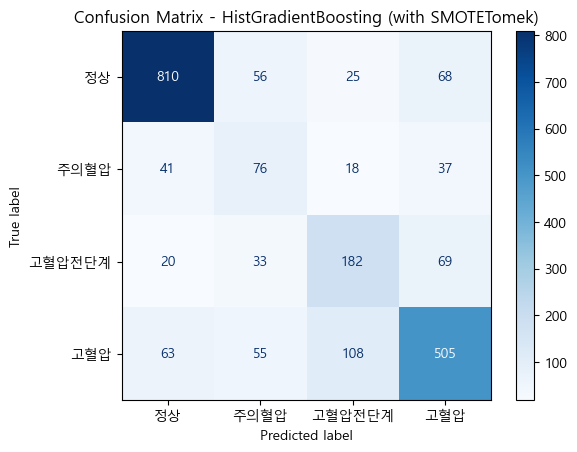

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.combine import SMOTETomek # SMOTETomek 임포트
import matplotlib.pyplot as plt


# 타겟 변수 클래스 매핑: 1:정상, 2:주의, 3:고혈압전단계, 4:고혈압
# 코드는 0, 1, 2, 3으로 변환
target_names = {1: '정상', 2: '주의혈압', 3: '고혈압전단계', 4: '고혈압'}

# 입력 피처 및 타겟 설정
HE_HP_input_features = ['age', 'HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu', 'HE_BMI', 'HE_TG', 'HE_crea', 'HE_ast', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2']

# X와 y 정의
X = data[HE_HP_input_features]
y = data['HE_HP'].astype(int) - 1 # 0, 1, 2, 3으로 변환

# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"--- SMOTETomek 적용 전 훈련 세트 클래스 분포: {np.bincount(y_train)} ---")

# SMOTETomek 적용
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

print(f"--- SMOTETomek 적용 후 훈련 세트 클래스 분포: {np.bincount(y_train_resampled)} ---")

# 모델 학습 및 예측
model = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=42)
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test_scaled)

# 성능 평가
print("\n--- SMOTETomek 적용 후 HistGradientBoostingClassifier 성능 ---")
# target_names를 인덱스에 맞게 리스트로 전달
print(classification_report(y_test, y_pred, target_names=[target_names[i] for i in sorted(target_names.keys())]))

# 혼동 행렬 시각화
plt.figure(figsize=(7, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred),
                              display_labels=[target_names[i] for i in sorted(target_names.keys())])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - HistGradientBoosting (with SMOTETomek)")
plt.show()

2. 언더샘플링 + 오버샘플링

--- SMOTEENN 적용 전 훈련 세트 클래스 분포: [3838  687 1216 2923] ---
--- SMOTEENN 적용 후 훈련 세트 클래스 분포: [2181 3692 3240 1739] ---

--- SMOTEENN 적용 후 HistGradientBoostingClassifier 성능 ---
              precision    recall  f1-score   support

          정상       0.94      0.72      0.82       959
        주의혈압       0.27      0.72      0.39       172
      고혈압전단계       0.47      0.70      0.56       304
         고혈압       0.77      0.55      0.64       731

    accuracy                           0.66      2166
   macro avg       0.61      0.67      0.60      2166
weighted avg       0.76      0.66      0.69      2166



<Figure size 700x600 with 0 Axes>

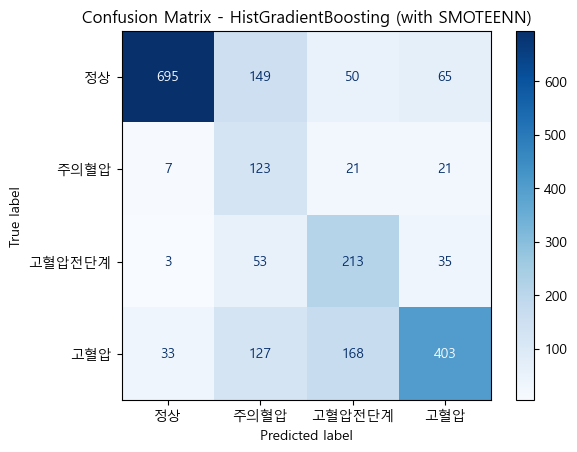

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.combine import SMOTEENN # SMOTEENN 임포트
import matplotlib.pyplot as plt


target_names = {1: '정상', 2: '주의혈압', 3: '고혈압전단계', 4: '고혈압'}

# 입력 피처 및 타겟 설정
HE_HP_input_features = ['age', 'HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu', 'HE_BMI', 'HE_TG', 'HE_crea', 'HE_ast', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2']

# X와 y 정의
X = data[HE_HP_input_features]
y = data['HE_HP'].astype(int) - 1

# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"--- SMOTEENN 적용 전 훈련 세트 클래스 분포: {np.bincount(y_train)} ---")

# SMOTEENN 적용
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"--- SMOTEENN 적용 후 훈련 세트 클래스 분포: {np.bincount(y_train_resampled)} ---")

# 모델 학습 및 예측
model = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=42)
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test_scaled)

# 성능 평가
print("\n--- SMOTEENN 적용 후 HistGradientBoostingClassifier 성능 ---")
print(classification_report(y_test, y_pred, target_names=[target_names[i] for i in sorted(target_names.keys())]))

# 혼동 행렬 시각화
plt.figure(figsize=(7, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred),
                              display_labels=[target_names[i] for i in sorted(target_names.keys())])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - HistGradientBoosting (with SMOTEENN)")
plt.show()

3. 클래스 가중치 부여

계산된 클래스 가중치: {np.int64(0): np.float64(0.5643564356435643), np.int64(1): np.float64(3.1528384279475983), np.int64(2): np.float64(1.78125), np.int64(3): np.float64(0.7410195005131714)}

--- Class Weight 적용 후 HistGradientBoostingClassifier 성능 ---
              precision    recall  f1-score   support

          정상       0.88      0.82      0.85       959
        주의혈압       0.35      0.48      0.41       172
      고혈압전단계       0.53      0.62      0.57       304
         고혈압       0.73      0.67      0.70       731

    accuracy                           0.72      2166
   macro avg       0.62      0.65      0.63      2166
weighted avg       0.74      0.72      0.73      2166



<Figure size 700x600 with 0 Axes>

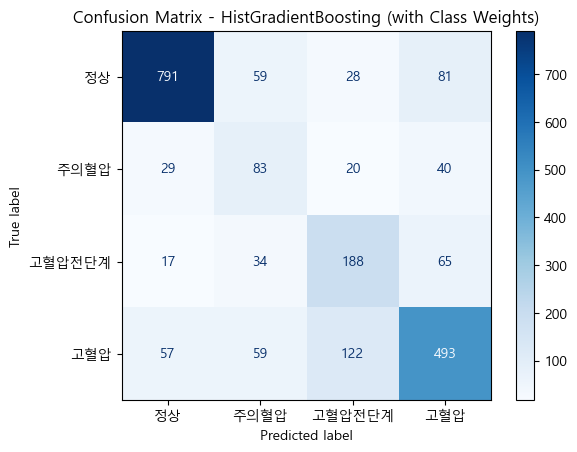

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt

# 입력 피처 및 타겟 설정
HE_HP_input_features= ['age','HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_BMI', 'HE_TG', 'HE_crea', 'HE_ast', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2']
#'age'
# X와 y 정의
X = data[HE_HP_input_features]
y = data['HE_HP'].astype(int) - 1

# 훈련/테스트 분할 먼저 수행
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 훈련 데이터에만 fit_transform
X_test_scaled = scaler.transform(X_test)  # 테스트 데이터에는 transform만 적용


from sklearn.metrics import classification_report

from sklearn.utils.class_weight import compute_class_weight

# 클래스 가중치 계산 ('balanced'는 빈도수에 반비례하여 자동 계산)
# compute_class_weight 함수에 원본 훈련 데이터의 y 값을 전달해야 합니다.
# 만약 SMOTE 적용 후의 데이터로 가중치를 계산하고 싶다면 y_train_smote를 전달합니다.
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))

print(f"계산된 클래스 가중치: {class_weights_dict}")

# 훈련 데이터의 각 샘플에 대한 가중치 배열 생성
sample_weights = np.array([class_weights_dict[label] for label in y_train])

# 모델 학습 (SMOTE 없이, sample_weight 적용)
model = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=42)
model.fit(X_train_scaled, y_train, sample_weight=sample_weights) # 여기에 sample_weight 전달

y_pred = model.predict(X_test_scaled)

print("\n--- Class Weight 적용 후 HistGradientBoostingClassifier 성능 ---")
# target_names 정의 (위에 있는 것과 동일하게)
target_names_list = ['정상', '주의혈압', '고혈압전단계', '고혈압']
print(classification_report(y_test, y_pred, target_names=target_names_list))

# 혼동 행렬 시각화
plt.figure(figsize=(7, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred),
                              display_labels=target_names_list)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - HistGradientBoosting (with Class Weights)")
plt.show()

xgboost로 자동 클래스 가중치 부여

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight # class_weight 계산을 위한 임포트
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, f1_score # make_scorer와 f1_score 임포트
from sklearn.model_selection import GridSearchCV # 이 줄 추가

target_names_map = {1: '정상', 2: '주의혈압', 3: '고혈압전단계', 4: '고혈압'}
target_names_list = [target_names_map[i] for i in sorted(target_names_map.keys())]

HE_HP_input_features = ['age', 'HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu', 'HE_BMI', 'HE_TG', 'HE_crea', 'HE_ast', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2']

X = data[HE_HP_input_features]
y = data['HE_HP'].astype(int) - 1

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"--- Class Weight 적용 전 훈련 세트 클래스 분포: {np.bincount(y_train)} ---")

# 클래스 가중치 계산 (원본 y_train 기반)
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))

print(f"계산된 클래스 가중치: {class_weights_dict}")

# 훈련 데이터의 각 샘플에 대한 가중치 배열 생성
sample_weights = np.array([class_weights_dict[label] for label in y_train])

# XGBoost 모델의 파라미터 범위 정의
param_grid = {
    'n_estimators': [100, 200, 300, 400], # 트리 개수 늘려보기
    'learning_rate': [0.01, 0.05, 0.1], # 학습률 더 낮게도 시도
    'max_depth': [3, 4, 5, 6, 7], # 깊이 조절
    'subsample': [0.7, 0.8, 0.9, 1.0], # 각 트리 학습 시 샘플 비율
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0], # 각 트리 학습 시 피처 비율
    'gamma': [0, 0.1, 0.2, 0.5], # 트리의 최소 손실 감소
    'reg_alpha': [0, 0.01, 0.1], # L1 정규화
    'reg_lambda': [0, 0.01, 0.1] # L2 정규화
}

# 평가 지표 설정: f1_macro를 사용하여 모든 클래스의 F1-score를 평균 (클래스 불균형 고려)
scorer = make_scorer(f1_score, average='macro')

# GridSearchCV 설정
grid_search = GridSearchCV(estimator=XGBClassifier(objective='multi:softmax',
                                                  eval_metric='mlogloss',
                                                  use_label_encoder=False,
                                                  random_state=42,
                                                  n_jobs=-1),
                           param_grid=param_grid,
                           scoring=scorer,
                           cv=5, # 5-fold cross-validation
                           verbose=2, # 자세한 진행 상황 출력
                           return_train_score=True) # 훈련 점수도 함께 볼 수 있도록 설정

# GridSearchCV 학습 (sample_weight를 GridSearchCV에도 전달)
# 이 때 X_train_scaled와 y_train이 사용됩니다 (SMOTE 미적용)
grid_search.fit(X_train_scaled, y_train, sample_weight=sample_weights) # sample_weights는 Step 1에서 계산된 것

best_xgb_model_tuned = grid_search.best_estimator_
print("\n--- 최적 하이퍼파라미터: ---")
print(grid_search.best_params_)
print("\n--- 최적 모델의 교차 검증 평균 F1-macro 점수: ---")
print(grid_search.best_score_)

y_pred_tuned = best_xgb_model_tuned.predict(X_test_scaled)

print("\n--- 최종 XGBoost (Class Weights & Tuned) 성능 ---")
print(classification_report(y_test, y_pred_tuned, target_names=target_names_list))

plt.figure(figsize=(7, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_tuned),
                              display_labels=target_names_list)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - XGBoost (Class Weights & Tuned)")
plt.show()

--- Class Weight 적용 전 훈련 세트 클래스 분포: [3838  687 1216 2923] ---
계산된 클래스 가중치: {np.int64(0): np.float64(0.5643564356435643), np.int64(1): np.float64(3.1528384279475983), np.int64(2): np.float64(1.78125), np.int64(3): np.float64(0.7410195005131714)}
Fitting 5 folds for each of 34560 candidates, totalling 172800 fits
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_esti

: 

shap 로 feature selections

이는 비만(허리둘레)과 이상지질혈증(콜레스테롤)이 고혈압을 포함한 대사증후군의 중요한 구성 요소이자 위험 인자라는 의학적 사실과 일치합니다. 모델은 이러한 간접적인 위험 인자 정보도 고혈압 예측에 중요하게 활용하고 있음을 알 수 있습니다.

- age (나이): 나이는 고혈압, 당뇨병, 심혈관 질환 등 여러 질병의 강력한 비수정 가능 위험 인자입니다. 모델이 나이를 중요한 예측 변수이자 중심성이 높은 변수로 사용한 것은 나이가 질병 예측에 있어 핵심적인 배경 요인임을 뒷받침합니다.
- HE_LDL_drct (LDL 콜레스테롤): 높은 LDL 콜레스테롤을 포함한 이상지질혈증은 고혈압, 당뇨병, 비만 등이 동반되는 대사증후군의 주요 구성 요소이며, 심혈관 질환 발병 위험을 높입니다. 모델이 HE_LDL_drct의 영향력 패턴이 다른 변수들과 복잡하게 연관되어 있음을 학습한 것은 콜레스테롤 관리가 대사 건강 및 관련 질병 위험 관리에도 중요함을 시사합니다.
- HE_ast (AST, 간 기능 수치): AST는 간세포 손상 지표로 주로 사용되지만, **비알코올성 지방간 질환(NAFLD)**과도 연관이 있습니다. NAFLD는 대사증후군의 또 다른 구성 요소이며, 고혈압, 당뇨병, 심혈관 질환의 위험을 높이는 것으로 알려져 있습니다. HE_ast가 높은 중심성을 보인다는 것은, 모델이 간 기능과 관련된 대사적 상태가 해당 질병 예측에 있어 다른 요인들과 복합적으로 연관되어 있다고 학습했음을 시사합니다. 이는 직접적인 지표는 아니지만, 질병과 관련된 간접적인 생리학적 연관성을 모델이 포착했을 가능성을 보여줍니다.

상관 행렬 샘플:
          HE_sbp1   HE_dbp1     HE_wc    HE_glu    HE_BMI     HE_TG   HE_crea  \
HE_sbp1  1.000000 -0.018392  0.074599 -0.053684 -0.062175  0.019500 -0.090017   
HE_dbp1 -0.018392  1.000000  0.044804 -0.013468  0.066568 -0.025350 -0.005616   
HE_wc    0.074599  0.044804  1.000000  0.116823  0.345073  0.081959 -0.036415   
HE_glu  -0.053684 -0.013468  0.116823  1.000000 -0.007473  0.070145 -0.068033   
HE_BMI  -0.062175  0.066568  0.345073 -0.007473  1.000000  0.008333  0.038773   

           HE_ast   HE_chol  HE_LDL_drct  HE_HDL_st2  
HE_sbp1  0.055746 -0.056820    -0.173867   -0.015582  
HE_dbp1  0.002150 -0.058084    -0.158799   -0.020652  
HE_wc    0.069391  0.005812     0.022134    0.079442  
HE_glu   0.141844 -0.004190    -0.002972   -0.014256  
HE_BMI  -0.011429  0.027596     0.036731    0.111011  

 상관 행렬 샘플:
            수축기 혈압  이완기 혈압  허리둘레(cm)  공복혈당  체질량지수(BMI)  중성지방  HE_crea  HE_ast  \
수축기 혈압        1.00   -0.02      0.07 -0.05       -0.06  0.02    -0.09    0.06   

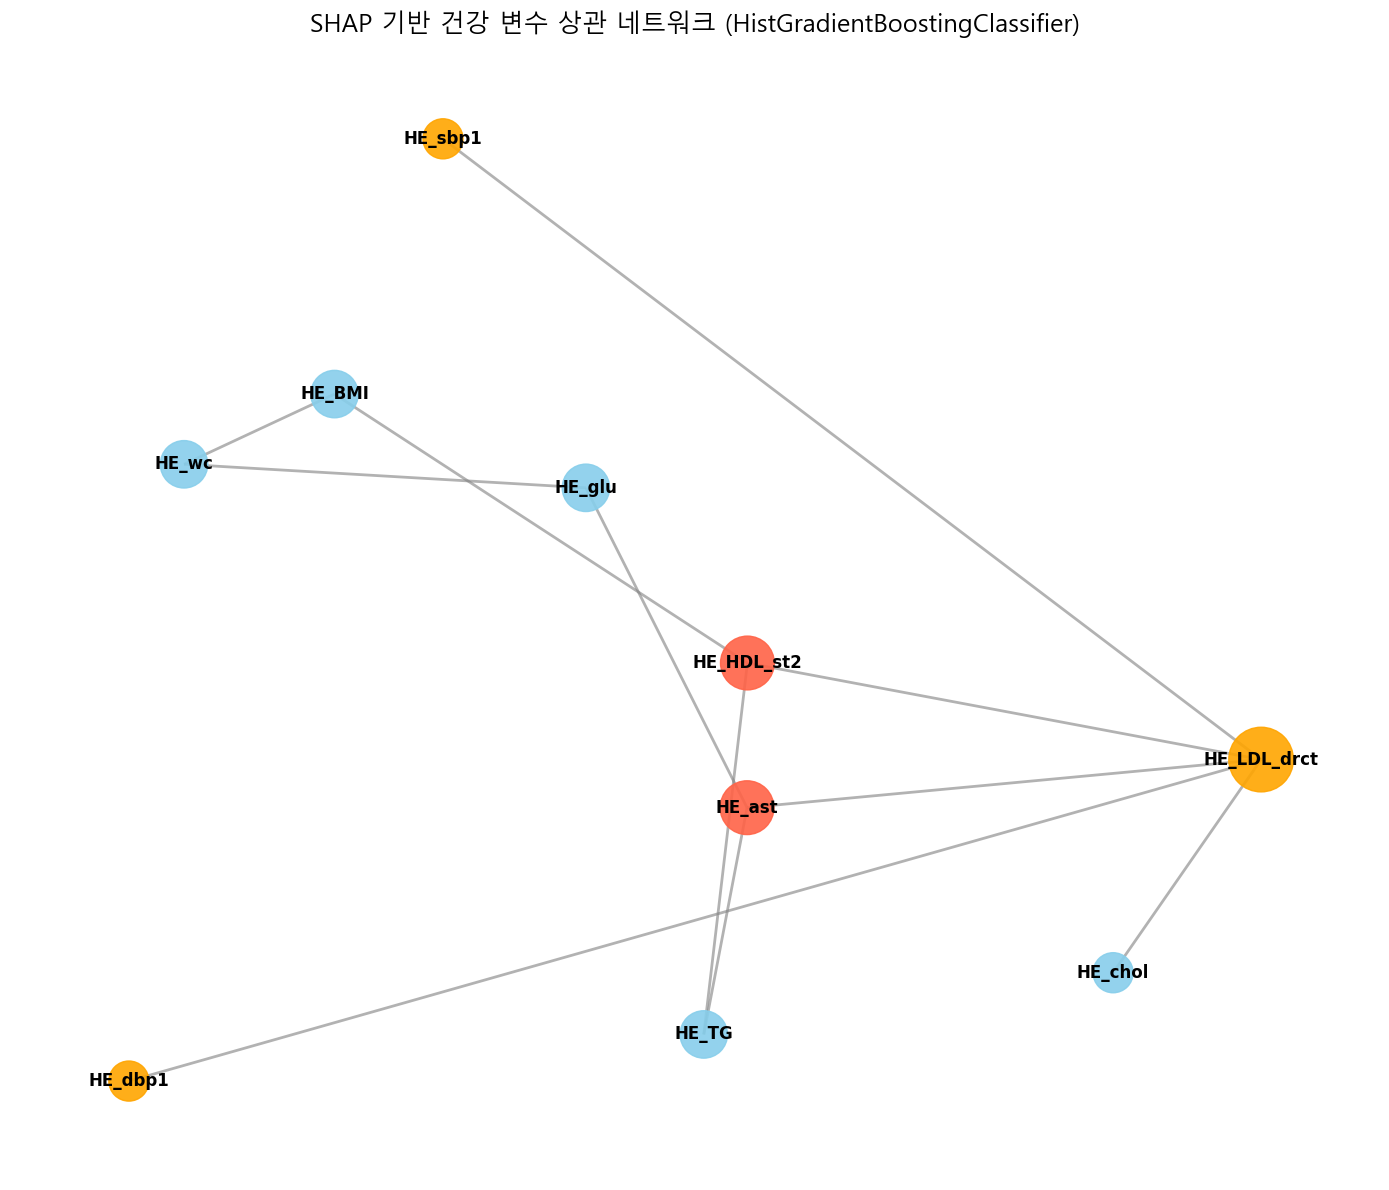


=== 질병 예측의 상위 3개 중요 피처 ===
이완기 혈압: SHAP 값 1.436
수축기 혈압: SHAP 값 0.780
LDL 콜레스테롤: SHAP 값 0.150

=== 상위 3개 중요 피처 ===
1. 이완기 혈압
2. 수축기 혈압
3. LDL 콜레스테롤

사용자 맞춤 리포트 요약
● 질병 예측 사례로 볼 때:
  → 고혈압 질병의 예측 결과는 다른 어떤 특성보다 이완기 혈압 값에 의해 가장 강력하게 결정되었으며,
    그다음으로 수축기 혈압, LDL 콜레스테롤 가 이 개인의 고혈압 예측에 중요한 영향을 미쳤습니다.


이러한 결과는 추후 사용자 맞춤형 건강 가이드라인 제공 시 중요한 기준이 될 것 입니다.


In [95]:


# 한글 변수명 매핑
feature_kor_map = {
'HE_glu': '공복혈당',
'HE_sbp1': '수축기 혈압',
'HE_dbp1': '이완기 혈압',
'HE_BMI': '체질량지수(BMI)',
'HE_TG': '중성지방',
'HE_chol': '총 콜레스테롤',
'HE_LDL_drct': 'LDL 콜레스테롤',
'HE_HDL_st2': 'HDL 콜레스테롤',
'sex': '성별',
'age': '나이',
'HE_wc' : '허리둘레(cm)'
}

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt
import networkx as nx

# 입력 피처 및 타겟 설정
HE_HP_input_features= ['HE_sbp1', 'HE_dbp1',  'HE_wc', 'HE_glu', 'HE_BMI', 'HE_TG', 'HE_crea', 'HE_ast', 'HE_chol', 'HE_LDL_drct', 'HE_HDL_st2']
#'age'
# X와 y 정의
X = data[HE_HP_input_features]
y = data['HE_HP'].astype(int) - 1

smote = SMOTE(random_state=42)
# SMOTE를 스케일링된 훈련 데이터에 적용
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)


from sklearn.metrics import classification_report

# HistGradientBoostingClassifier로 테스트 데이터 예측
best_model = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=42)
# 스케일링되고 SMOTE 적용된 훈련 데이터로 모델 학습
best_model.fit(X_train_smote, y_train_smote)
# 스케일링된 테스트 데이터로 예측
y_pred = best_model.predict(X_test_scaled)


from sklearn.metrics import classification_report

# HistGradientBoostingClassifier로 테스트 데이터 예측
best_model = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=42)
# 스케일링되고 SMOTE 적용된 훈련 데이터로 모델 학습
best_model.fit(X_train_smote, y_train_smote)
# 스케일링된 테스트 데이터로 예측
y_pred = best_model.predict(X_test_scaled)


# SHAP 값 계산
explainer = shap.TreeExplainer(best_model)
# SHAP 값을 스케일링된 테스트 데이터에 대해 계산
shap_values = explainer.shap_values(X_test_scaled)

# SHAP 값 처리 (클래스별 평균 절대값으로 2차원 변환)
if isinstance(shap_values, list):
    # 리스트 형태일 경우 (대부분의 다중 클래스 TreeExplainer) 클래스별 절대값의 평균
    # 각 클래스별 SHAP 값의 크기를 샘플별로 평균 (n_samples, n_features)
    shap_values_class = np.mean([np.abs(val) for val in shap_values], axis=0)
elif len(shap_values.shape) == 3:  # (n_samples, n_features, n_classes) 형태일 경우
    # 클래스 차원 평균 절대값 (n_samples, n_features)
    shap_values_class = np.mean(np.abs(shap_values), axis=2)
else: # (n_samples, n_features) 형태일 경우 (이진 분류 또는 이미 클래스별 평균된 경우)
    shap_values_class = np.abs(shap_values)


# SHAP DataFrame 생성 (컬럼명은 원본 특성 이름 사용)
# 스케일링된 데이터로 SHAP을 계산했지만, DataFrame 컬럼명은 원본 특성 이름 사용
shap_df = pd.DataFrame(shap_values_class, columns=HE_HP_input_features)


# 상관 행렬 계산 및 디버깅
print("상관 행렬 샘플:")
print(shap_df.corr().head())  # 상관 행렬 일부 출력
cor_matrix = shap_df.corr()
# 컬럼명을 한글로 바꾸어 출력
cor_matrix_kor = cor_matrix.rename(index=feature_kor_map, columns=feature_kor_map)
print("\n 상관 행렬 샘플:")
print(cor_matrix_kor.round(2).head())

# 네트워크 생성
G = nx.Graph()
threshold = 0.1  # 상관계수 임계값
edge_count = 0
for i in range(len(cor_matrix.columns)):
    for j in range(i + 1, len(cor_matrix.columns)):
        corr_val = cor_matrix.iloc[i, j]
        if abs(corr_val) >= threshold:
            G.add_edge(cor_matrix.columns[i], cor_matrix.columns[j], weight=corr_val)
            edge_count += 1
print(f"네트워크에 추가된 엣지 수: {edge_count}")

# 중심성 계산 (Degree Centrality)
centrality = nx.degree_centrality(G)
if not centrality:
    print("네트워크에 노드가 없음. threshold를 낮추거나 데이터를 확인하세요.")
else:
    # 상위 3개 노드 기준으로 색 구분
    top_nodes = sorted(centrality, key=centrality.get, reverse=True)[:3]

    # 특정 샘플(첫 번째 테스트 샘플)의 상위 3개 중요 피처
    user_idx = 0  # 첫 번째 테스트 샘플
    top3_user_feats = shap_df.iloc[user_idx].abs().sort_values(ascending=False).head(3).index.tolist()

    # 노드 색상 설정
    node_colors = []
    for node in G.nodes:
        if node in top3_user_feats:
            node_colors.append('orange')  # 특정 샘플의 상위 피처
        elif node in top_nodes:
            node_colors.append('tomato')  # 중심성이 높은 피처
        else:
            node_colors.append('skyblue')  # 나머지 피처

    # 네트워크 시각화
    plt.figure(figsize=(14, 12))
    pos = nx.spring_layout(G, k=0.5, seed=42)
    node_sizes = [500 + 3000 * centrality[n] for n in G.nodes]

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=2, alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', font_color='black')

    plt.title("SHAP 기반 건강 변수 상관 네트워크 (HistGradientBoostingClassifier)", fontsize=18)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # 중심성 Top 3 변수 (한글 이름)
    top_nodes_kor = [feature_kor_map.get(node, node) for node in top_nodes]
    # SHAP Top 3 변수 (한글 이름)
    top3_feats_kor = [feature_kor_map.get(feat, feat) for feat in top3_user_feats]

    # 상위 피처 출력
    # 중심성 피처 출력
    # print("=== 상위 중심성 피처 (Top 3) ===")
    # for node in top_nodes:
    #     kor_name = feature_kor_map.get(node, node)
    #     print(f"{kor_name}: 중심성 {centrality[node]:.3f}")

    # 샘플 기반 SHAP 중요 피처 출력
    print("\n=== 질병 예측의 상위 3개 중요 피처 ===")
    for feat in top3_user_feats:
        kor_name = feature_kor_map.get(feat, feat)
        shap_val = shap_df.iloc[user_idx][feat]
        print(f"{kor_name}: SHAP 값 {shap_val:.3f}")


    # print("\n=== 상위 중심성(연관성) 피처 (Top 3) ===")
    # for idx, node in enumerate(top_nodes, 1):
    #     kor_name = feature_kor_map.get(node, node)
    #     print(f"{idx}. {kor_name}")

    print("\n=== 상위 3개 중요 피처 ===")
    for idx, feat in enumerate(top3_user_feats, 1):
        kor_name = feature_kor_map.get(feat, feat)
        shap_val = shap_df.iloc[user_idx][feat]
        print(f"{idx}. {kor_name}")

    # 출력
    print("\n사용자 맞춤 리포트 요약")

    # print(f"● 전체적으로 볼 때 (중심성(연관성) 기반):\n  → {', '.join(top_nodes_kor)} 는(은) 모델이 고혈압 상태를 예측할 때")
    # print("    다른 많은 생체 지표들과 복합적으로 연관되어 작용하는 핵심적인 특성들입니다.\n")

    print(f"● 질병 예측 사례로 볼 때:\n  → 고혈압 질병의 예측 결과는 다른 어떤 특성보다 {top3_feats_kor[0]} 값에 의해 가장 강력하게 결정되었으며,")
    print(f"    그다음으로 {top3_feats_kor[1]}, {top3_feats_kor[2]} 가 이 개인의 고혈압 예측에 중요한 영향을 미쳤습니다.\n")

    print("\n이러한 결과는 추후 사용자 맞춤형 건강 가이드라인 제공 시 중요한 기준이 될 것 입니다.")
    

비만 **다중 모델 분석**


▶ Mean F1 score (CV) of D_tree: 63.46%
▶ Test F1 score of D_tree: 63.55%
▶ Test Accuracy of D_tree: 71.54%

▶ Mean F1 score (CV) of RF: 96.09%
▶ Test F1 score of RF: 96.20%
▶ Test Accuracy of RF: 96.17%

▶ Mean F1 score (CV) of HistGB: 98.88%
▶ Test F1 score of HistGB: 98.25%
▶ Test Accuracy of HistGB: 98.26%

▶ Mean F1 score (CV) of XGB: 99.06%
▶ Test F1 score of XGB: 98.60%
▶ Test Accuracy of XGB: 98.60%
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2811
[LightGBM] [Info] Number of data points in the train set: 8444, number of used features: 13
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Sta

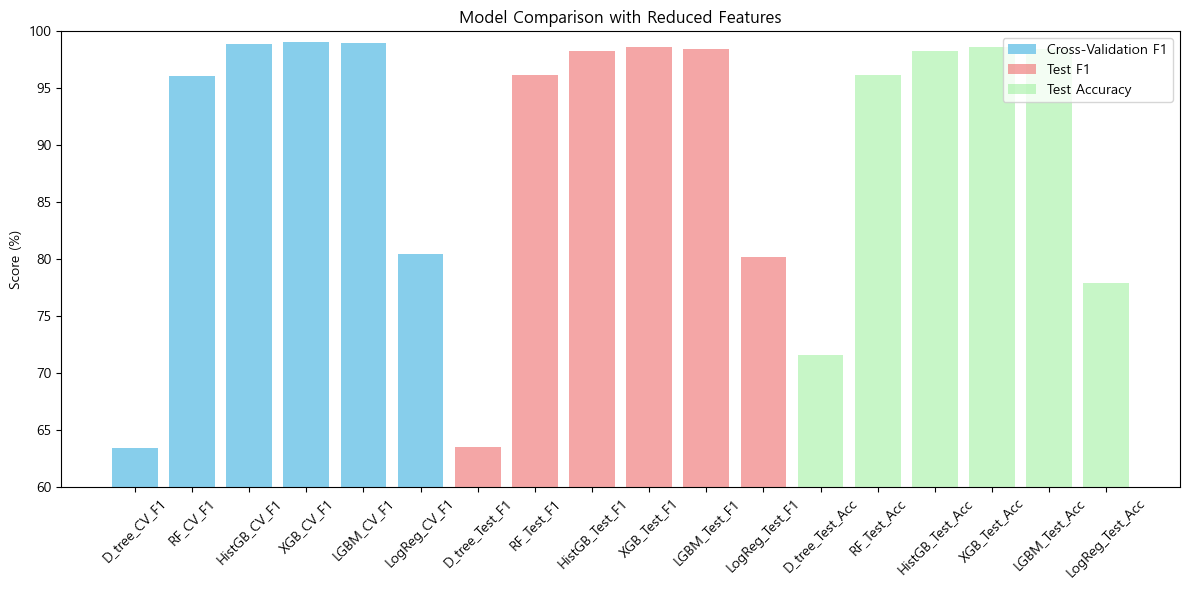

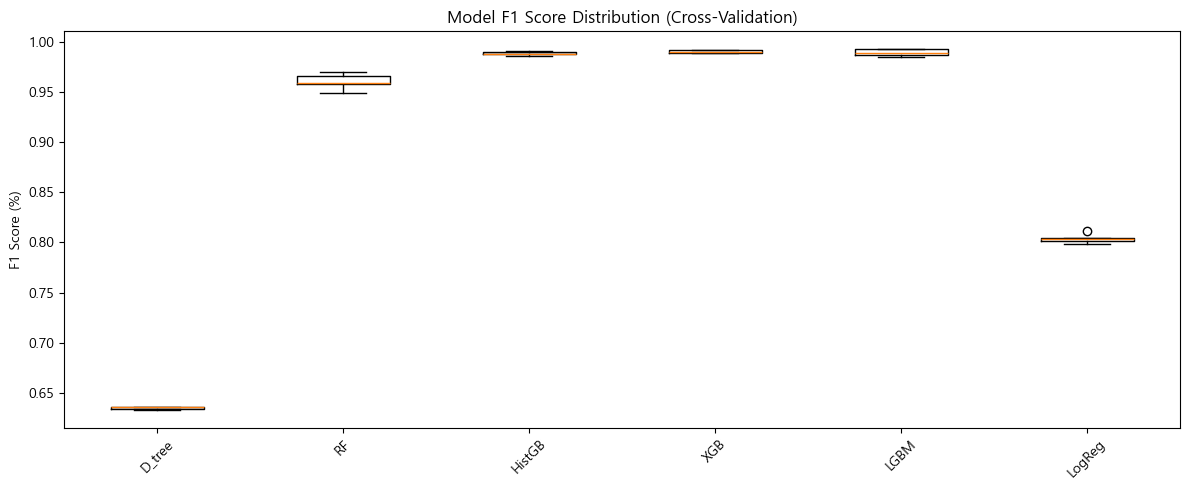

In [123]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# 입력 피처 및 타겟 설정
HE_obe_input_features= [ 'HE_wc', 'HE_wt', 'HE_sbp1', 'HE_ht', 'HE_dbp1',  'HE_glu', 'HE_alt', 'HE_crea', 'HE_TG', 'HE_HDL_st2', "HE_BMI", 'age', 'sex']

# X와 y 정의
X = data[HE_obe_input_features]
y = data['HE_obe'].astype(int) - 1

# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SMOTE로 오버샘플링
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 분류기 정의
classifiers = [
    ('D_tree', DecisionTreeClassifier(max_depth=3, min_samples_split=10, random_state=0, class_weight='balanced')),
    ('RF', RandomForestClassifier(n_estimators=50, max_depth=5, random_state=0, class_weight='balanced')),
    ('HistGB', HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=0)),
    ('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)),
    ('LGBM', LGBMClassifier(random_state=0, class_weight='balanced')),
    ('LogReg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=0))
]

classifier_names = [name for name, _ in classifiers]
classifiers = [clf for _, clf in classifiers]

# 결과 저장용 리스트
modelaccuracies = []
modelmeans = []
modelnames = []
modeltest_f1 = []
modeltest_acc = []

# 모델 훈련 및 평가
for classifier_name, classifier in zip(classifier_names, classifiers):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = cross_val_score(classifier, X_train, y_train, cv=skf, scoring='f1_weighted')
    print(f"\n▶ Mean F1 score (CV) of {classifier_name}: {accuracies.mean()*100:.2f}%")
    modelaccuracies.append(accuracies)
    modelnames.append(classifier_name)
    modelmeans.append(accuracies.mean()*100)

    classifier.fit(X_train_smote, y_train_smote)
    y_pred = classifier.predict(X_test)
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    test_acc = accuracy_score(y_test, y_pred)
    modeltest_f1.append(test_f1*100)
    modeltest_acc.append(test_acc*100)
    print(f"▶ Test F1 score of {classifier_name}: {test_f1*100:.2f}%")
    print(f"▶ Test Accuracy of {classifier_name}: {test_acc*100:.2f}%")

# 성능 시각화
plt.figure(figsize=(12, 6))
plt.ylim([60, 100])
plt.bar([name + "_CV_F1" for name in modelnames], modelmeans, color='skyblue', label='Cross-Validation F1')
plt.bar([name + "_Test_F1" for name in modelnames], modeltest_f1, color='lightcoral', label='Test F1', alpha=0.7)
plt.bar([name + "_Test_Acc" for name in modelnames], modeltest_acc, color='lightgreen', label='Test Accuracy', alpha=0.5)
plt.xticks(rotation=45)
plt.ylabel('Score (%)')
plt.title('Model Comparison with Reduced Features')
plt.legend()
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.boxplot(modelaccuracies)
ax.set_xticklabels(modelnames, rotation=45)
ax.set_ylabel('F1 Score (%)')
ax.set_title('Model F1 Score Distribution (Cross-Validation)')
plt.tight_layout()
plt.show()


| Model   | CV F1 (%) | Test F1 (%) | Test Accuracy (%) |
| ------- | --------- | ----------- | ----------------- |
| D_tree  | 63.46     | 63.55       | 71.54             |
| RF      | 96.09     | 96.20       | 96.17             |
| HistGB  | 98.88     | 98.25       | 98.26             |
| XGB     | 99.06     | 98.60       | 98.60             |
| LGBM    | 98.97     | 98.48       | 98.48             |
| LogReg  | 80.42     | 80.16       | 77.95             |


HistGB 선정

                     precision    recall  f1-score   support

      Class 0 (Low)       0.97      0.99      0.98        94
   Class 1 (Normal)       1.00      0.99      1.00       825
Class 2 (Pre-obese)       0.99      0.99      0.99       496
   Class 2 (Obese1)       0.99      0.99      0.99       646
   Class 3 (Obese2)       0.98      0.97      0.97       118
   Class 4 (Obese3)       0.97      1.00      0.99        66

           accuracy                           0.99      2245
          macro avg       0.98      0.99      0.99      2245
       weighted avg       0.99      0.99      0.99      2245



<Figure size 600x600 with 0 Axes>

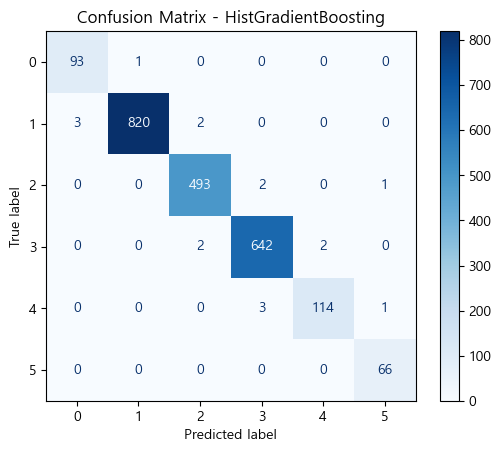

In [96]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt

# 입력 피처 및 타겟 설정
HE_obe_input_features= [ 'HE_wc', 'HE_wt', 'HE_sbp1', 'HE_ht', 'HE_dbp1',  'HE_glu', 'HE_alt', 'HE_crea', 'HE_TG', 'HE_HDL_st2', "HE_BMI", 'age', 'sex']

# X와 y 정의
X = data[HE_obe_input_features]
y = data['HE_obe'].astype(int) - 1

# 훈련/테스트 분할 먼저 수행
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 훈련 데이터에만 fit_transform
X_test_scaled = scaler.transform(X_test)  # 테스트 데이터에는 transform만 적용

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
# SMOTE를 스케일링된 훈련 데이터에 적용
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)


from sklearn.metrics import classification_report

# HistGradientBoostingClassifier로 테스트 데이터 예측
best_model = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=42)
best_model.fit(X_train_smote, y_train_smote)
y_pred = best_model.predict(X_test_scaled)

# 클래스별 F1 스코어 출력
print(classification_report(y_test, y_pred, target_names=['Class 0 (Low)', 'Class 1 (Normal)', 'Class 2 (Pre-obese)', 'Class 2 (Obese1)', 'Class 3 (Obese2)', 'Class 4 (Obese3)']))
'Low', 'Normal', 'Pre-obese', 'Obese1', 'Obese2', 'Obese3'
# 평가 지표 및 혼동행렬
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(class_report).transpose()

# 시각화
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - HistGradientBoosting")
plt.show()

HE_BMI는 중심성(0.545)에서도 상위권이지만, 첫 번째 샘플에 대한 SHAP 값(3.159)이 다른 특성들의 SHAP 값(0.413, 0.206 등)에 비해 월등히 높습니다. 이는 모델이 비만 상태를 예측할 때 **가장 강력하고 직접적으로 의존하는 특성이 HE_BMI**라는 것을 명확히 보여줍니다.

상관 행렬은 **해당 질병(종속 변수)을 예측하는 모델 내에서, 독립 변수들의 '예측에 대한 기여도(SHAP 값)' 패턴이 어떻게 서로 연관되어 있는가**를 나타내는 것

상관 행렬 샘플:
            HE_wc     HE_wt   HE_sbp1     HE_ht   HE_dbp1    HE_glu    HE_alt  \
HE_wc    1.000000 -0.225441  0.346168 -0.183762  0.010023  0.049818  0.078285   
HE_wt   -0.225441  1.000000 -0.111827  0.312991 -0.008322  0.027741  0.018898   
HE_sbp1  0.346168 -0.111827  1.000000 -0.117060  0.320166  0.082849  0.209176   
HE_ht   -0.183762  0.312991 -0.117060  1.000000  0.029039 -0.002006 -0.037664   
HE_dbp1  0.010023 -0.008322  0.320166  0.029039  1.000000  0.044969  0.202583   

          HE_crea     HE_TG  HE_HDL_st2    HE_BMI       age       sex  
HE_wc    0.066295  0.094651   -0.120019  0.301906  0.015908 -0.200780  
HE_wt    0.022983 -0.139383    0.003457 -0.487088  0.065132  0.206431  
HE_sbp1  0.243955  0.156284    0.076426  0.081955  0.144825 -0.061578  
HE_ht    0.042955 -0.065344    0.065478 -0.402007  0.277689  0.320988  
HE_dbp1  0.178625  0.152138    0.140551 -0.132152  0.295261  0.136201  

 상관 행렬 샘플:
          허리둘레(cm)  무게(kg)  수축기 혈압  신장(cm)  이완기 혈압  공복혈당  H

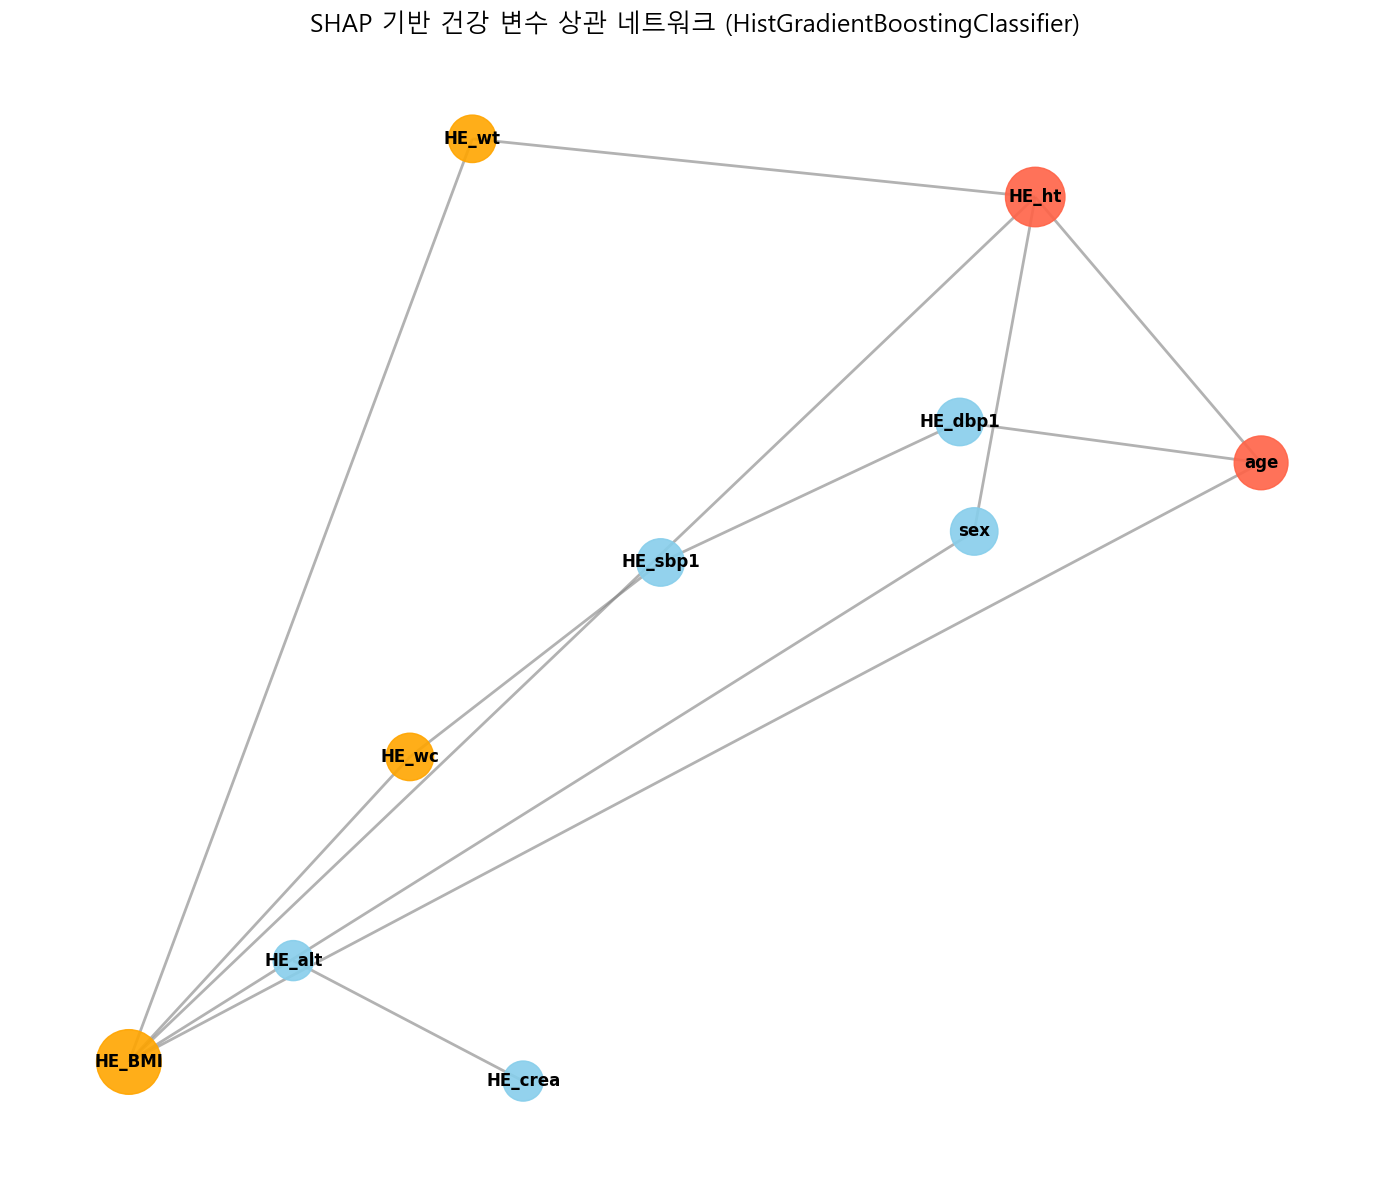


=== 질병 예측의 상위 3개 중요 피처 ===
체질량지수(BMI): SHAP 값 4.109
허리둘레(cm): SHAP 값 0.198
무게(kg): SHAP 값 0.189

=== 상위 3개 중요 피처 ===
1. 체질량지수(BMI)
2. 허리둘레(cm)
3. 무게(kg)

사용자 맞춤 리포트 요약
● 질병 예측 사례로 볼 때:
  → 비만의 예측 결과는 다른 어떤 특성보다 체질량지수(BMI) 값에 의해 가장 강력하게 결정되었으며,
    그다음으로 허리둘레(cm), 무게(kg) 가 이 개인의 당뇨 예측에 중요한 영향을 미쳤습니다.

이러한 결과는 추후 사용자 맞춤형 건강 가이드라인 제공 시 중요한 기준이 될 것 입니다.


In [97]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt
import networkx as nx

# 한글 변수명 매핑
feature_kor_map = {
'HE_glu': '공복혈당',
'HE_sbp1': '수축기 혈압',
'HE_dbp1': '이완기 혈압',
'HE_BMI': '체질량지수(BMI)',
'HE_wc' : "허리둘레(cm)",
'HE_TG': '중성지방',
'HE_chol': '총 콜레스테롤',
'HE_LDL_drct': 'LDL 콜레스테롤',
'HE_HDL_st2': 'HDL 콜레스테롤',
'sex': '성별',
'age': '나이',
'HE_wt': '무게(kg)',
'HE_ht': '신장(cm)',
'HE_crea' : '크레아틴'
}

# 입력 피처 및 타겟 설정
HE_obe_input_features= [ 'HE_wc', 'HE_wt', 'HE_sbp1', 'HE_ht', 'HE_dbp1',  'HE_glu', 'HE_alt', 'HE_crea', 'HE_TG', 'HE_HDL_st2', "HE_BMI", 'age', 'sex']

# X와 y 정의
X = data[HE_obe_input_features]
y = data['HE_obe'].astype(int) - 1


smote = SMOTE(random_state=42)
# SMOTE를 스케일링된 훈련 데이터에 적용
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)


from sklearn.metrics import classification_report

# HistGradientBoostingClassifier로 테스트 데이터 예측
best_model = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100, random_state=42)
# 스케일링되고 SMOTE 적용된 훈련 데이터로 모델 학습
best_model.fit(X_train_smote, y_train_smote)
# 스케일링된 테스트 데이터로 예측
y_pred = best_model.predict(X_test_scaled)


# SHAP 값 계산
explainer = shap.TreeExplainer(best_model)
# SHAP 값을 스케일링된 테스트 데이터에 대해 계산
shap_values = explainer.shap_values(X_test_scaled)

# SHAP 값 처리 (클래스별 평균 절대값으로 2차원 변환)
if isinstance(shap_values, list):
    # 리스트 형태일 경우 (대부분의 다중 클래스 TreeExplainer) 클래스별 절대값의 평균
    # 각 클래스별 SHAP 값의 크기를 샘플별로 평균 (n_samples, n_features)
    shap_values_class = np.mean([np.abs(val) for val in shap_values], axis=0)
elif len(shap_values.shape) == 3:  # (n_samples, n_features, n_classes) 형태일 경우
    # 클래스 차원 평균 절대값 (n_samples, n_features)
    shap_values_class = np.mean(np.abs(shap_values), axis=2)
else: # (n_samples, n_features) 형태일 경우 (이진 분류 또는 이미 클래스별 평균된 경우)
    shap_values_class = np.abs(shap_values)


# SHAP DataFrame 생성 (컬럼명은 원본 특성 이름 사용)
# 스케일링된 데이터로 SHAP을 계산했지만, DataFrame 컬럼명은 원본 특성 이름 사용
shap_df = pd.DataFrame(shap_values_class, columns=HE_obe_input_features)


# 상관 행렬 계산 및 디버깅
print("상관 행렬 샘플:")
print(shap_df.corr().head())  # 상관 행렬 일부 출력
cor_matrix = shap_df.corr()
# 컬럼명을 한글로 바꾸어 출력
cor_matrix_kor = cor_matrix.rename(index=feature_kor_map, columns=feature_kor_map)
print("\n 상관 행렬 샘플:")
print(cor_matrix_kor.round(2).head())

# 네트워크 생성
G = nx.Graph()
threshold = 0.25  # 상관계수 임계값
edge_count = 0
for i in range(len(cor_matrix.columns)):
    for j in range(i + 1, len(cor_matrix.columns)):
        corr_val = cor_matrix.iloc[i, j]
        if abs(corr_val) >= threshold:
            G.add_edge(cor_matrix.columns[i], cor_matrix.columns[j], weight=corr_val)
            edge_count += 1
print(f"네트워크에 추가된 엣지 수: {edge_count}")

# 중심성 계산 (Degree Centrality)
centrality = nx.degree_centrality(G)
if not centrality:
    print("네트워크에 노드가 없음. threshold를 낮추거나 데이터를 확인하세요.")
else:
    # 상위 3개 노드 기준으로 색 구분
    top_nodes = sorted(centrality, key=centrality.get, reverse=True)[:3]

    # 특정 샘플(첫 번째 테스트 샘플)의 상위 3개 중요 피처
    user_idx = 0  # 첫 번째 테스트 샘플
    top3_user_feats = shap_df.iloc[user_idx].abs().sort_values(ascending=False).head(3).index.tolist()

    # 노드 색상 설정
    node_colors = []
    for node in G.nodes:
        if node in top3_user_feats:
            node_colors.append('orange')  # 특정 샘플의 상위 피처
        elif node in top_nodes:
            node_colors.append('tomato')  # 중심성이 높은 피처
        else:
            node_colors.append('skyblue')  # 나머지 피처

    # 네트워크 시각화
    plt.figure(figsize=(14, 12))
    pos = nx.spring_layout(G, k=0.5, seed=42)
    node_sizes = [500 + 3000 * centrality[n] for n in G.nodes]

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=2, alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', font_color='black')

    plt.title("SHAP 기반 건강 변수 상관 네트워크 (HistGradientBoostingClassifier)", fontsize=18)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # 중심성 Top 3 변수 (한글 이름)
    top_nodes_kor = [feature_kor_map.get(node, node) for node in top_nodes]
    # SHAP Top 3 변수 (한글 이름)
    top3_feats_kor = [feature_kor_map.get(feat, feat) for feat in top3_user_feats]

    # 상위 피처 출력
    # 중심성 피처 출력
    # print("=== 상위 중심성 피처 (Top 3) ===")
    # for node in top_nodes:
    #     kor_name = feature_kor_map.get(node, node)
    #     print(f"{kor_name}: 중심성 {centrality[node]:.3f}")

    # 샘플 기반 SHAP 중요 피처 출력
    print("\n=== 질병 예측의 상위 3개 중요 피처 ===")
    for feat in top3_user_feats:
        kor_name = feature_kor_map.get(feat, feat)
        shap_val = shap_df.iloc[user_idx][feat]
        print(f"{kor_name}: SHAP 값 {shap_val:.3f}")


    # print("\n=== 상위 중심성(연관성) 피처 (Top 3) ===")
    # for idx, node in enumerate(top_nodes, 1):
    #     kor_name = feature_kor_map.get(node, node)
    #     print(f"{idx}. {kor_name}")

    print("\n=== 상위 3개 중요 피처 ===")
    for idx, feat in enumerate(top3_user_feats, 1):
        kor_name = feature_kor_map.get(feat, feat)
        shap_val = shap_df.iloc[user_idx][feat]
        print(f"{idx}. {kor_name}")

    # 출력
    print("\n사용자 맞춤 리포트 요약")

    # print(f"● 전체적으로 볼 때 (중심성(연관성) 기반):\n  → {', '.join(top_nodes_kor)} 는(은) 모델이 비만 상태를 예측할 때")
    # print("    다른 많은 생체 지표들과 복합적으로 연관되어 작용하는 핵심적인 특성들입니다.\n")

    print(f"● 질병 예측 사례로 볼 때:\n  → 비만의 예측 결과는 다른 어떤 특성보다 {top3_feats_kor[0]} 값에 의해 가장 강력하게 결정되었으며,")
    print(f"    그다음으로 {top3_feats_kor[1]}, {top3_feats_kor[2]} 가 이 개인의 당뇨 예측에 중요한 영향을 미쳤습니다.")

    print("\n이러한 결과는 추후 사용자 맞춤형 건강 가이드라인 제공 시 중요한 기준이 될 것 입니다.")
    

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV

# 사용자 입력 처리 함수
def process_user_input(user_data, features, scaler, train_means):
    user_df = pd.DataFrame([user_data]).reindex(columns=features)
    user_df = user_df.fillna(train_means)  # 누락된 피처를 평균값으로 채움
    user_scaled = scaler.transform(user_df)
    return user_df, user_scaled

# 예측 함수
def predict_disease_probabilities(user_scaled, model, stages, class_explanations):
    probs = model.predict_proba(user_scaled)[0]
    stage_index = np.argmax(probs)
    stage = stages.get(stage_index, "Unknown")
    explanation = class_explanations.get(stage_index, "No explanation available.")
    class_probs_formatted = [f"{probs[i]:.2f}" for i in range(len(probs))]
    return {
        "probabilities": class_probs_formatted,
        "predicted_class": stage_index + 1,
        "class_name": stage,
        "explanation": explanation
    }

# 각 클래스의 설명
diabetes_class_explanations = {
    0: "혈당 수준이 정상입니다. 당뇨병 위험이 낮습니다.",
    1: "혈당이 정상보다 높은 수준이지만 당뇨병에는 이르지 않았습니다. 생활습관 개선이 필요합니다.",
    2: "당뇨병으로 진단되었습니다. 전문가와 상담이 필요합니다."
}

hypertension_class_explanations = {
    0: "혈압이 정상 범위에 있습니다.",
    1: "혈압이 정상보다 높지만 고혈압 전단계로 간주됩니다. 건강 관리가 필요합니다.",
    2: "고혈압 전단계로, 생활습관 개선과 치료가 필요할 수 있습니다.",
    3: "고혈압, 전문가의 진단과 치료가 필요합니다."
}

obesity_class_explanations = {
    0: "저체중입니다. 체중 증가가 필요할 수 있습니다.",
    1: "정상 체중입니다. 유지 관리가 필요합니다.",
    2: "과체중입니다. 체중 감량을 고려할 수 있습니다.",
    3: "비만입니다. 체중 감량과 건강 관리가 필요합니다.",
    4: "고도 비만입니다. 전문가의 진단과 관리가 필요합니다.",
    5: "초고도 비만입니다. 전문가의 도움을 받아야 합니다."
}

user_data = {
    'HE_glu': 90.0,       # 공복 혈당 100~125 → 경계형 당뇨
    'HE_HbA1c': 6.0,       # HbA1c 약간 높은 수준 (참고)
    'HE_ht': 170, 
    'HE_wt': 63,           # 키 170에 체중 63이면 BMI 약 21.8 → 정상
    'HE_wc': 78, 
    'HE_BMI': 21.8,
    'HE_sbp1': 150,        # 수축기 혈압 140 이상 → 고혈압 유지
    'HE_dbp1': 90,
    'HE_sbp2': 140, 
    'HE_dbp2': 85,
    'HE_Upro': 3,
    'HE_chol': 200, 
    'HE_HDL_st2': 55,
    'HE_TG': 120, 
    'HE_LDL_drct': 110, 
    'HE_crea': 0.85, 
    'HE_ast': 22, 
    'HE_alt': 18,
    'LS_FRUOT': 5
}


# 모델, 스케일러, 피처, 평균값 로드
model_dm = joblib.load('For_HE_DM_HbA1c_calibrated_real.pkl')
scaler_dm = joblib.load('HE_DM_HbA1c_scaler_real.pkl')
features_dm = joblib.load('HE_DM_HbA1c_input_features_list_real.pkl')
train_means_dm = joblib.load('train_means_dm_real.pkl')

model_hp = joblib.load('For_HE_HP_calibrated_real.pkl')
scaler_hp = joblib.load('HE_HP_scaler_real.pkl')
features_hp = joblib.load('HE_HP_input_features_list_real.pkl')
train_means_hp = joblib.load('train_means_hp_real.pkl')

model_obesity = joblib.load('For_HE_obe_calibrated_real.pkl')
scaler_obesity = joblib.load('HE_obe_scaler_real.pkl')
features_obesity = joblib.load('HE_obe_input_features_list_real.pkl')
train_means_obesity = joblib.load('train_means_obe_real.pkl')



# 사용자 입력 처리 및 예측
user_df_dm, user_scaled_dm = process_user_input(user_data, features_dm, scaler_dm, train_means_dm)
user_df_hp, user_scaled_hp = process_user_input(user_data, features_hp, scaler_hp, train_means_hp)
user_df_obesity, user_scaled_obesity = process_user_input(user_data, features_obesity, scaler_obesity, train_means_obesity)

# 당뇨병 예측
diabetes_stages = {0: "정상", 1: "경계형 당뇨", 2: "당뇨병"}
result_dm = predict_disease_probabilities(user_scaled_dm, model_dm, diabetes_stages, diabetes_class_explanations)

# 고혈압 예측
hypertension_stages = {0: "정상 혈압", 1: "주의 혈압 단계", 2: "고혈압 전단계", 3: "고혈압"}
result_hp = predict_disease_probabilities(user_scaled_hp, model_hp, hypertension_stages, hypertension_class_explanations)

# 비만도 예측
obesity_stages = {0: "저체중", 1: "정상 체중", 2: "과체중", 3: "비만", 4: "고도 비만", 5: "초고도 비만"}
result_obesity = predict_disease_probabilities(user_scaled_obesity, model_obesity, obesity_stages, obesity_class_explanations)


def generate_disease_report(user_name, disease_name, result, top_feature_name, user_value):
    # ✅ 질병별 정상 클래스 인덱스 설정
    normal_class_index = {
        "당뇨병": 0,
        "고혈압": 0,
        "비만": 1
    }

    # ✅ 건강 점수 계산 (정상 클래스 확률 기준)
    normal_index = normal_class_index.get(disease_name, 0)
    prob_percent = float(result['probabilities'][normal_index]) * 100
    health_score = round(prob_percent, 1)

    # ✅ 예측된 클래스 확률 (예측 결과 옆에 표시)
    predicted_index = result['predicted_class'] - 1
    predicted_prob = float(result['probabilities'][predicted_index]) * 100

    # 변수 이름 매핑 (설명 추가)
    feature_label_map = {
        "HE_sbp1": "HE_sbp1 (수축기 혈압)",
        "HE_glu": "HE_glu (공복혈당)",
        "HE_BMI": "HE_BMI(BMI)"
    }
    feature_label = feature_label_map.get(top_feature_name, top_feature_name)

    # 기준 범위 설정
    if top_feature_name == "HE_sbp1":
        if user_value <= 120:
            status = "정상"
        elif 121 <= user_value <= 139:
            status = "주의"
        else:
            status = "고위험"
        normal = "90~120"
        warning = "121~139"
    elif top_feature_name == "HE_glu":
        if user_value <= 99:
            status = "정상"
        elif 100 <= user_value <= 125:
            status = "주의"
        else:
            status = "고위험"
        normal = "70~99"
        warning = "100~125"
    elif top_feature_name == "HE_BMI":
        if user_value < 18.5:
            status = "저체중"
        elif 18.5 <= user_value <= 22.9:
            status = "정상"
        elif 23.0 <= user_value <= 24.9:
            status = "과체중"
        else:
            status = "비만"
        normal = "18.5~22.9"
        warning = "23.0~24.9 이상"
    else:
        status = "알 수 없음"
        normal = "-"
        warning = "-"

    # ✅ 출력
    print(f"=== {disease_name} 예측 결과 ===")
    # 예측 결과가 정상일 때만 문구를 다르게 표시
    if result['class_name'] == "정상" or result['class_name'] == "정상 혈압" or result['class_name'] == "정상 체중":
        print(f"1. {user_name}님, 현재 {disease_name} 관련 상태는 정상으로 예측됩니다.\n")
    else:
        print(f"1. {user_name}님, 건강은 {disease_name} 위험이 있습니다.\n")
    print(f"2. 건강 점수: {health_score:.1f}점")
    print(f"예측 결과: {result['class_name']}, 예측 확률: {predicted_prob:.1f}%)")
    print(f"설명: {result['explanation']}\n")

    print(f"3. {feature_label} 수치: {user_value} → 상태: {status}")
    print(f"정상 기준: {normal}, 주의 기준: {warning}")
    print(f"이 수치가 높아지면 {disease_name} 위험이 증가합니다.\n")

# 대표 feature 맵
top_features = {
    "당뇨병": "HE_glu",
    "고혈압": "HE_sbp1",
    "비만": "HE_BMI"
}


# 질병별 결과를 묶기
disease_results = {
    "당뇨병": result_dm,
    "고혈압": result_hp,
    "비만": result_obesity
}

    # 자동 리포트 출력
for disease_name, result in disease_results.items():
    top_feature = top_features[disease_name]
    user_value = user_data.get(top_feature, None)

    if user_value is not None:
        generate_disease_report(
            user_name="홍길동",
            disease_name=disease_name,
            result=result,
            top_feature_name=top_feature,
            user_value=user_value
        )
    else:
        print(f"{disease_name}에 대한 {top_feature} 값이 user_data에 없습니다.")


=== 당뇨병 예측 결과 ===
1. 홍길동님, 현재 당뇨병 관련 상태는 정상으로 예측됩니다.

2. 건강 점수: 80.0점
예측 결과: 정상, 예측 확률: 80.0%)
설명: 혈당 수준이 정상입니다. 당뇨병 위험이 낮습니다.

3. HE_glu (공복혈당) 수치: 90.0 → 상태: 정상
정상 기준: 70~99, 주의 기준: 100~125
이 수치가 높아지면 당뇨병 위험이 증가합니다.

=== 고혈압 예측 결과 ===
1. 홍길동님, 건강은 고혈압 위험이 있습니다.

2. 건강 점수: 0.0점
예측 결과: 고혈압, 예측 확률: 72.0%)
설명: 고혈압, 전문가의 진단과 치료가 필요합니다.

3. HE_sbp1 (수축기 혈압) 수치: 150 → 상태: 고위험
정상 기준: 90~120, 주의 기준: 121~139
이 수치가 높아지면 고혈압 위험이 증가합니다.

=== 비만 예측 결과 ===
1. 홍길동님, 현재 비만 관련 상태는 정상으로 예측됩니다.

2. 건강 점수: 96.0점
예측 결과: 정상 체중, 예측 확률: 96.0%)
설명: 정상 체중입니다. 유지 관리가 필요합니다.

3. HE_BMI(BMI) 수치: 21.8 → 상태: 정상
정상 기준: 18.5~22.9, 주의 기준: 23.0~24.9 이상
이 수치가 높아지면 비만 위험이 증가합니다.

